# ODR - Code Examples

## General Investigation of ODR

In [538]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.odr import ODR, Model, RealData
import scipy.stats as stats
import seaborn as sns

In [539]:
def model_function(beta, x):
    """
    The custom function to approximate the data.
    f(x; A, B) = A * (np.exp(-B * x) - 1) + 100
    Note: The signature is now (beta, x) for scipy.odr.
    """
    A, B = beta
    return A * (np.exp(-B * x) - 1) + 100

In [540]:
# Dataset 3
x = np.array([0, 23, 51, 98, 196, 292, 401])
y_obs = np.array([100, 87.8, 77, 65.7, 50.9, 46.5, 44.4])
sigma_x = np.full_like(x, 2.0, dtype=float)
sigma_y = np.full_like(y_obs, 0.5, dtype=float)
initial_guess = [50, 0.01]

results = {}

In [541]:
# Define the ODR model and data
odr_model = Model(model_function)
odr_data = RealData(x, y_obs, sx=sigma_x, sy=sigma_y)

# Instantiate and run the ODR fit
odr_instance = ODR(odr_data, odr_model, beta0=initial_guess)
output = odr_instance.run()

In [542]:
output.pprint()

Beta: [5.67694275e+01 9.88335260e-03]
Beta Std Error: [4.26741666e-01 2.63972932e-04]
Beta Covariance: [[ 2.41744445e-01 -1.18588964e-04]
 [-1.18588964e-04  9.25007382e-08]]
Residual Variance: 0.7533097575791786
Inverse Condition #: 0.17698951436366908
Reason(s) for Halting:
  Sum of squares convergence


### Inverse Condition Number

The "Inverse Condition #" is the reciprocal (1/x) of the condition number. The condition number itself is a measure of how sensitive the solution (the estimated parameters of your model) is to changes in the input data.

*   **A large Inverse Condition Number (close to 1)** indicates a well-conditioned problem. This is desirable and suggests that small changes in your input data will only cause small changes in the estimated parameters.
    * Our result of approximately 0.177 is in a moderate range - it's not ideal (e.g., >0.5 would be better for high precision), but it's far from problematic levels (e.g., <0.01), especially for a small dataset like ours. No major numerical instability is indicated here, and the fit should be reliable for practical purposes (for practical purposes, as long as inverse condition number isn't extremely close to zero, it's generally acceptable).

*   **A small Inverse Condition Number (close to 0)** points to an ill-conditioned problem. In such cases, minor variations in the input data could lead to significant changes in the determined parameters, making the solution less reliable.

In essence, this number helps you gauge the numerical stability and reliability of the parameter estimates provided by the Orthogonal Distance Regression (ODR) fit.

### Reason(s) for Halting: Sum of Squares Convergence

This indicates why the iterative fitting process stopped. The ODR algorithm works by iteratively adjusting the parameters (`A` and `B` in your model) to minimize the sum of the squared weighted orthogonal distances from the data points to the fitted curve.

"Sum of squares convergence" means that the algorithm terminated because the improvements in the sum of squared residuals from one iteration to the next became negligibly small. This is a standard and successful stopping criterion for such optimization routines. It implies that the algorithm has found a stable solution where further adjustments to the parameters do not significantly improve the fit to the data.

In [543]:
fit_params = output.beta
print(f"Fitted parameters (output.beta): {fit_params}")

sd_beta = output.sd_beta
print(f"Standard deviations of the parameters (output.sd_beta): {sd_beta}")

sd_beta_2 = np.sqrt(np.diag(output.cov_beta * output.res_var))
print(f"Standard deviations of the parameters (alternative calculation using cov_beta): {sd_beta_2}")

inv_cond_num = output.inv_condnum
print(f"Inverse condition number (output.inv_condnum): {inv_cond_num}")


Fitted parameters (output.beta): [5.67694275e+01 9.88335260e-03]
Standard deviations of the parameters (output.sd_beta): [4.26741666e-01 2.63972932e-04]
Standard deviations of the parameters (alternative calculation using cov_beta): [4.26741666e-01 2.63972932e-04]
Inverse condition number (output.inv_condnum): 0.17698951436366908


In [544]:
# Store the original data in the results dictionary for plotting later
results['original_x'] = x
results['original_y'] = y_obs
results['original_sigma_x'] = sigma_x
results['original_sigma_y'] = sigma_y
results['original_weights_x'] = 1.0 / (sigma_x**2)
results['original_weights_y'] = 1.0 / (sigma_y**2)

# Store results from ODR's Output object
results['odr_output'] = output
results['fit_params'] = output.beta
results['std_errs'] = output.sd_beta
results['cov_beta'] = output.cov_beta
results['number_of_observations'] = len(x)
results['number_of_parameters'] = len(output.beta)
results['degrees_of_freedom'] = results['number_of_observations'] - results['number_of_parameters']
results['inverse_condition_number'] = output.inv_condnum

In [545]:
t_values = results['fit_params'] / results['std_errs']
p_values = stats.t.sf(np.abs(t_values), df=results['degrees_of_freedom']) * 2
results['t_values'] = t_values
results['p_values'] = p_values
print(f"t-values: {t_values}")
print(f"p-values: {p_values}")


t-values: [133.02996178  37.44078054]
p-values: [4.55295786e-10 2.56015184e-07]


In [546]:
delta_x = output.delta
results['delta_x'] = delta_x
print(f"Array of estimated errors in input variables, of same shape as x (output.delta):\n{delta_x}")

epsilon_y = output.eps
results['epsilon_y'] = epsilon_y
print(f"Array of estimated errors in response variables, of same shape as y (output.eps):\n{epsilon_y}")

Array of estimated errors in input variables, of same shape as x (output.delta):
[ 0.          1.12128483  1.00051757 -1.82517415  0.59658578 -0.05011438
 -0.01544762]
Array of estimated errors in response variables, of same shape as y (output.eps):
[ 0.          0.15853071  0.18633185 -0.52598787  0.46385468 -0.09998956
 -0.09054455]


In [547]:
x_pred = output.xplus
results['x_pred'] = output.xplus
print(f"Array of predicted x values (output.xplus):\n{x_pred}")

x_pred_2 = x + output.delta
print(f"Array of predicted x values (x + output.delta):\n{x_pred_2}")

y_pred = output.y
results['y_pred'] = output.y
print(f"\nArray of predicted y values (output.y):\n{y_pred}")

y_pred_2 = model_function(results['fit_params'], x + delta_x)
print(f"Array of predicted y values (model_function with (x + delta_x) argument):\n{y_pred_2}")

Array of predicted x values (output.xplus):
[  0.          24.12128483  52.00051757  96.17482585 196.59658578
 291.94988562 400.98455238]
Array of predicted x values (x + output.delta):
[  0.          24.12128483  52.00051757  96.17482585 196.59658578
 291.94988562 400.98455238]

Array of predicted y values (output.y):
[100.          87.95853071  77.18633185  65.17401213  51.36385468
  46.40001044  44.30945545]
Array of predicted y values (model_function with (x + delta_x) argument):
[100.          87.95853071  77.18633185  65.17401213  51.36385468
  46.40001044  44.30945545]


### Predicted values of x and y

- `output.xplus` represents the "predicted" or adjusted x-values. These are computed as the original `x` plus the estimated errors/adjustments in the input variables (`output.delta`), i.e., `xplus = x + delta`. They correspond to the x-coordinates on the fitted curve that are closest (in an orthogonal sense) to each observed data point `(x[i], y_obs[i])`.

- `output.y` represents the predicted y-values, which are the model's evaluations at those adjusted x-values: `y = model_function(beta, xplus)`. These are the y-coordinates on the fitted curve corresponding to the same closest points.

Together, the pairs `(output.xplus[i], output.y[i])` are the projections (feet of the perpendiculars) of our observed data points onto the fitted curve. This differs from ordinary least squares regression (where errors are assumed only in y, and predictions are simply `model_function(beta, x)` at the original x-values). In ODR, since errors are considered in both x and y, these adjusted predictions account for uncertainties in both directions, minimizing the orthogonal distances.

Our code already demonstrates this equivalence with the alternative calculations:
- `x_pred_2 = x + output.delta` matches `output.xplus`.
- `y_pred_2 = model_function(fit_params, x + delta_x)` matches `output.y`.

In [548]:
sum_square_delta = output.sum_square_delta
print(f"Sum of squares of delta error (output.sum_square_delta): {sum_square_delta:.4f}")

delta_errors = output.delta
manual_sum_square_delta = np.sum((delta_errors / sigma_x)**2)
print(f"Manually calculated sum_square_delta: {manual_sum_square_delta:.4f}")

sum_square_eps = output.sum_square_eps
print(f"\nSum of squares of epsilon error (output.sum_square_eps): {sum_square_eps:.4f}")

epsilon_errors = output.eps
manual_sum_square_eps = np.sum((epsilon_errors / sigma_y)**2)
print(f"Manually calculated sum_square_eps: {manual_sum_square_eps:.4f}")

Sum of squares of delta error (output.sum_square_delta): 1.4871
Manually calculated sum_square_delta: 1.4871

Sum of squares of epsilon error (output.sum_square_eps): 2.2795
Manually calculated sum_square_eps: 2.2795


In [549]:
sum_square = output.sum_square
results['chi_squared_odr'] = output.sum_square
print(f"Chi-squared (output.sum_square): {sum_square:.4f}")

res_var = output.res_var
results['reduced_chi_squared_odr'] = output.res_var
print(f"Reduced Chi-squared (output.res_var): {res_var:.4f}")

# Calculate Chi-Squared manually as per the formula
# ODR output provides delta (residuals in x) and eps (residuals in y)
chi_squared_manual = np.sum((output.delta / sigma_x)**2 + (output.eps / sigma_y)**2)
results['chi_squared_manual'] = chi_squared_manual
print(f"Chi-squared (manual calculation): {chi_squared_manual:.4f}")

# Reduced Chi-Squared (manual calculation)
reduced_chi_squared_manual = chi_squared_manual / results['degrees_of_freedom']
results['reduced_chi_squared_manual'] = reduced_chi_squared_manual
print(f"Reduced Chi-squared (manual calculation): {reduced_chi_squared_manual:.4f}")

Chi-squared (output.sum_square): 3.7665
Reduced Chi-squared (output.res_var): 0.7533
Chi-squared (manual calculation): 3.7665
Reduced Chi-squared (manual calculation): 0.7533


In [550]:
# Information Criteria (using the log-likelihood for ODR, which is implicitly
# based on the chi-squared statistic, assuming a Gaussian error model).
n = results['number_of_observations']
p = results['number_of_parameters']

# A log-likelihood for ODR, based on the chi-squared value.
llf = - n * np.log(2 * np.pi) - np.sum(np.log(sigma_x)) - np.sum(np.log(sigma_y)) - 0.5 * results['chi_squared_odr']

aic = -2 * llf + 2 * p
bic = -2 * llf + np.log(n) * p
aicc = aic + (2 * p * (p + 1)) / (n - p - 1)

results['log_likelihood'] = llf
results['aic'] = aic
results['bic'] = bic
results['aicc'] = aicc

print('Maximum Log-Likelihood:', llf)
print('AIC:', aic)
print('BIC:', bic)
print('AICC:', aicc)

Maximum Log-Likelihood: -14.748413858813365
AIC: 33.49682771762673
BIC: 33.38864801573735
AICC: 36.49682771762673


## General Methods for ODR Analysis

In [551]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.odr import ODR, Model, RealData
import scipy.stats as stats
import seaborn as sns
from tabulate import tabulate


In [552]:
def analyze_odr(x, y_obs, sigma_x, sigma_y, function, initial_guess):
    """
    Performs an Orthogonal Distance Regression (ODR) curve fit and calculates
    various goodness-of-fit and error metrics.

    Args:
        x (np.array): The independent variable data.
        y_obs (np.array): The observed dependent variable data.
        sigma_x (np.array): The standard deviations of the x points.
        sigma_y (np.array): The standard deviations of the y_obs points.
        function (callable): The function to fit to the data.
        initial_guess (list): The initial guess for the function parameters.

    Returns:
        dict: A dictionary containing all the calculated results.
    """
    results = {}

    # Define the ODR model and data
    odr_model = Model(function)
    odr_data = RealData(x, y_obs, sx=sigma_x, sy=sigma_y)

    # Instantiate and run the ODR fit
    odr_instance = ODR(odr_data, odr_model, beta0=initial_guess)
    output = odr_instance.run()

    # Store the original data in the results dictionary for plotting later
    results['original_x'] = x
    results['original_y'] = y_obs
    results['original_sigma_x'] = sigma_x
    results['original_sigma_y'] = sigma_y
    results['original_weights_x'] = 1.0 / (sigma_x**2)
    results['original_weights_y'] = 1.0 / (sigma_y**2)
    
    # Store results from ODR's Output object
    results['odr_output'] = output
    results['fit_params'] = output.beta
    results['std_errs'] = output.sd_beta
    results['cov_beta'] = output.cov_beta
    results['number_of_observations'] = len(x)
    results['number_of_parameters'] = len(output.beta)
    results['degrees_of_freedom'] = results['number_of_observations'] - results['number_of_parameters']
    results['inverse_condition_number'] = output.inv_condnum

    # Calculate t-values and p-values
    t_values = results['fit_params'] / results['std_errs']
    p_values = stats.t.sf(np.abs(t_values), df=results['degrees_of_freedom']) * 2
    results['t_values'] = t_values
    results['p_values'] = p_values

    results['delta_x'] = output.delta
    results['epsilon_y'] = output.eps
    results['x_pred'] = output.xplus
    results['y_pred'] = output.y

    # Chi-Squared and Reduced Chi-Squared from ODR output
    results['chi_squared_odr'] = output.sum_square
    results['reduced_chi_squared_odr'] = output.res_var

    # Information Criteria (using the log-likelihood for ODR, which is implicitly
    # based on the chi-squared statistic, assuming a Gaussian error model).
    n = results['number_of_observations']
    p = results['number_of_parameters']

    # A log-likelihood for ODR, based on the chi-squared value.
    llf = - n * np.log(2 * np.pi) - np.sum(np.log(sigma_x)) - np.sum(np.log(sigma_y)) - 0.5 * results['chi_squared_odr']

    aic = -2 * llf + 2 * p
    bic = -2 * llf + np.log(n) * p
    aicc = aic + (2 * p * (p + 1)) / (n - p - 1)

    results['log_likelihood'] = llf
    results['aic'] = aic
    results['bic'] = bic
    results['aicc'] = aicc

    return results

In [553]:
def print_metrics(results):
    """
    Prints the calculated metrics from the results dictionary for ODR.
    """
    output = results['odr_output']
    fit_params = results['fit_params']
    std_errs = results['std_errs']
    t_values = results['t_values']
    p_values = results['p_values']
    n = results['number_of_observations']
    p = results['number_of_parameters']

    print("--- ODR Fit Results ---")
    output.pprint()
    
    print("\n--- Summary of Results ---")
    for i, (param, err) in enumerate(zip(fit_params, std_errs)):
        print(f"Parameter {chr(ord('A') + i)}: {param:.5f} +/- {err:.5f}")
        print(f"  T-value: {t_values[i]:.8f}, P-value: {p_values[i]:.8f}")

    print("\n--- Model Fit Statistics ---")
    print(f"\nNumber of Observations (n): {n}")
    print(f"Number of Parameters (p): {p}")
    print(f"Degrees of Freedom (n-p): {results['degrees_of_freedom']}")

    print("\n--- Goodness-of-Fit & Error Metrics ---")
    print(f"Chi-Squared (from ODR): {results['chi_squared_odr']:.4f}")
    print(f"Reduced Chi-Squared (from ODR): {results['reduced_chi_squared_odr']:.4f}")
    
    print("\n--- Information Criteria ---")
    print(f"Maximum Log-Likelihood: {results['log_likelihood']:.4f}")
    print(f"AIC (Akaike Information Criterion): {results['aic']:.4f}")
    print(f"BIC (Bayesian Information Criterion): {results['bic']:.4f}")
    print(f"AICc (Corrected AIC): {results['aicc']:.4f}")

    print("\n--- Comparison of Original and Predicted Data Points ---")
    
    # Unpack data points
    x_orig = results['original_x']
    y_orig = results['original_y']
    x_pred = results['x_pred']
    y_pred = results['y_pred']

    # Prepare data for the table
    comparison_data = zip(x_orig, x_pred, y_orig, y_pred)
    comp_headers = ["Original X", "Predicted X (x_plus)", "Original Y", "Predicted Y (fit)"]

    # Print the formatted table
    print(tabulate(comparison_data, headers=comp_headers, floatfmt=".4f"))

In [554]:
def draw_curve_fit(results, model_function):
    """
    Visualizes the ODR fit with a 95% confidence band.

    Args:
        results (dict): The dictionary returned by the analyze_odr function.
        model_function (callable): The model function used for the fit.
    """
    # --- 1. Unpack data from the results dictionary ---
    x_data = results["original_x"]
    y_data = results["original_y"]
    sigma_x = results["original_sigma_x"]
    sigma_y = results["original_sigma_y"]
    popt = results['fit_params']
    perr = results['std_errs']
    cov_beta = results['cov_beta']
    df = results['degrees_of_freedom']
    
    # --- 2. Set up the plot ---
    plt.figure(figsize=(14, 8))
    sns.set_theme(style="whitegrid")

    # --- 3. Plot the curve fit ---
    
    # Plot original data with error bars
    plt.errorbar(
        x_data, y_data, 
        xerr=sigma_x, yerr=sigma_y, 
        fmt='o', color='royalblue', ecolor='black', capsize=3,
        label="Original Data", zorder=5
    )

    # Generate points for the fitted curve and confidence band
    x_plot = np.linspace(min(x_data), max(x_data) * 1.05, 400)
    y_plot = model_function(popt, x_plot)
    
    # --- 4. Calculate and plot the 95% confidence band ---
    def jacobian(beta, x):
        A, B = beta
        # Partial derivatives of the model function w.r.t. parameters A and B
        d_dA = np.exp(-B * x) - 1
        d_dB = -A * x * np.exp(-B * x)
        return np.array([d_dA, d_dB]).T
        
    J = jacobian(popt, x_plot)
    # Variance of the predicted y values
    var_y_plot = np.sum(J @ cov_beta * J, axis=1)
    # Standard error of the predicted y values
    se_y_plot = np.sqrt(var_y_plot)
    
    # Get the critical t-value for 95% confidence
    t_val = stats.t.ppf(0.975, df)
    
    # Confidence interval half-width
    ci = t_val * se_y_plot
    
    # Plot the confidence band
    plt.fill_between(
        x_plot, y_plot - ci, y_plot + ci, 
        color='red', alpha=0.2, label="95% Confidence Band"
    )

    # Plot the fitted curve
    label_text = (
        f"ODR Fitted Curve\n"
        f"A={popt[0]:.3f} ± {perr[0]:.3f}\n"
        f"B={popt[1]:.5f} ± {perr[1]:.5f}"
    )
    plt.plot(x_plot, y_plot, color='red', label=label_text)

    # --- 5. Configure title, labels, and final layout ---
    title = f"Orthogonal Distance Regression (ODR) Fit\nReduced $\\chi^2$ = {results['reduced_chi_squared_odr']:.4f}"
    plt.title(title, fontsize=14)
    plt.xlabel("X-Value")
    plt.ylabel("Y-Value")
    plt.legend()
    plt.grid(True)
    
    plt.xlim(xmin=min(x_data) - 5)
    plt.ylim(ymin=min(y_data) - 10, ymax=max(y_data) + 10)
    
    plt.tight_layout()
    plt.show()

In [555]:
def plot_predicted_vs_observed(results, show_errors=False):
    """
    Creates scatter plots to compare observed vs. predicted values for x and y,
    with an option to display error bars for both observed and predicted values.

    Args:
        results (dict): The dictionary returned by the analyze_odr function.
        show_errors (bool): If True, displays error bars on the plots. 
                            The results dict must contain 'sd_xplus' and 'sd_y'.
    """
    # --- 1. Unpack the required data from the results dictionary ---
    x_obs = results['original_x']
    y_obs = results['original_y']
    x_pred = results['x_pred']
    y_pred = results['y_pred']

    # --- 2. Set up the figure with two subplots ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    sns.set_theme(style="whitegrid")
    
    # --- 3. First subplot: Observed X vs. Predicted X ---
    if show_errors:
        sigma_x = results["original_sigma_x"]
        if sigma_x is None:
            print("Warning: 'original_sigma_x' not in results. Cannot plot predicted X errors.")
            ax1.scatter(x_obs, x_pred, c='royalblue', zorder=10, label='Data Points')
        else:
            ax1.errorbar(
                x_obs, x_pred, yerr=sigma_x,
                fmt='o', ecolor='black', capsize=3, color='royalblue', zorder=10, label='Data Points'
            )
    else:
        ax1.scatter(x_obs, x_pred, c='royalblue', zorder=10, label='Data Points')

    # Create the line of identity (y=x)
    lims_x = [
        min(ax1.get_xlim()[0], ax1.get_ylim()[0], min(x_obs), min(x_pred)),
        max(ax1.get_xlim()[1], ax1.get_ylim()[1], max(x_obs), max(x_pred)),
    ]
    ax1.plot(lims_x, lims_x, 'r--', alpha=0.75, zorder=5, label='Identity Line')
    
    ax1.set_title('Predicted X vs. Observed X', fontsize=14)
    ax1.set_xlabel('Observed X Values (with measurement error)', fontsize=12)
    ax1.set_ylabel('Predicted X Values (with prediction error)', fontsize=12)
    ax1.set_aspect('equal', 'box')
    ax1.grid(True)
    ax1.legend()

    # --- 4. Second subplot: Observed Y vs. Predicted Y ---
    if show_errors:
        sigma_y = results["original_sigma_y"]
        if sigma_y is None:
            print("Warning: 'original_sigma_y' not in results. Cannot plot predicted Y errors.")
            ax2.scatter(y_obs, y_pred, c='green', zorder=10, label='Data Points')
        else:
            ax2.errorbar(
                y_obs, y_pred, yerr=sigma_y,
                fmt='o', ecolor='black', capsize=3, color='green', zorder=10, label='Data Points'
            )
    else:
        ax2.scatter(y_obs, y_pred, c='green', zorder=10, label='Data Points')
    
    # Create the line of identity
    lims_y = [
        min(ax2.get_xlim()[0], ax2.get_ylim()[0], min(y_obs), min(y_pred)),
        max(ax2.get_xlim()[1], ax2.get_ylim()[1], max(y_obs), max(y_pred)),
    ]
    ax2.plot(lims_y, lims_y, 'r--', alpha=0.75, zorder=5, label='Identity Line')
    
    ax2.set_title('Predicted Y vs. Observed Y', fontsize=14)
    ax2.set_xlabel('Observed Y Values (with measurement error)', fontsize=12)
    ax2.set_ylabel('Predicted Y Values (with prediction error)', fontsize=12)
    ax2.set_aspect('equal', 'box')
    ax2.grid(True)
    ax2.legend()
    
    # --- 5. Final adjustments and display ---
    fig.suptitle('Comparison of Observed and ODR-Predicted Values', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

## Usage of Methods. Dataset 3

--- ODR Fit Results ---
Beta: [5.67471826e+01 9.91153159e-03]
Beta Std Error: [3.73741090e-01 2.58479394e-04]
Beta Covariance: [[ 2.68145384e-01 -1.48447716e-04]
 [-1.48447716e-04  1.28256824e-07]]
Residual Variance: 0.520920405677155
Inverse Condition #: 0.15743721227613128
Reason(s) for Halting:
  Sum of squares convergence

--- Summary of Results ---
Parameter A: 56.74718 +/- 0.37374
  T-value: 151.83554632, P-value: 0.00000000
Parameter B: 0.00991 +/- 0.00026
  T-value: 38.34553867, P-value: 0.00000023

--- Model Fit Statistics ---

Number of Observations (n): 7
Number of Parameters (p): 2
Degrees of Freedom (n-p): 5

--- Goodness-of-Fit & Error Metrics ---
Chi-Squared (from ODR): 2.6046
Reduced Chi-Squared (from ODR): 0.5209

--- Information Criteria ---
Maximum Log-Likelihood: -17.0057
AIC (Akaike Information Criterion): 38.0114
BIC (Bayesian Information Criterion): 37.9032
AICc (Corrected AIC): 41.0114

--- Comparison of Original and Predicted Data Points ---
  Original X    Pre

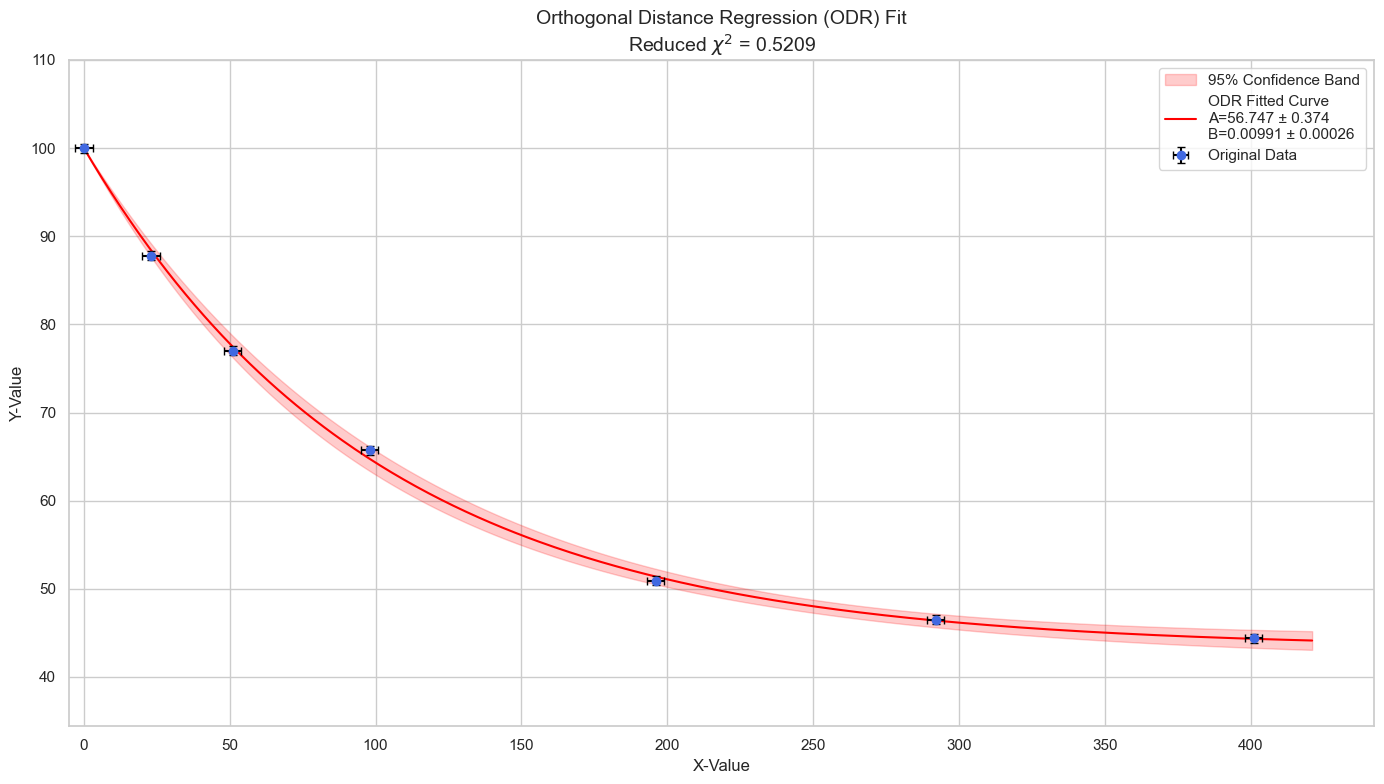

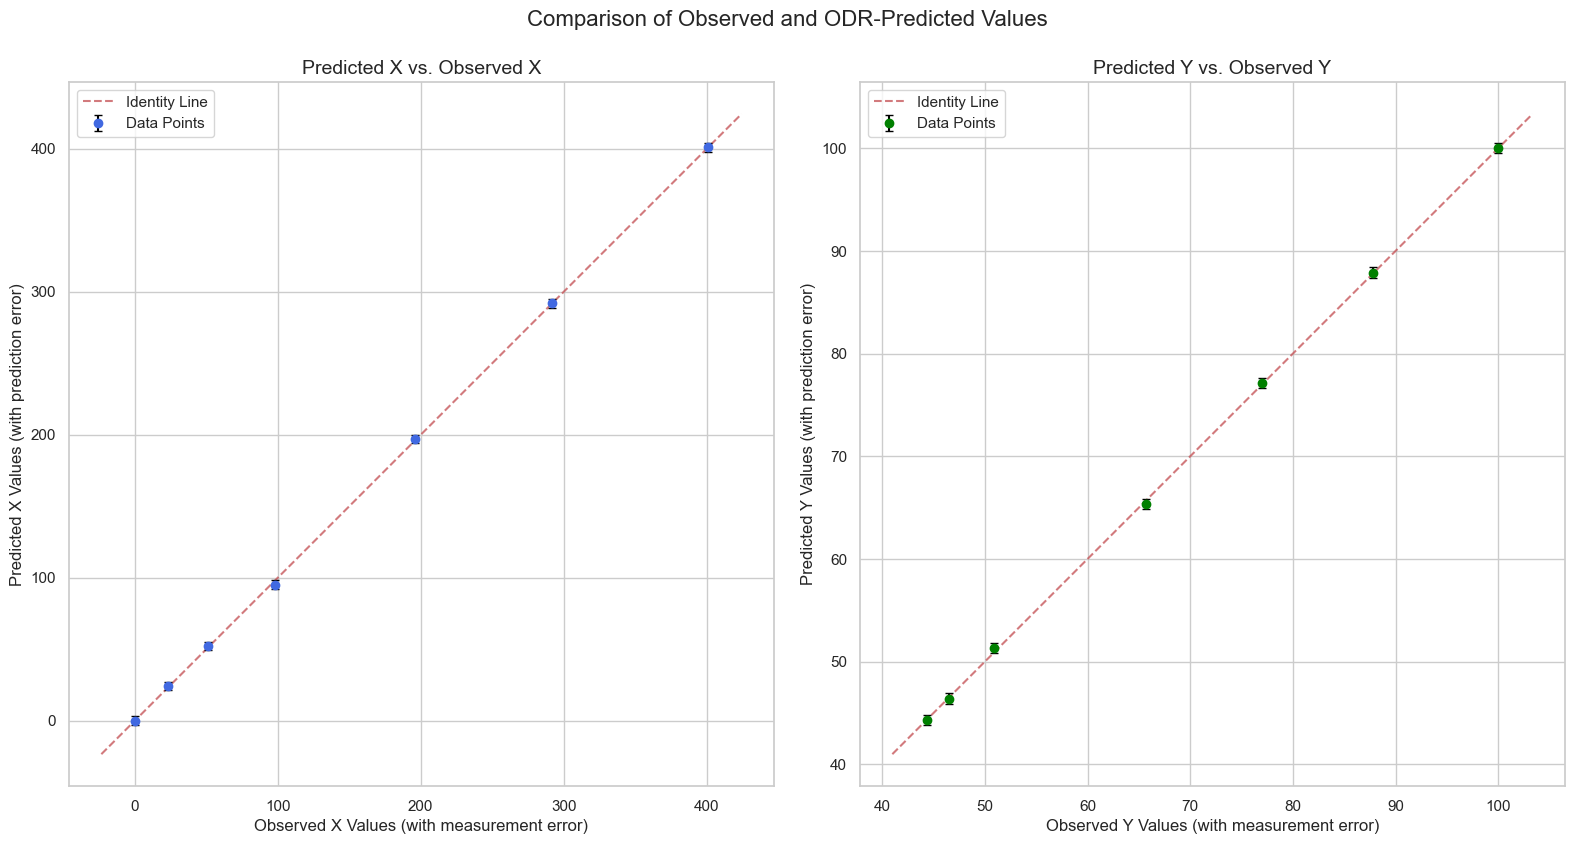

In [556]:
def model_function(beta, x):
    """
    The custom function to approximate the data.
    f(x; A, B) = A * (np.exp(-B * x) - 1) + 100
    Note: The signature is now (beta, x) for scipy.odr.
    """
    A, B = beta
    return A * (np.exp(-B * x) - 1) + 100

# Dataset 3
x = np.array([0, 23, 51, 98, 196, 292, 401])
y_obs = np.array([100, 87.8, 77, 65.7, 50.9, 46.5, 44.4])
sigma_y = np.full_like(y_obs, 0.5, dtype=float)
# sigma_x = np.full_like(x, 2.0, dtype=float)
sigma_x = np.full_like(x, 3.0, dtype=float)
initial_guess = [50, 0.01]

# Analyze the curve fit and get results using ODR
odr_results = analyze_odr(x, y_obs, sigma_x, sigma_y, model_function, initial_guess)

# Print the metrics
print_metrics(odr_results)

# Draw the curve fit plot
draw_curve_fit(odr_results, model_function)

# Plot predicted vs observed values
plot_predicted_vs_observed(odr_results, show_errors=True)

## Usage of Methods. Dataset 1

--- ODR Fit Results ---
Beta: [1.00575020e+02 2.26572259e-02]
Beta Std Error: [3.44395956e+00 2.13548845e-03]
Beta Covariance: [[ 3.79384260e+00 -2.19447013e-03]
 [-2.19447013e-03  1.45867210e-06]]
Residual Variance: 3.126344114120784
Inverse Condition #: 0.09653487400105343
Reason(s) for Halting:
  Sum of squares convergence

--- Summary of Results ---
Parameter A: 100.57502 +/- 3.44396
  T-value: 29.20331044, P-value: 0.00000088
Parameter B: 0.02266 +/- 0.00214
  T-value: 10.60985645, P-value: 0.00012861

--- Model Fit Statistics ---

Number of Observations (n): 7
Number of Parameters (p): 2
Degrees of Freedom (n-p): 5

--- Goodness-of-Fit & Error Metrics ---
Chi-Squared (from ODR): 15.6317
Reduced Chi-Squared (from ODR): 3.1263

--- Information Criteria ---
Maximum Log-Likelihood: -20.6810
AIC (Akaike Information Criterion): 45.3620
BIC (Bayesian Information Criterion): 45.2538
AICc (Corrected AIC): 48.3620

--- Comparison of Original and Predicted Data Points ---
  Original X    Pr

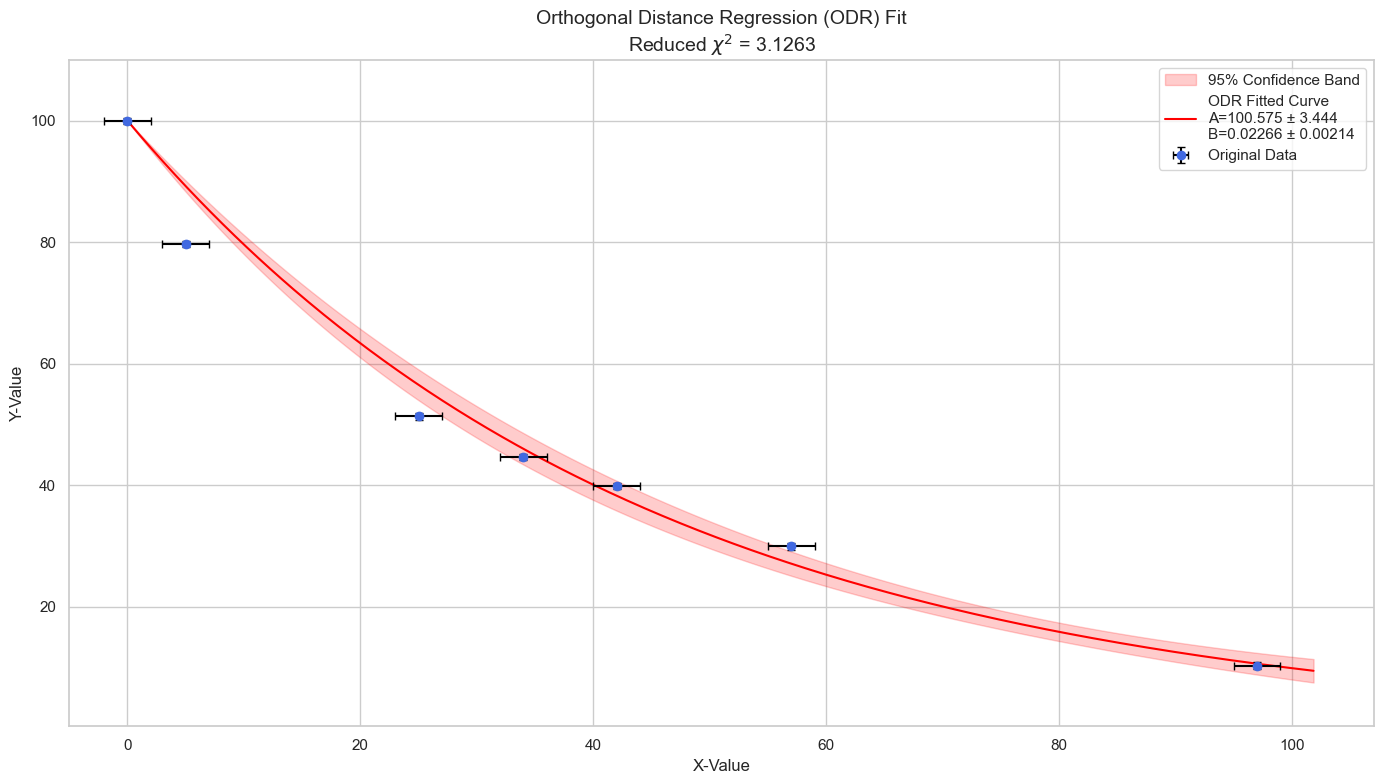

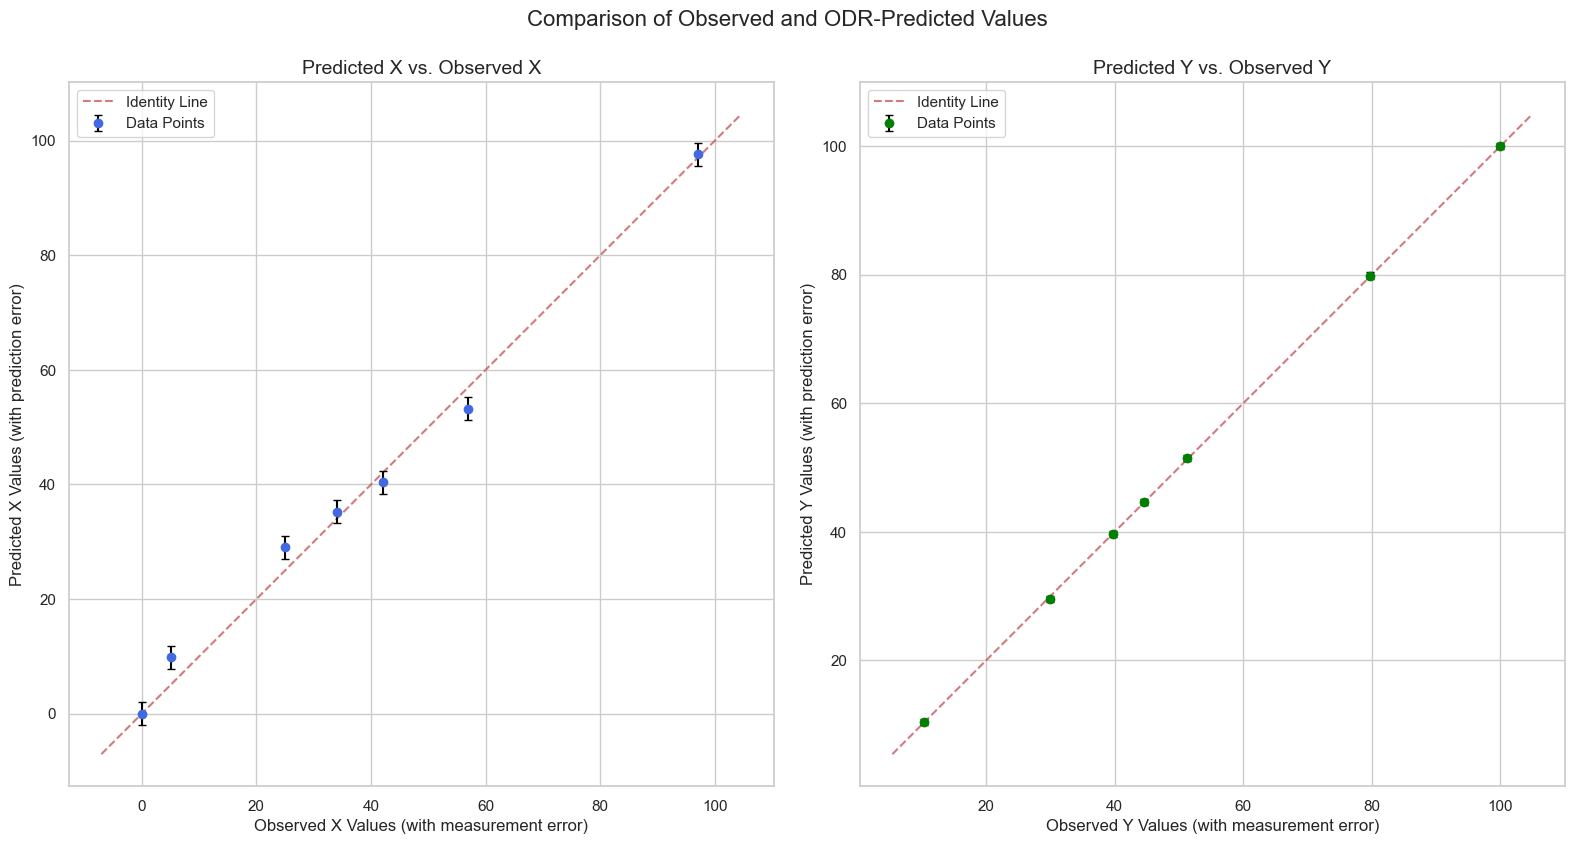

In [557]:
def model_function(beta, x):
    """
    The custom function to approximate the data.
    f(x; A, B) = A * (np.exp(-B * x) - 1) + 100
    Note: The signature is now (beta, x) for scipy.odr.
    """
    A, B = beta
    return A * (np.exp(-B * x) - 1) + 100

# Dataset 1
x = np.array([0, 5, 25, 34, 42, 57, 97])
y_obs = np.array([100, 79.7, 51.3, 44.6, 39.8, 29.9, 10.3])
sigma_y = np.full_like(y_obs, 0.5, dtype=float)
sigma_x = np.full_like(x, 2.0, dtype=float)
initial_guess = [50, 0.01]

# Analyze the curve fit and get results using ODR
odr_results = analyze_odr(x, y_obs, sigma_x, sigma_y, model_function, initial_guess)

# Print the metrics
print_metrics(odr_results)

# Draw the curve fit plot
draw_curve_fit(odr_results, model_function)

# Plot predicted vs observed values
plot_predicted_vs_observed(odr_results, show_errors=True)

NOTE: Second point in the dataset 1 looks like an outlier. Let's try to get rid of it and see what happends

--- ODR Fit Results ---
Beta: [1.01238423e+02 2.21835073e-02]
Beta Std Error: [3.17336235e+00 1.87352093e-03]
Beta Covariance: [[ 4.26076480e+00 -2.35925733e-03]
 [-2.35925733e-03  1.48513294e-06]]
Residual Variance: 2.3634791135669273
Inverse Condition #: 0.09638301867431867
Reason(s) for Halting:
  Sum of squares convergence

--- Summary of Results ---
Parameter A: 101.23842 +/- 3.17336
  T-value: 31.90257270, P-value: 0.00000575
Parameter B: 0.02218 +/- 0.00187
  T-value: 11.84054418, P-value: 0.00029127

--- Model Fit Statistics ---

Number of Observations (n): 6
Number of Parameters (p): 2
Degrees of Freedom (n-p): 4

--- Goodness-of-Fit & Error Metrics ---
Chi-Squared (from ODR): 9.4539
Reduced Chi-Squared (from ODR): 2.3635

--- Information Criteria ---
Maximum Log-Likelihood: -15.7542
AIC (Akaike Information Criterion): 35.5084
BIC (Bayesian Information Criterion): 35.0920
AICc (Corrected AIC): 39.5084

--- Comparison of Original and Predicted Data Points ---
  Original X    Pr

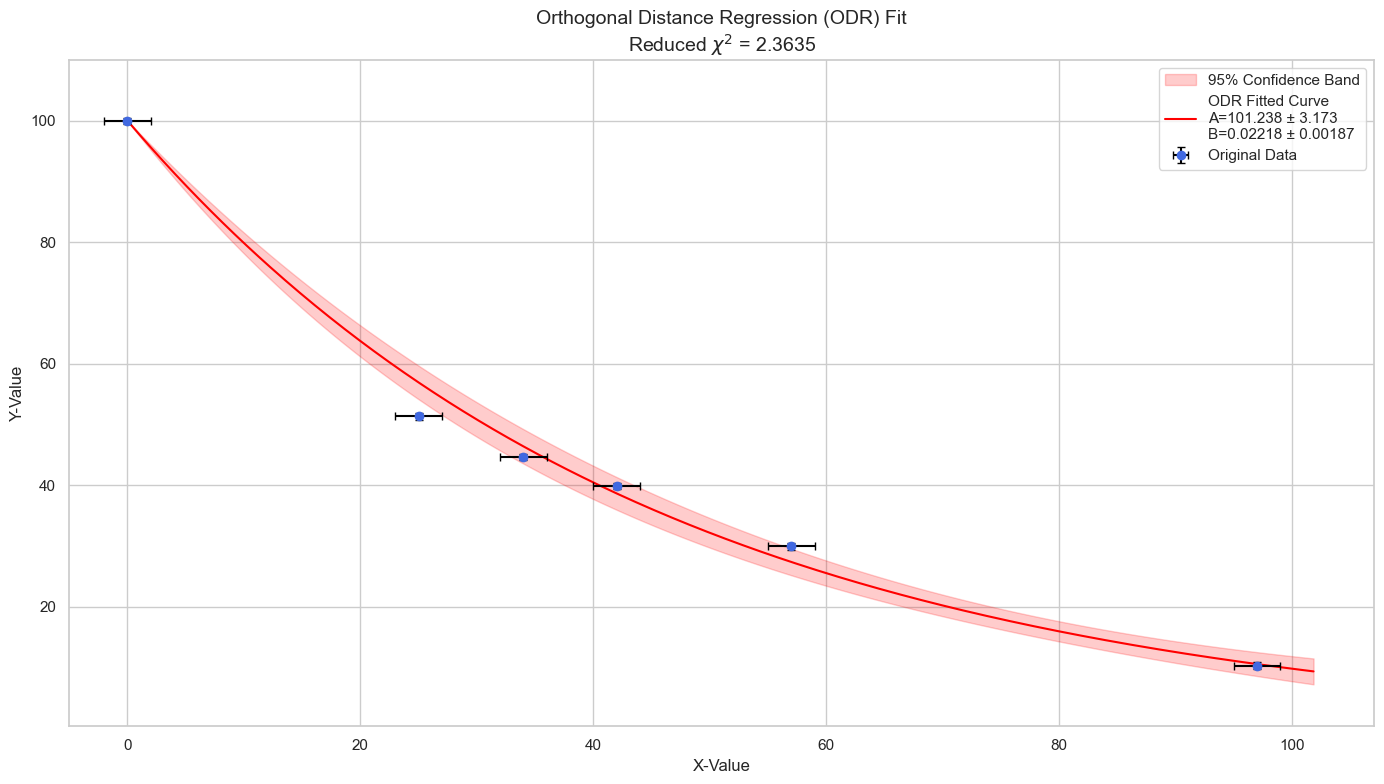

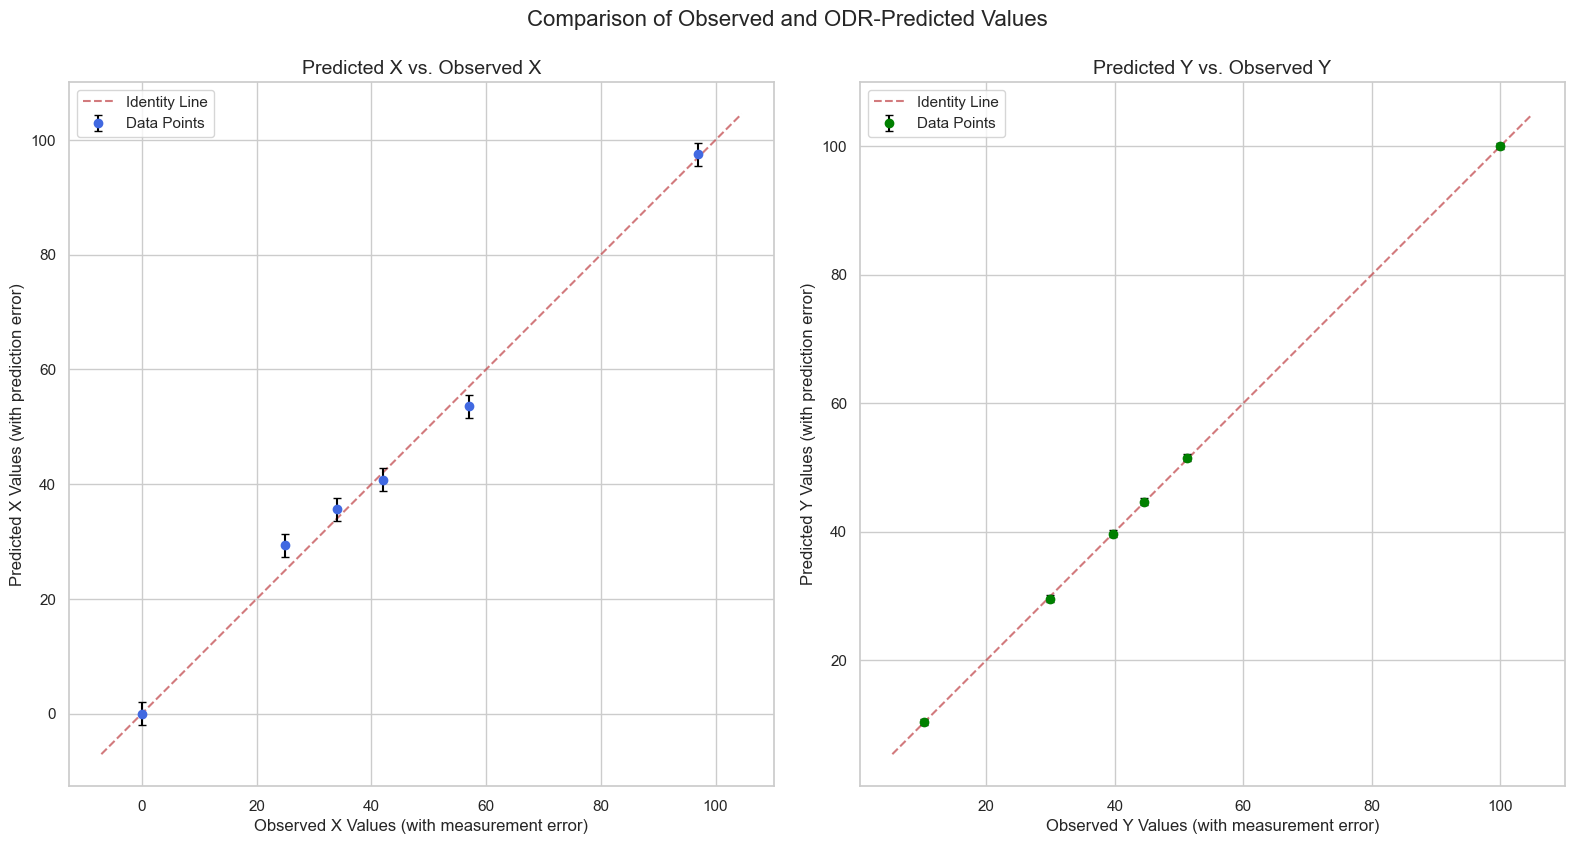

In [558]:
def model_function(beta, x):
    """
    The custom function to approximate the data.
    f(x; A, B) = A * (np.exp(-B * x) - 1) + 100
    Note: The signature is now (beta, x) for scipy.odr.
    """
    A, B = beta
    return A * (np.exp(-B * x) - 1) + 100

# Dataset 1
x = np.array([0, 25, 34, 42, 57, 97])
y_obs = np.array([100, 51.3, 44.6, 39.8, 29.9, 10.3])
sigma_y = np.full_like(y_obs, 0.5, dtype=float)
sigma_x = np.full_like(x, 2.0, dtype=float)
initial_guess = [50, 0.01]

# Analyze the curve fit and get results using ODR
odr_results = analyze_odr(x, y_obs, sigma_x, sigma_y, model_function, initial_guess)

# Print the metrics
print_metrics(odr_results)

# Draw the curve fit plot
draw_curve_fit(odr_results, model_function)

# Plot predicted vs observed values
plot_predicted_vs_observed(odr_results, show_errors=True)

This is an interesting result. Reduced $\chi^2$ is lower than before. Also, `A` value is greater than 100, which means that at some specific x-value, the function can reach zero y-value, which will be an important result for us.

Let's increase `sigma_x` from 2.0 to 3.0

--- ODR Fit Results ---
Beta: [1.01416469e+02 2.20950319e-02]
Beta Std Error: [2.98965533e+00 1.82309451e-03]
Beta Covariance: [[ 8.14786441e+00 -4.68628407e-03]
 [-4.68628407e-03  3.02984153e-06]]
Residual Variance: 1.0969793452965853
Inverse Condition #: 0.08953668330298414
Reason(s) for Halting:
  Sum of squares convergence

--- Summary of Results ---
Parameter A: 101.41647 +/- 2.98966
  T-value: 33.92246188, P-value: 0.00000450
Parameter B: 0.02210 +/- 0.00182
  T-value: 12.11952087, P-value: 0.00026592

--- Model Fit Statistics ---

Number of Observations (n): 6
Number of Parameters (p): 2
Degrees of Freedom (n-p): 4

--- Goodness-of-Fit & Error Metrics ---
Chi-Squared (from ODR): 4.3879
Reduced Chi-Squared (from ODR): 1.0970

--- Information Criteria ---
Maximum Log-Likelihood: -15.6540
AIC (Akaike Information Criterion): 35.3080
BIC (Bayesian Information Criterion): 34.8915
AICc (Corrected AIC): 39.3080

--- Comparison of Original and Predicted Data Points ---
  Original X    Pr

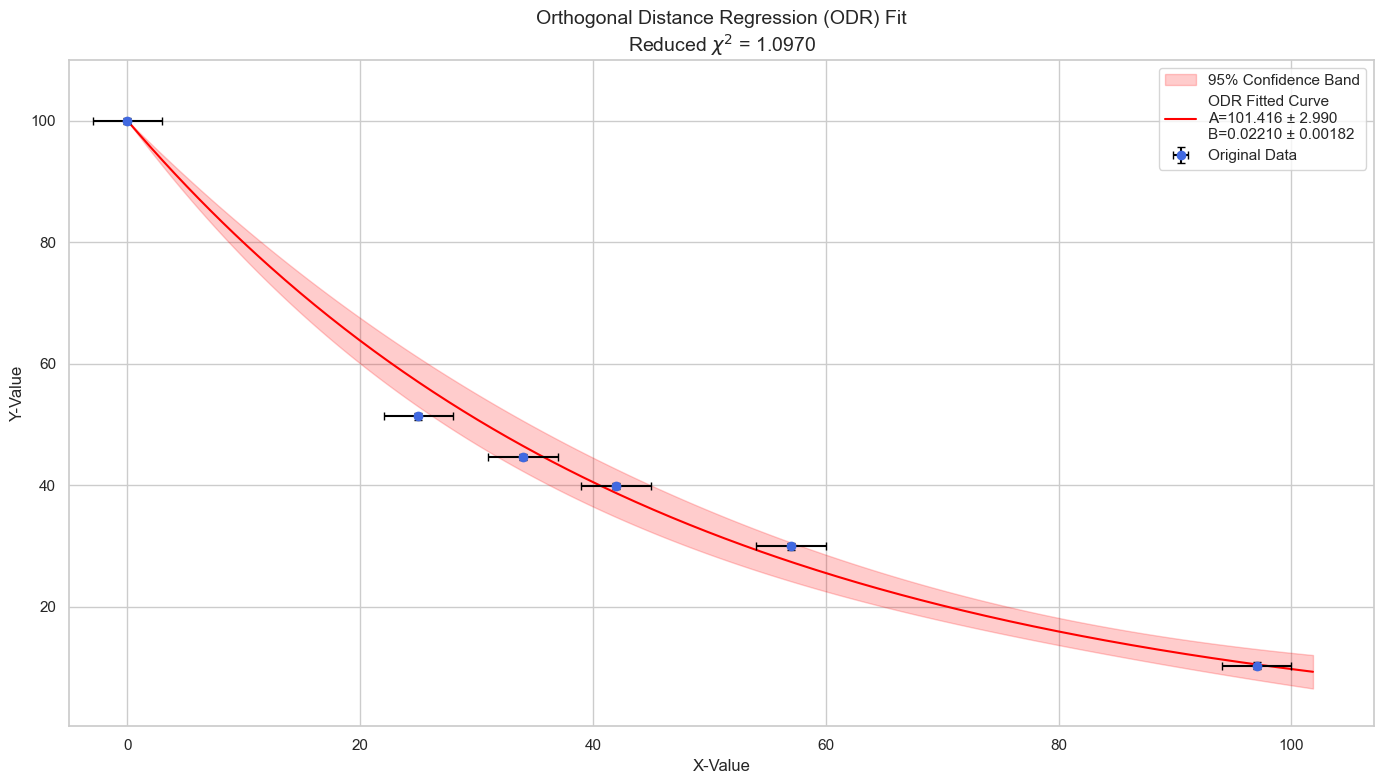

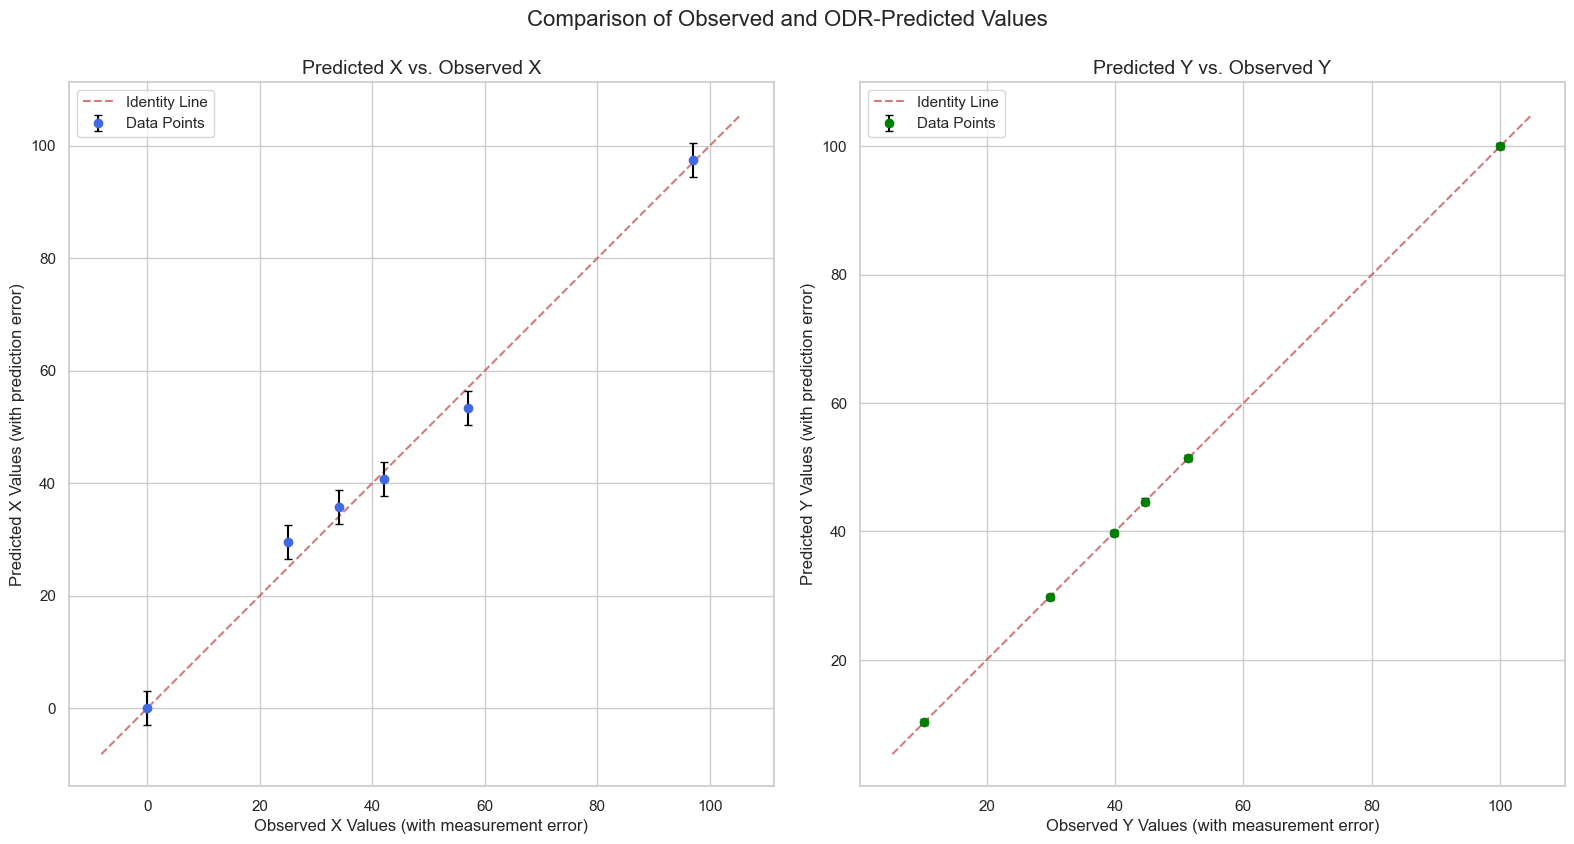

In [559]:
def model_function(beta, x):
    """
    The custom function to approximate the data.
    f(x; A, B) = A * (np.exp(-B * x) - 1) + 100
    Note: The signature is now (beta, x) for scipy.odr.
    """
    A, B = beta
    return A * (np.exp(-B * x) - 1) + 100

# Dataset 1
x = np.array([0, 25, 34, 42, 57, 97])
y_obs = np.array([100, 51.3, 44.6, 39.8, 29.9, 10.3])
sigma_y = np.full_like(y_obs, 0.5, dtype=float)
sigma_x = np.full_like(x, 3.0, dtype=float)
initial_guess = [50, 0.01]

# Analyze the curve fit and get results using ODR
odr_results = analyze_odr(x, y_obs, sigma_x, sigma_y, model_function, initial_guess)

# Print the metrics
print_metrics(odr_results)

# Draw the curve fit plot
draw_curve_fit(odr_results, model_function)

# Plot predicted vs observed values
plot_predicted_vs_observed(odr_results, show_errors=True)

This is also an interesting result. Reduced $\chi^2$ is lower and close to 1.0 which is very good. `A` value remains to be greater than 100, which means that at some specific x-value, the function can reach zero y-value, which will be an important result for us.

### Improved model function

Let's start from scratch and try to connect to the results from Dataset 3, so our function will be

$$f(x, A, B) = A_1 (\exp (-B_1 x) - 1) + A (\exp(-B x) - 1) + 100 $$

where A_1 and B_1 are defined from the ODR of Dataset 3 using a function $f(x, A, B) = A (\exp(-B x) - 1) + 100 $.

--- ODR Fit Results ---
Beta: [5.64837483e+01 3.34000206e-02]
Beta Std Error: [1.85220408 0.00404159]
Beta Covariance: [[ 1.37387692e+00 -2.48458954e-03]
 [-2.48458954e-03  6.54144342e-06]]
Residual Variance: 2.497064990325722
Inverse Condition #: 0.04982581594705908
Reason(s) for Halting:
  Sum of squares convergence

--- Summary of Results ---
Parameter A: 56.48375 +/- 1.85220
  T-value: 30.49542373, P-value: 0.00000071
Parameter B: 0.03340 +/- 0.00404
  T-value: 8.26408960, P-value: 0.00042316

--- Model Fit Statistics ---

Number of Observations (n): 7
Number of Parameters (p): 2
Degrees of Freedom (n-p): 5

--- Goodness-of-Fit & Error Metrics ---
Chi-Squared (from ODR): 12.4853
Reduced Chi-Squared (from ODR): 2.4971

--- Information Criteria ---
Maximum Log-Likelihood: -19.1078
AIC (Akaike Information Criterion): 42.2156
BIC (Bayesian Information Criterion): 42.1074
AICc (Corrected AIC): 45.2156

--- Comparison of Original and Predicted Data Points ---
  Original X    Predicted X 

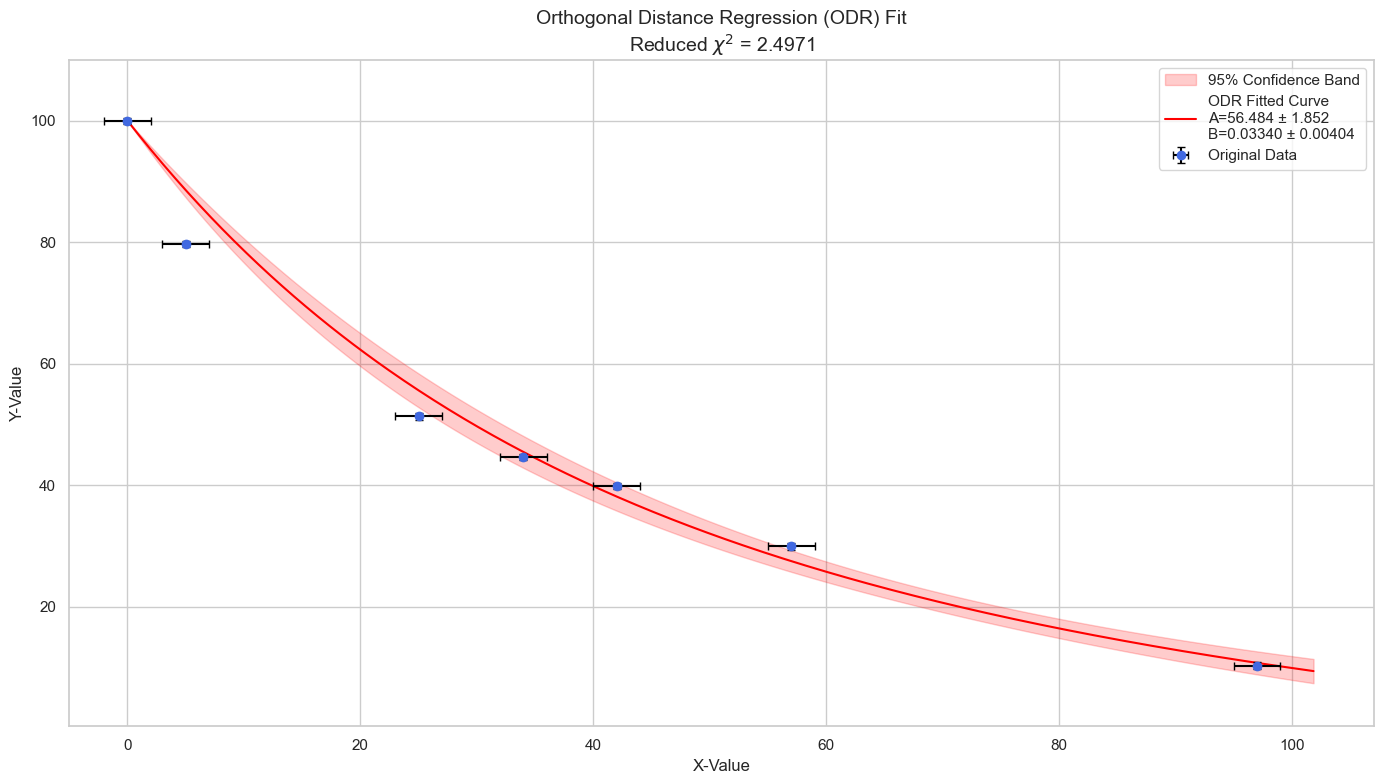

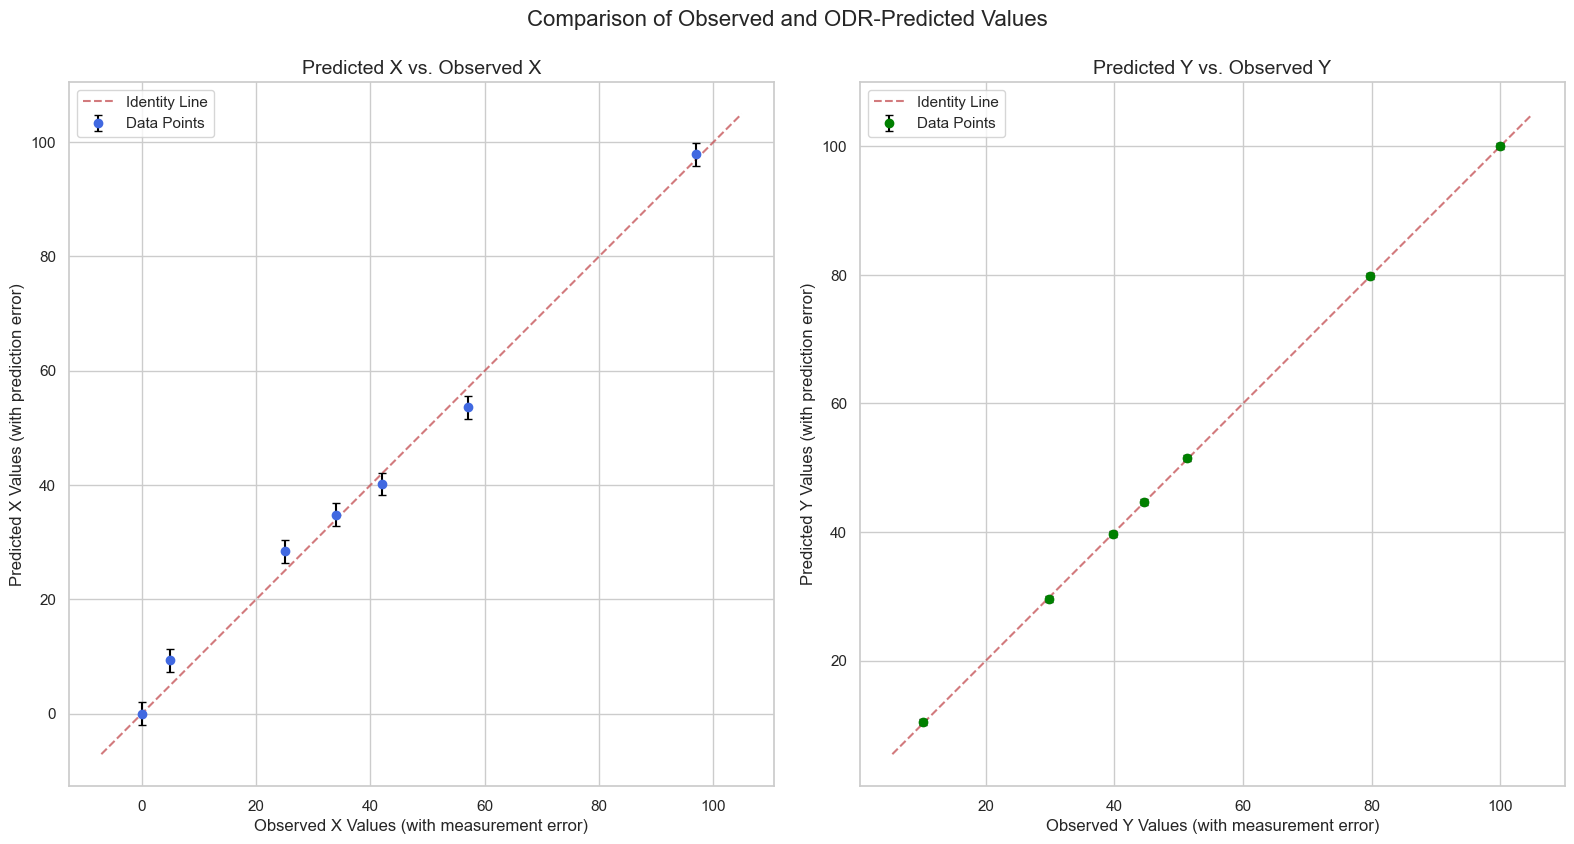

In [560]:
def model_function(beta, x):
    """
    The custom function to approximate the data.
    f(x, A, B) = A_1 * (np.exp(-B_1 * x) - 1) + A * (np.exp(-B * x) - 1) + 100
    Note: The signature is now (beta, x) for scipy.odr.
    """

    A_1 = 56.769 # obtained from Dataset 3 with sigma_x = 2.0, sigma_y = 0.5
    B_1 = 0.00988 # obtained from Dataset 3 with sigma_x = 2.0, sigma_y = 0.5

    # A_1 = 56.747 # obtained from Dataset 3 with sigma_x = 3.0, sigma_y = 0.5
    # B_1 = 0.00991 # obtained from Dataset 3 with sigma_x = 3.0, sigma_y = 0.5

    A, B = beta
    
    return A_1 * (np.exp(-B_1 * x) - 1) + A * (np.exp(-B * x) - 1) + 100

# Dataset 1
x = np.array([0, 5, 25, 34, 42, 57, 97])
y_obs = np.array([100, 79.7, 51.3, 44.6, 39.8, 29.9, 10.3])
sigma_y = np.full_like(y_obs, 0.5, dtype=float)
sigma_x = np.full_like(x, 2.0, dtype=float)
initial_guess = [50, 0.01]

# Analyze the curve fit and get results using ODR
odr_results = analyze_odr(x, y_obs, sigma_x, sigma_y, model_function, initial_guess)

# Print the metrics
print_metrics(odr_results)

# Draw the curve fit plot
draw_curve_fit(odr_results, model_function)

# Plot predicted vs observed values
plot_predicted_vs_observed(odr_results, show_errors=True)

After changing the model function, we obtained reduced $\chi^2$ value which is close to the case where we used previous model function and excluded second point as outlier.

Let's increase the value of `sigma_x` from 2.0 to 3.0.

--- ODR Fit Results ---
Beta: [5.66455646e+01 3.31064937e-02]
Beta Std Error: [1.70869523 0.00388607]
Beta Covariance: [[ 2.52930312e+00 -4.76804323e-03]
 [-4.76804323e-03  1.30825979e-05]]
Residual Variance: 1.1543256178977583
Inverse Condition #: 0.04785494385177525
Reason(s) for Halting:
  Sum of squares convergence

--- Summary of Results ---
Parameter A: 56.64556 +/- 1.70870
  T-value: 33.15135640, P-value: 0.00000047
Parameter B: 0.03311 +/- 0.00389
  T-value: 8.51926296, P-value: 0.00036663

--- Model Fit Statistics ---

Number of Observations (n): 7
Number of Parameters (p): 2
Degrees of Freedom (n-p): 5

--- Goodness-of-Fit & Error Metrics ---
Chi-Squared (from ODR): 5.7716
Reduced Chi-Squared (from ODR): 1.1543

--- Information Criteria ---
Maximum Log-Likelihood: -18.5892
AIC (Akaike Information Criterion): 41.1784
BIC (Bayesian Information Criterion): 41.0702
AICc (Corrected AIC): 44.1784

--- Comparison of Original and Predicted Data Points ---
  Original X    Predicted X 

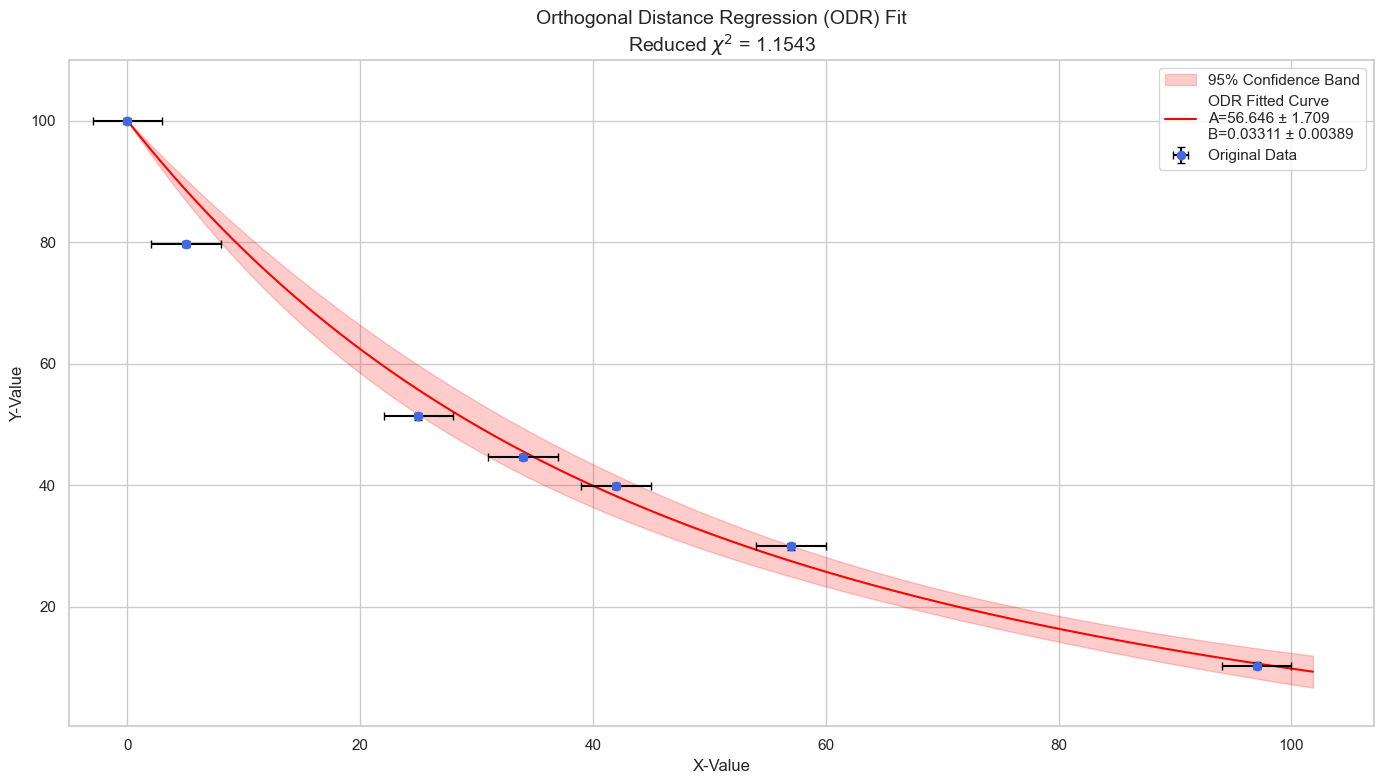

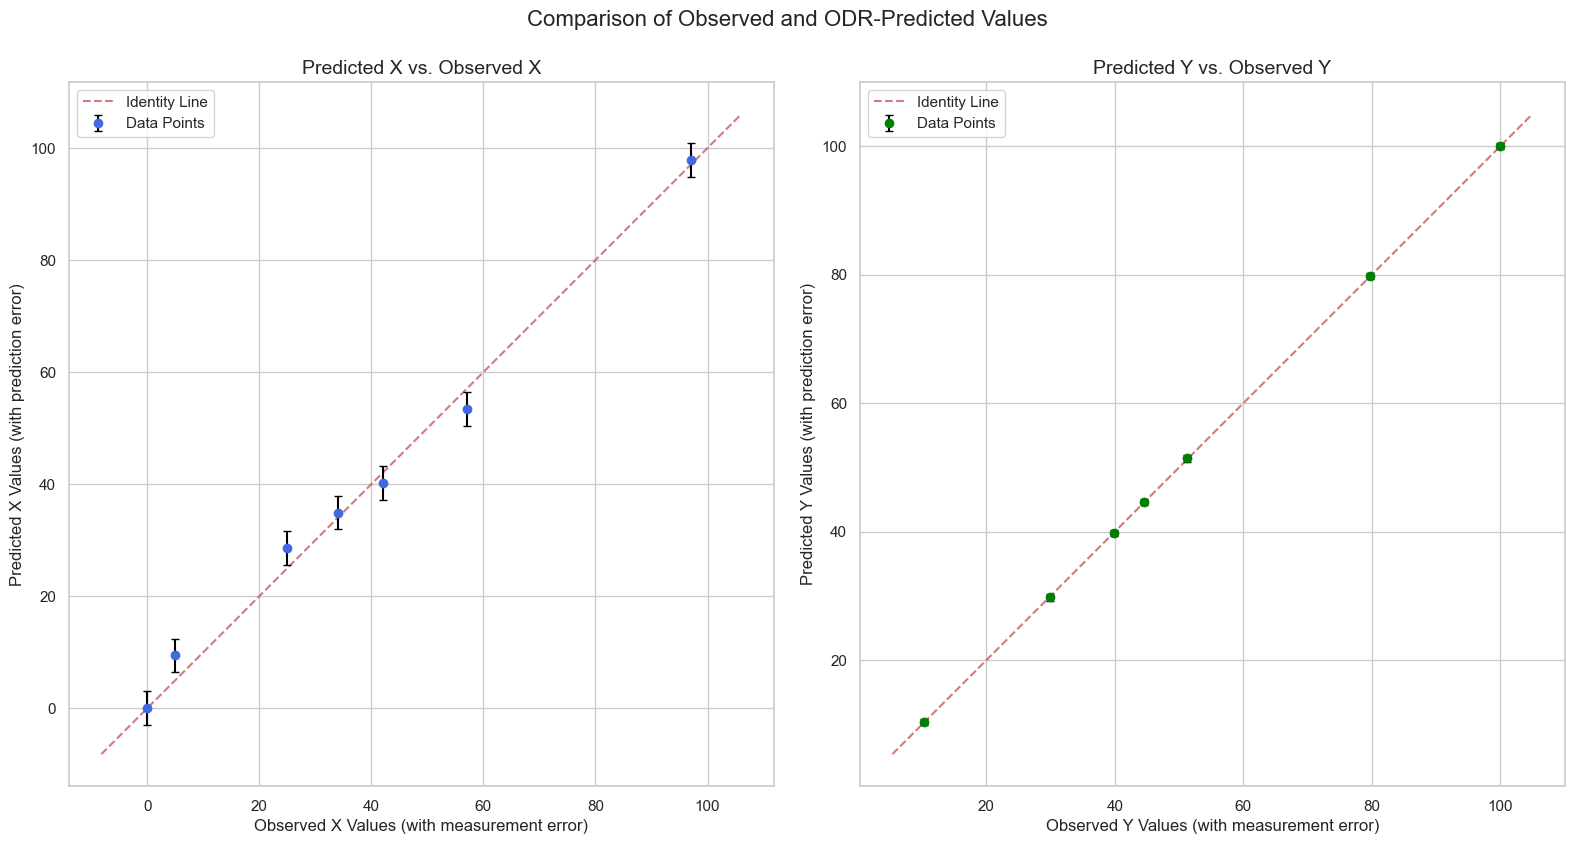

In [561]:
def model_function(beta, x):
    """
    The custom function to approximate the data.
    f(x, A, B) = A_1 * (np.exp(-B_1 * x) - 1) + A * (np.exp(-B * x) - 1) + 100
    Note: The signature is now (beta, x) for scipy.odr.
    """

    A_1 = 56.769 # obtained from Dataset 3 with sigma_x = 2.0, sigma_y = 0.5
    B_1 = 0.00988 # obtained from Dataset 3 with sigma_x = 2.0, sigma_y = 0.5

    # A_1 = 56.747 # obtained from Dataset 3 with sigma_x = 3.0, sigma_y = 0.5
    # B_1 = 0.00991 # obtained from Dataset 3 with sigma_x = 3.0, sigma_y = 0.5

    A, B = beta
    
    return A_1 * (np.exp(-B_1 * x) - 1) + A * (np.exp(-B * x) - 1) + 100

# Dataset 1
x = np.array([0, 5, 25, 34, 42, 57, 97])
y_obs = np.array([100, 79.7, 51.3, 44.6, 39.8, 29.9, 10.3])
sigma_y = np.full_like(y_obs, 0.5, dtype=float)
sigma_x = np.full_like(x, 3.0, dtype=float)
initial_guess = [50, 0.01]

# Analyze the curve fit and get results using ODR
odr_results = analyze_odr(x, y_obs, sigma_x, sigma_y, model_function, initial_guess)

# Print the metrics
print_metrics(odr_results)

# Draw the curve fit plot
draw_curve_fit(odr_results, model_function)

# Plot predicted vs observed values
plot_predicted_vs_observed(odr_results, show_errors=True)

Let's increase the value of `sigma_y` from 0.5 to 1.0 and test this with `sigma_x` = 2.0 and 3.0.

--- ODR Fit Results ---
Beta: [5.57800408e+01 3.47428213e-02]
Beta Std Error: [2.31846495 0.00469935]
Beta Covariance: [[ 2.58198910e+00 -4.39032812e-03]
 [-4.39032812e-03  1.06078745e-05]]
Residual Variance: 2.081836717937271
Inverse Condition #: 0.05193375915222127
Reason(s) for Halting:
  Sum of squares convergence

--- Summary of Results ---
Parameter A: 55.78004 +/- 2.31846
  T-value: 24.05903997, P-value: 0.00000231
Parameter B: 0.03474 +/- 0.00470
  T-value: 7.39311677, P-value: 0.00071218

--- Model Fit Statistics ---

Number of Observations (n): 7
Number of Parameters (p): 2
Degrees of Freedom (n-p): 5

--- Goodness-of-Fit & Error Metrics ---
Chi-Squared (from ODR): 10.4092
Reduced Chi-Squared (from ODR): 2.0818

--- Information Criteria ---
Maximum Log-Likelihood: -22.9218
AIC (Akaike Information Criterion): 49.8435
BIC (Bayesian Information Criterion): 49.7353
AICc (Corrected AIC): 52.8435

--- Comparison of Original and Predicted Data Points ---
  Original X    Predicted X 

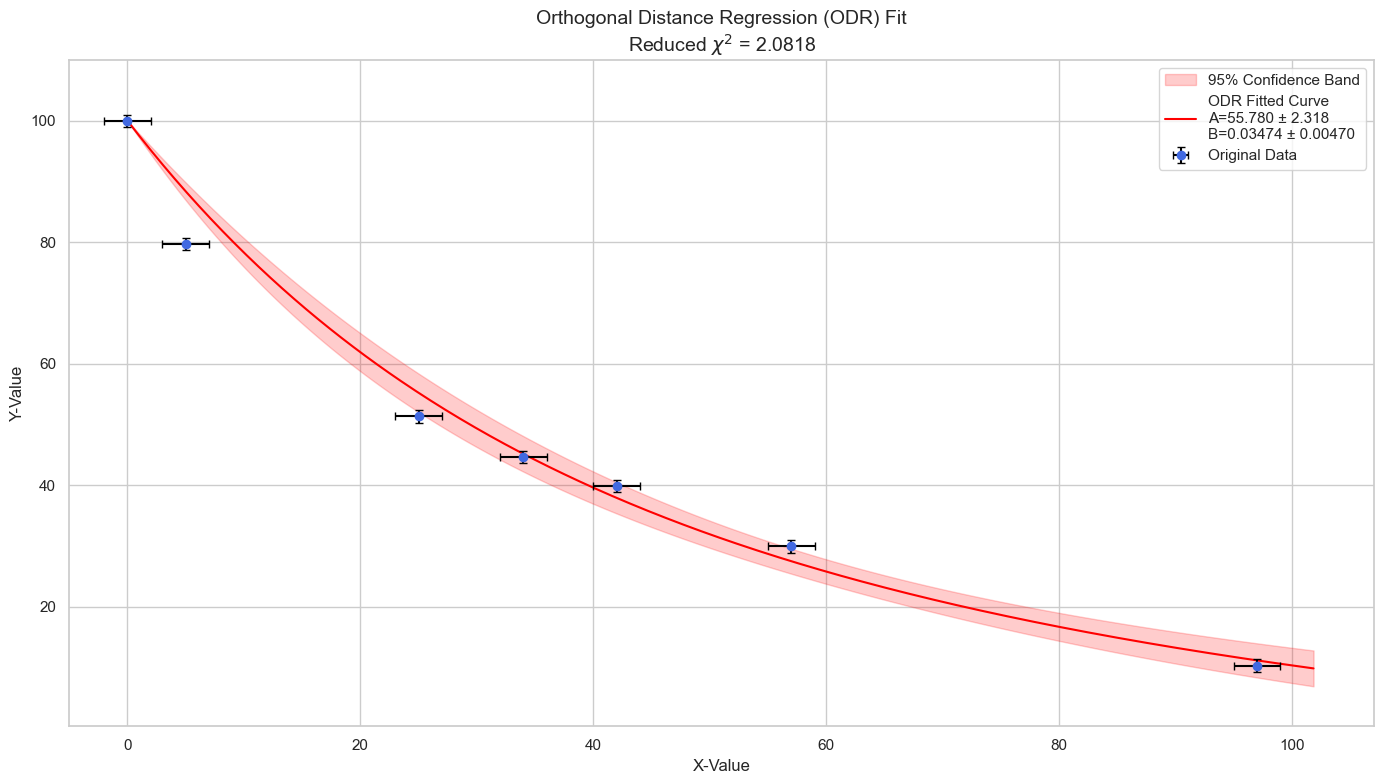

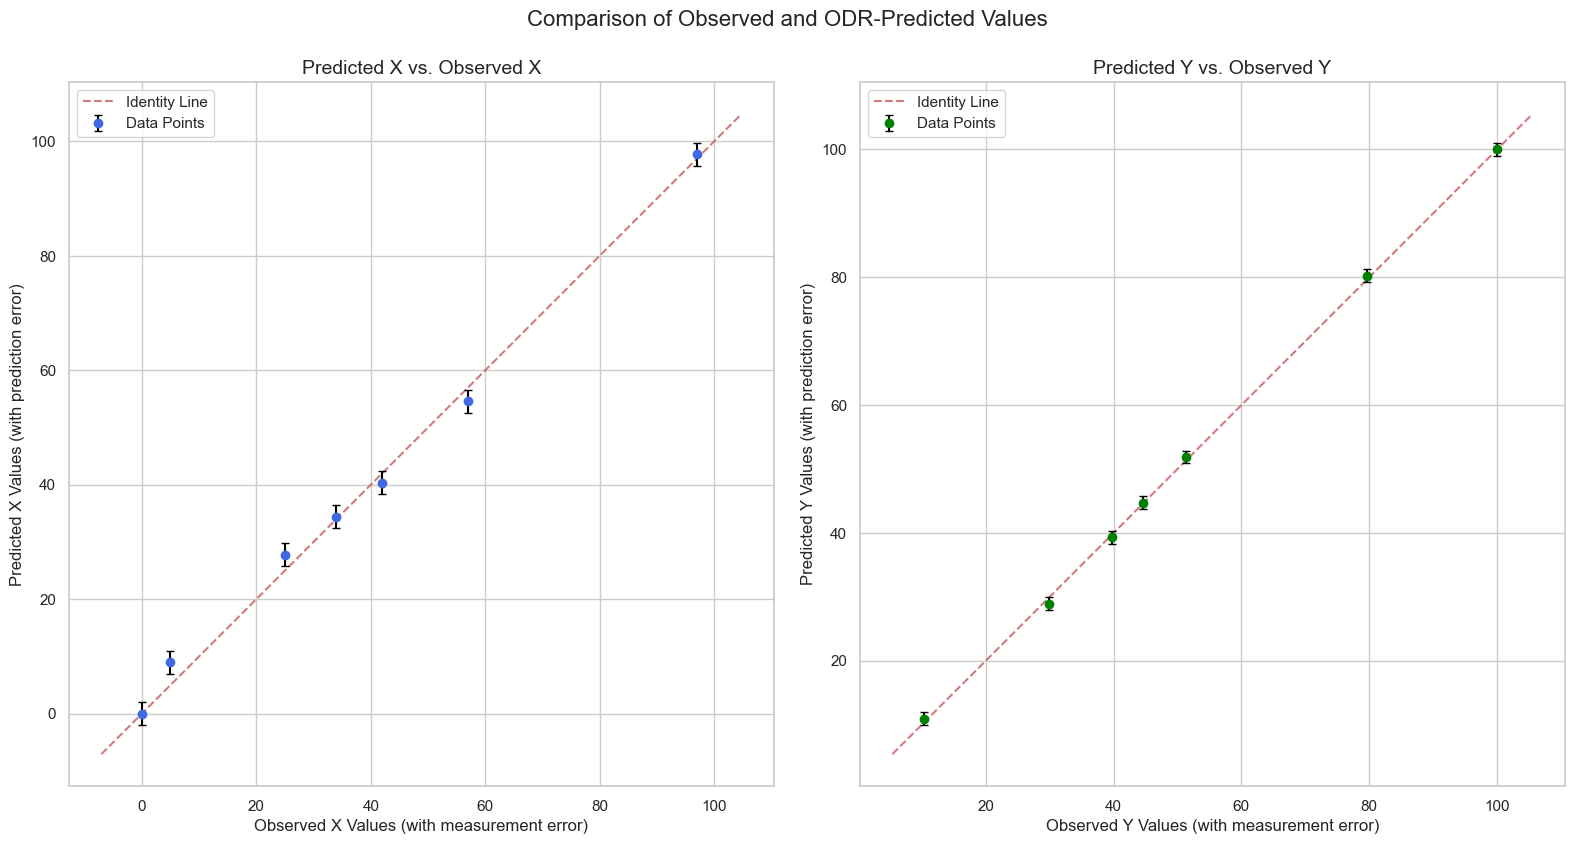

In [562]:
def model_function(beta, x):
    """
    The custom function to approximate the data.
    f(x, A, B) = A_1 * (np.exp(-B_1 * x) - 1) + A * (np.exp(-B * x) - 1) + 100
    Note: The signature is now (beta, x) for scipy.odr.
    """

    A_1 = 56.769 # obtained from Dataset 3 with sigma_x = 2.0, sigma_y = 0.5
    B_1 = 0.00988 # obtained from Dataset 3 with sigma_x = 2.0, sigma_y = 0.5

    # A_1 = 56.747 # obtained from Dataset 3 with sigma_x = 3.0, sigma_y = 0.5
    # B_1 = 0.00991 # obtained from Dataset 3 with sigma_x = 3.0, sigma_y = 0.5

    A, B = beta
    
    return A_1 * (np.exp(-B_1 * x) - 1) + A * (np.exp(-B * x) - 1) + 100

# Dataset 1
x = np.array([0, 5, 25, 34, 42, 57, 97])
y_obs = np.array([100, 79.7, 51.3, 44.6, 39.8, 29.9, 10.3])
sigma_y = np.full_like(y_obs, 1.0, dtype=float)
sigma_x = np.full_like(x, 2.0, dtype=float)
initial_guess = [50, 0.01]

# Analyze the curve fit and get results using ODR
odr_results = analyze_odr(x, y_obs, sigma_x, sigma_y, model_function, initial_guess)

# Print the metrics
print_metrics(odr_results)

# Draw the curve fit plot
draw_curve_fit(odr_results, model_function)

# Plot predicted vs observed values
plot_predicted_vs_observed(odr_results, show_errors=True)

--- ODR Fit Results ---
Beta: [5.62756354e+01 3.37856894e-02]
Beta Std Error: [2.01225938 0.00423834]
Beta Covariance: [[ 3.84235651e+00 -6.72589726e-03]
 [-6.72589726e-03  1.70459194e-05]]
Residual Variance: 1.0538292845024835
Inverse Condition #: 0.05122048290906237
Reason(s) for Halting:
  Sum of squares convergence

--- Summary of Results ---
Parameter A: 56.27564 +/- 2.01226
  T-value: 27.96639236, P-value: 0.00000109
Parameter B: 0.03379 +/- 0.00424
  T-value: 7.97145206, P-value: 0.00050124

--- Model Fit Statistics ---

Number of Observations (n): 7
Number of Parameters (p): 2
Degrees of Freedom (n-p): 5

--- Goodness-of-Fit & Error Metrics ---
Chi-Squared (from ODR): 5.2691
Reduced Chi-Squared (from ODR): 1.0538

--- Information Criteria ---
Maximum Log-Likelihood: -23.1900
AIC (Akaike Information Criterion): 50.3800
BIC (Bayesian Information Criterion): 50.2718
AICc (Corrected AIC): 53.3800

--- Comparison of Original and Predicted Data Points ---
  Original X    Predicted X 

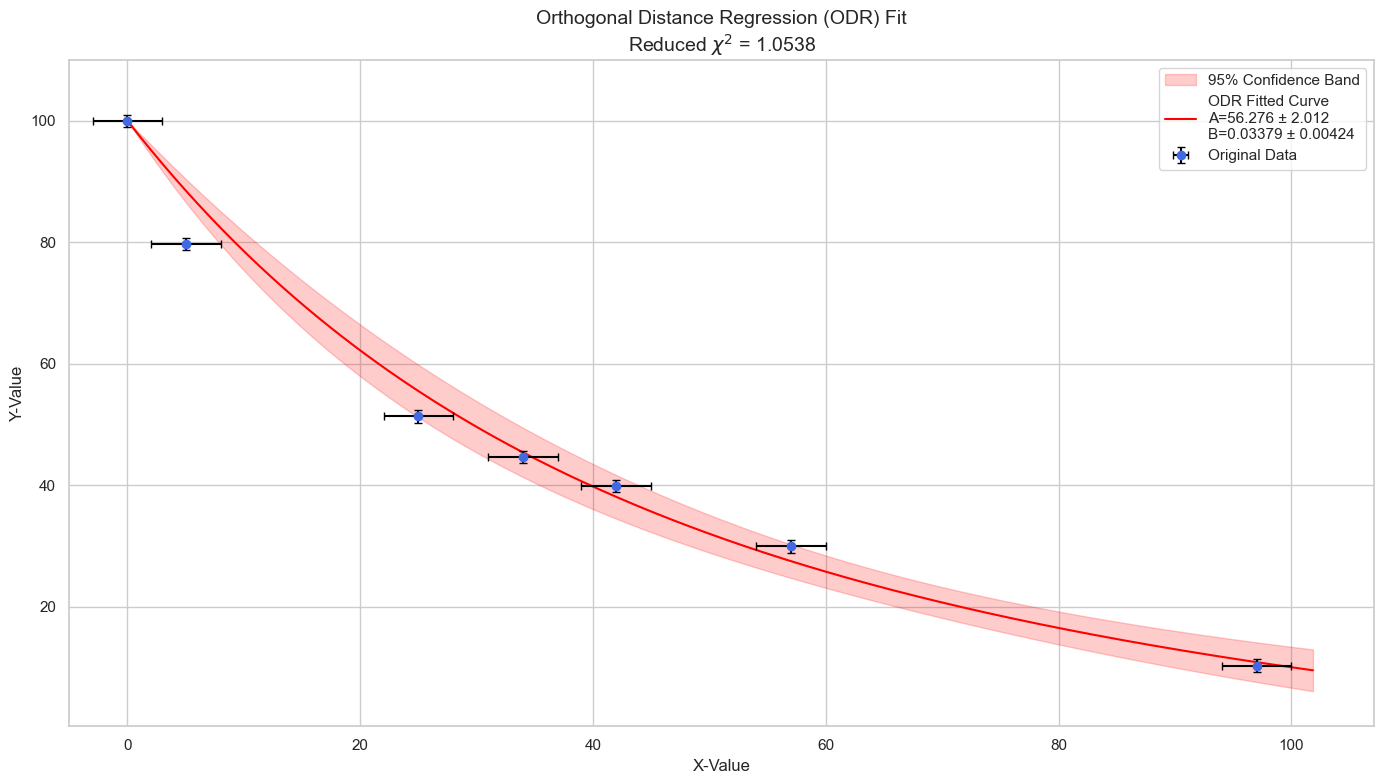

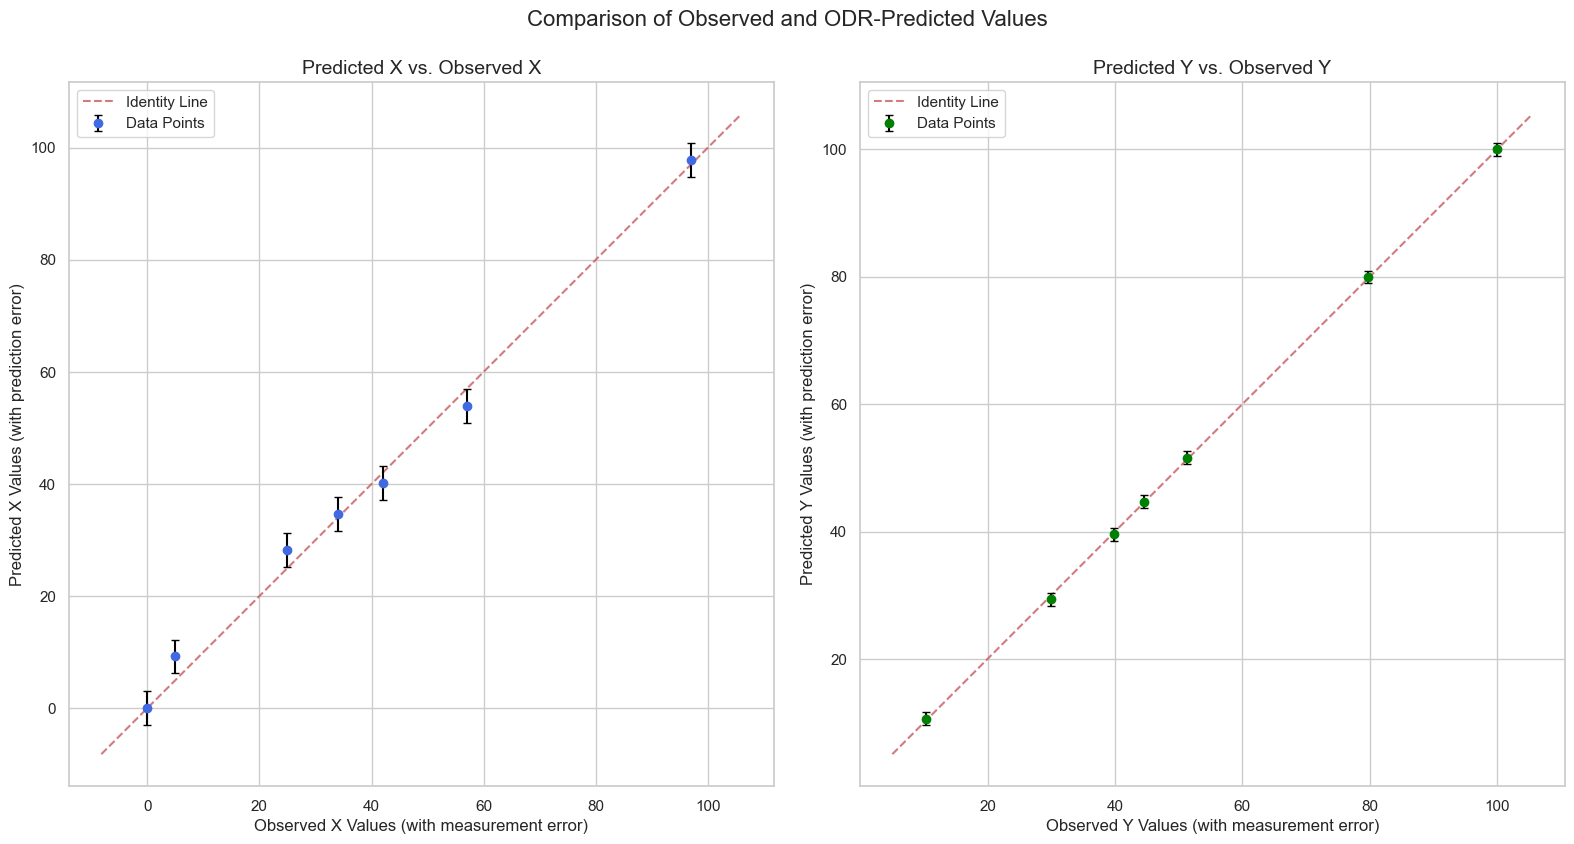

In [563]:
def model_function(beta, x):
    """
    The custom function to approximate the data.
    f(x, A, B) = A_1 * (np.exp(-B_1 * x) - 1) + A * (np.exp(-B * x) - 1) + 100
    Note: The signature is now (beta, x) for scipy.odr.
    """

    A_1 = 56.769 # obtained from Dataset 3 with sigma_x = 2.0, sigma_y = 0.5
    B_1 = 0.00988 # obtained from Dataset 3 with sigma_x = 2.0, sigma_y = 0.5

    # A_1 = 56.747 # obtained from Dataset 3 with sigma_x = 3.0, sigma_y = 0.5
    # B_1 = 0.00991 # obtained from Dataset 3 with sigma_x = 3.0, sigma_y = 0.5

    A, B = beta
    
    return A_1 * (np.exp(-B_1 * x) - 1) + A * (np.exp(-B * x) - 1) + 100

# Dataset 1
x = np.array([0, 5, 25, 34, 42, 57, 97])
y_obs = np.array([100, 79.7, 51.3, 44.6, 39.8, 29.9, 10.3])
sigma_y = np.full_like(y_obs, 1.0, dtype=float)
sigma_x = np.full_like(x, 3.0, dtype=float)
initial_guess = [50, 0.01]

# Analyze the curve fit and get results using ODR
odr_results = analyze_odr(x, y_obs, sigma_x, sigma_y, model_function, initial_guess)

# Print the metrics
print_metrics(odr_results)

# Draw the curve fit plot
draw_curve_fit(odr_results, model_function)

# Plot predicted vs observed values
plot_predicted_vs_observed(odr_results, show_errors=True)

Reduced $\chi^2$ is close to 1 which is pretty good.

Let's exclude the second point from the dataset as outlier and validate the results with `sigma_x` = 2.0 and 3.0 with `sigma_y` = 0.5.

In [ ]:
def model_function(beta, x):
    """
    The custom function to approximate the data.
    f(x, A, B) = A_1 * (np.exp(-B_1 * x) - 1) + A * (np.exp(-B * x) - 1) + 100
    Note: The signature is now (beta, x) for scipy.odr.
    """

    A_1 = 56.769 # obtained from Dataset 3 with sigma_x = 2.0, sigma_y = 0.5
    B_1 = 0.00988 # obtained from Dataset 3 with sigma_x = 2.0, sigma_y = 0.5

    # A_1 = 56.747 # obtained from Dataset 3 with sigma_x = 3.0, sigma_y = 0.5
    # B_1 = 0.00991 # obtained from Dataset 3 with sigma_x = 3.0, sigma_y = 0.5

    A, B = beta
    
    return A_1 * (np.exp(-B_1 * x) - 1) + A * (np.exp(-B * x) - 1) + 100

# Dataset 1
x = np.array([0, 25, 34, 42, 57, 97])
y_obs = np.array([100, 51.3, 44.6, 39.8, 29.9, 10.3])
sigma_y = np.full_like(y_obs, 0.5, dtype=float)
sigma_x = np.full_like(x, 2.0, dtype=float)
initial_guess = [50, 0.01]

# Analyze the curve fit and get results using ODR
odr_results = analyze_odr(x, y_obs, sigma_x, sigma_y, model_function, initial_guess)

# Print the metrics
print_metrics(odr_results)

# Draw the curve fit plot
draw_curve_fit(odr_results, model_function)

# Plot predicted vs observed values
plot_predicted_vs_observed(odr_results, show_errors=True)

--- ODR Fit Results ---
Beta: [5.69770308e+01 3.20851523e-02]
Beta Std Error: [1.58710399 0.00338037]
Beta Covariance: [[ 2.88367706e+00 -5.19099807e-03]
 [-5.19099807e-03  1.30817316e-05]]
Residual Variance: 0.8735024809232925
Inverse Condition #: 0.04855655628987679
Reason(s) for Halting:
  Sum of squares convergence

--- Summary of Results ---
Parameter A: 56.97703 +/- 1.58710
  T-value: 35.89999855, P-value: 0.00000359
Parameter B: 0.03209 +/- 0.00338
  T-value: 9.49159977, P-value: 0.00068758

--- Model Fit Statistics ---

Number of Observations (n): 6
Number of Parameters (p): 2
Degrees of Freedom (n-p): 4

--- Goodness-of-Fit & Error Metrics ---
Chi-Squared (from ODR): 3.4940
Reduced Chi-Squared (from ODR): 0.8735

--- Information Criteria ---
Maximum Log-Likelihood: -15.2071
AIC (Akaike Information Criterion): 34.4141
BIC (Bayesian Information Criterion): 33.9976
AICc (Corrected AIC): 38.4141

--- Comparison of Original and Predicted Data Points ---
  Original X    Predicted X 

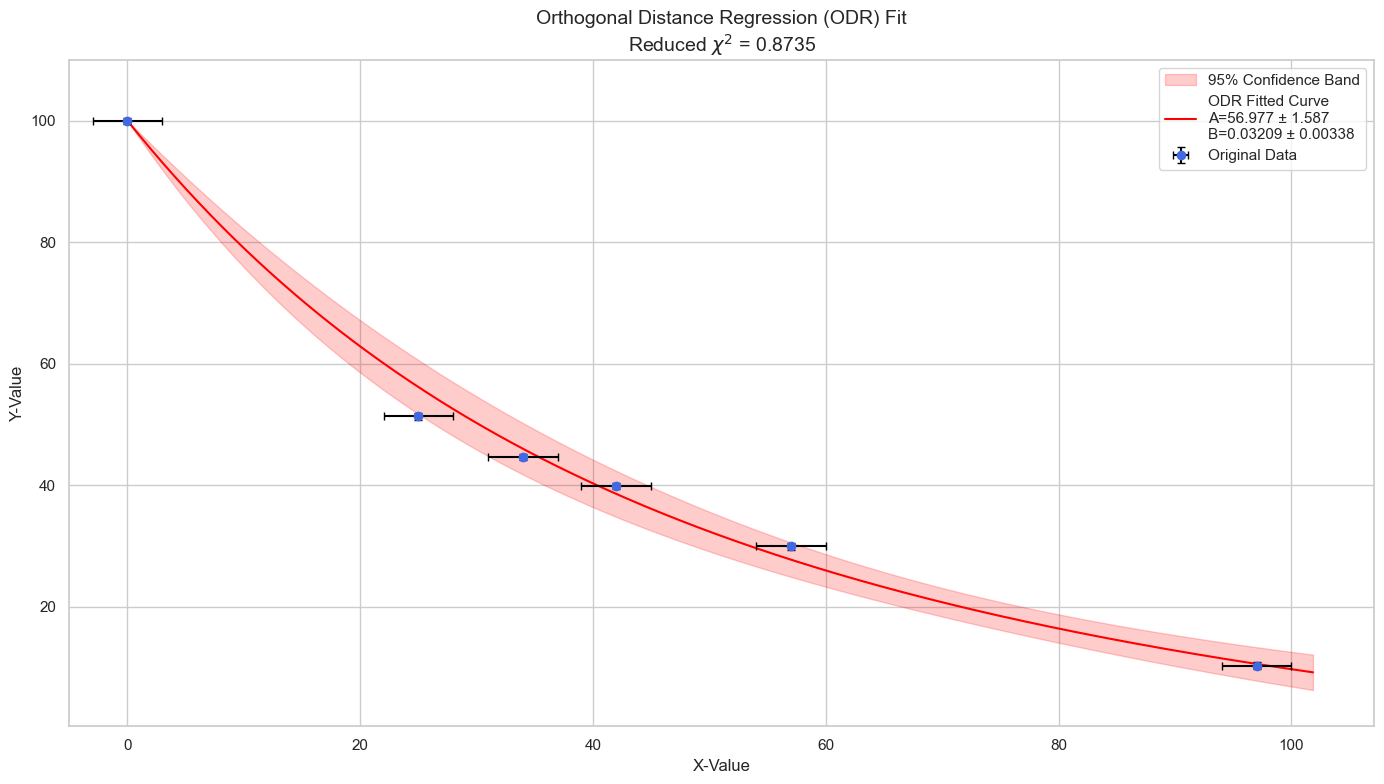

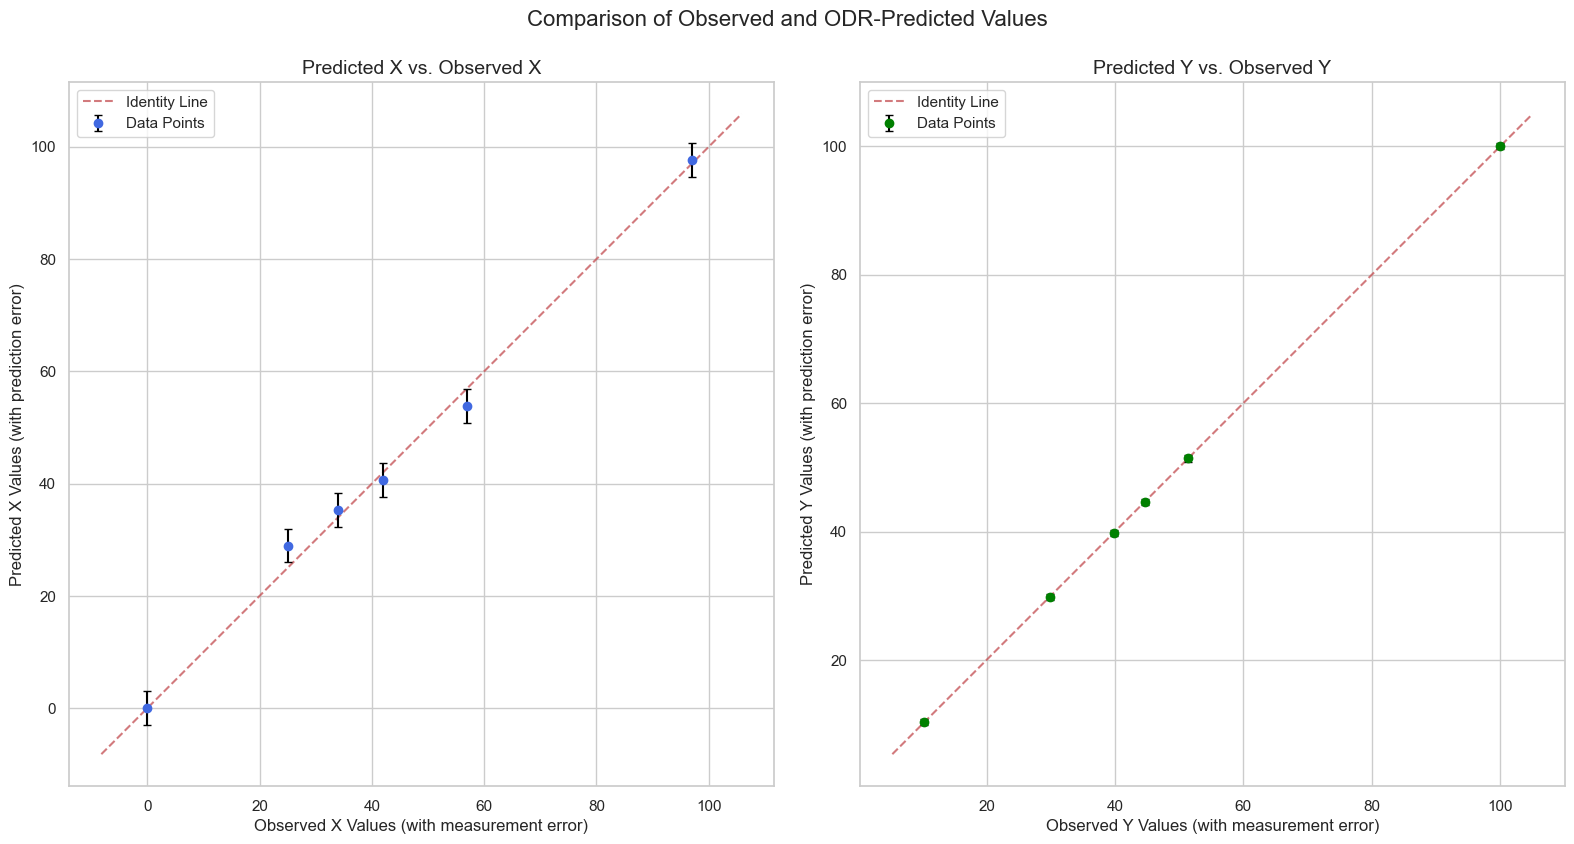

In [ ]:
def model_function(beta, x):
    """
    The custom function to approximate the data.
    f(x, A, B) = A_1 * (np.exp(-B_1 * x) - 1) + A * (np.exp(-B * x) - 1) + 100
    Note: The signature is now (beta, x) for scipy.odr.
    """

    A_1 = 56.769 # obtained from Dataset 3 with sigma_x = 2.0, sigma_y = 0.5
    B_1 = 0.00988 # obtained from Dataset 3 with sigma_x = 2.0, sigma_y = 0.5

    # A_1 = 56.747 # obtained from Dataset 3 with sigma_x = 3.0, sigma_y = 0.5
    # B_1 = 0.00991 # obtained from Dataset 3 with sigma_x = 3.0, sigma_y = 0.5

    A, B = beta
    
    return A_1 * (np.exp(-B_1 * x) - 1) + A * (np.exp(-B * x) - 1) + 100

# Dataset 1
x = np.array([0, 25, 34, 42, 57, 97])
y_obs = np.array([100, 51.3, 44.6, 39.8, 29.9, 10.3])
sigma_y = np.full_like(y_obs, 0.5, dtype=float)
sigma_x = np.full_like(x, 3.0, dtype=float)
initial_guess = [50, 0.01]

# Analyze the curve fit and get results using ODR
odr_results = analyze_odr(x, y_obs, sigma_x, sigma_y, model_function, initial_guess)

# Print the metrics
print_metrics(odr_results)

# Draw the curve fit plot
draw_curve_fit(odr_results, model_function)

# Plot predicted vs observed values
plot_predicted_vs_observed(odr_results, show_errors=True)

### More than 2 parameters in the non-linear model

In [ ]:
def draw_curve_fit_simple(results, model_function):
    """
    Visualizes the ODR fit with a 95% confidence band.

    Args:
        results (dict): The dictionary returned by the analyze_odr function.
        model_function (callable): The model function used for the fit.
    """
    # --- 1. Unpack data from the results dictionary ---
    x_data = results["original_x"]
    y_data = results["original_y"]
    sigma_x = results["original_sigma_x"]
    sigma_y = results["original_sigma_y"]
    popt = results['fit_params']
    perr = results['std_errs']
    
    # --- 2. Set up the plot ---
    plt.figure(figsize=(14, 8))
    sns.set_theme(style="whitegrid")

    # --- 3. Plot the curve fit ---
    
    # Plot original data with error bars
    plt.errorbar(
        x_data, y_data, 
        xerr=sigma_x, yerr=sigma_y, 
        fmt='o', color='royalblue', ecolor='black', capsize=3,
        label="Original Data", zorder=5
    )

    # Generate points for the fitted curve and confidence band
    x_plot = np.linspace(min(x_data), max(x_data) * 1.05, 400)
    y_plot = model_function(popt, x_plot)

    # Plot the fitted curve
    label_text = (
        f"ODR Fitted Curve\n"
        f"$A_1$={popt[0]:.5f} ± {perr[0]:.5f}\n"
        f"A={popt[1]:.5f} ± {perr[1]:.5f}\n"
        f"B={popt[2]:.5f} ± {perr[2]:.5f}"
    )
    plt.plot(x_plot, y_plot, color='red', label=label_text)

    # --- 5. Configure title, labels, and final layout ---
    title = f"Orthogonal Distance Regression (ODR) Fit\nReduced $\\chi^2$ = {results['reduced_chi_squared_odr']:.4f}"
    plt.title(title, fontsize=14)
    plt.xlabel("X-Value")
    plt.ylabel("Y-Value")
    plt.legend()
    plt.grid(True)
    
    plt.xlim(xmin=min(x_data) - 5)
    plt.ylim(ymin=min(y_data) - 10, ymax=max(y_data) + 10)
    
    plt.tight_layout()
    plt.show()

--- ODR Fit Results ---
Beta: [103.88824637  25.55010799   0.19522905]
Beta Std Error: [1.24956011 0.59488983 0.03870533]
Beta Covariance: [[ 1.65731942e+01 -7.51580025e+00  1.67335878e-01]
 [-7.51580025e+00  3.75634090e+00 -8.96855502e-02]
 [ 1.67335878e-01 -8.96855502e-02  1.59013315e-02]]
Residual Variance: 0.09421240332040559
Inverse Condition #: 0.0009228447241251511
Reason(s) for Halting:
  Sum of squares convergence

--- Summary of Results ---
Parameter A: 103.88825 +/- 1.24956
  T-value: 83.13985531, P-value: 0.00000013
Parameter B: 25.55011 +/- 0.59489
  T-value: 42.94931078, P-value: 0.00000176
Parameter C: 0.19523 +/- 0.03871
  T-value: 5.04398357, P-value: 0.00726171

--- Model Fit Statistics ---

Number of Observations (n): 7
Number of Parameters (p): 3
Degrees of Freedom (n-p): 4

--- Goodness-of-Fit & Error Metrics ---
Chi-Squared (from ODR): 0.3768
Reduced Chi-Squared (from ODR): 0.0942

--- Information Criteria ---
Maximum Log-Likelihood: -13.0536
AIC (Akaike Informati

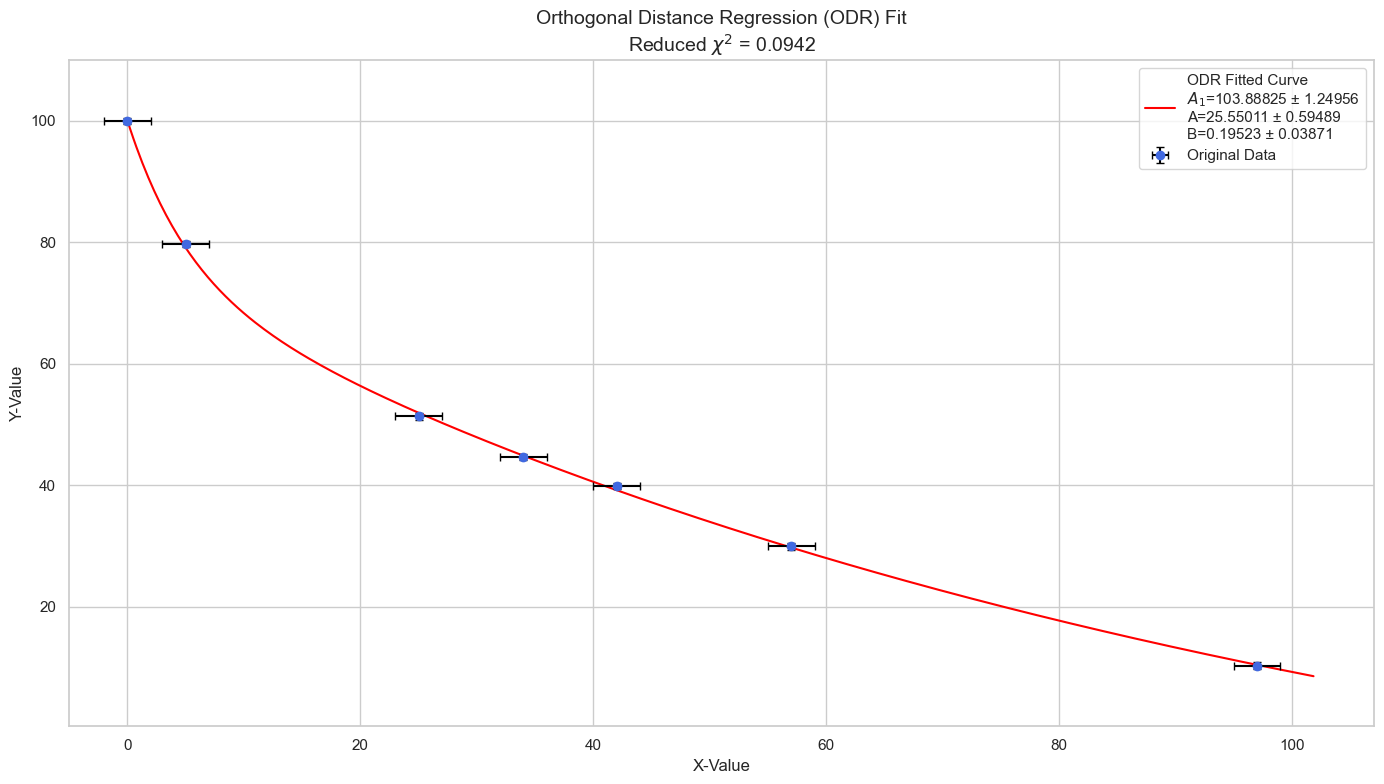

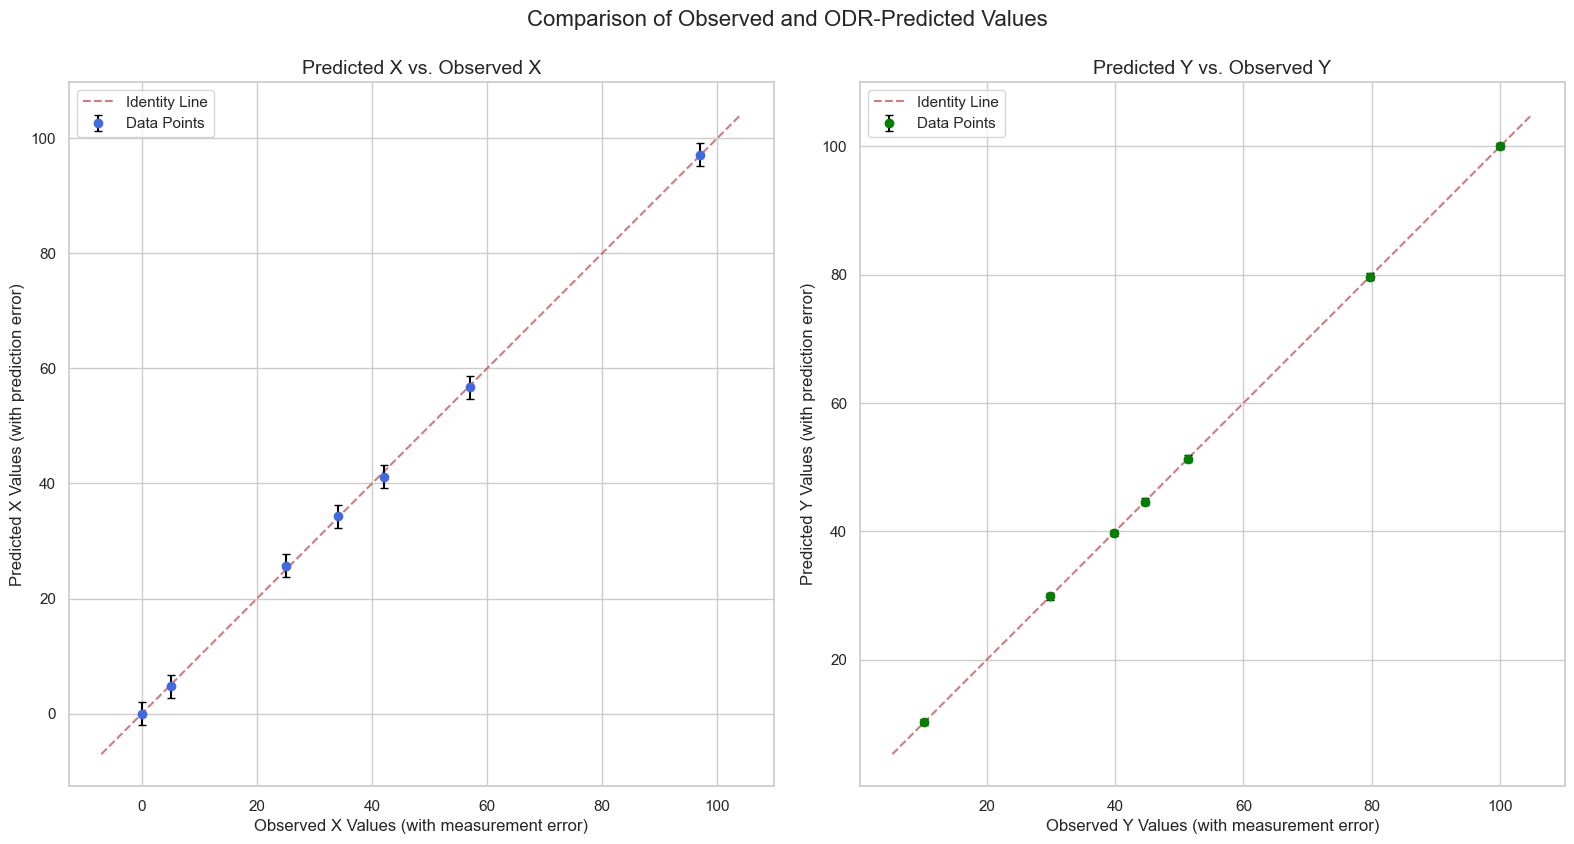

In [ ]:
def model_function(beta, x):
    """
    The custom function to approximate the data.
    f(x; A, B) = A * (np.exp(-B * x) - 1) + 100
    Note: The signature is now (beta, x) for scipy.odr.
    """

    # A_1 = 56.769 # obtained from Dataset 3 with sigma_x = 2.0, sigma_y = 0.5
    B_1 = 0.00988 # obtained from Dataset 3 with sigma_x = 2.0, sigma_y = 0.5

    # A_1 = 56.747 # obtained from Dataset 3 with sigma_x = 3.0, sigma_y = 0.5
    # B_1 = 0.00991 # obtained from Dataset 3 with sigma_x = 3.0, sigma_y = 0.5

    A_1, A, B = beta
    
    return A_1 * (np.exp(-B_1 * x) - 1) + A * (np.exp(-B * x) - 1) + 100

# Dataset 1
x = np.array([0, 5, 25, 34, 42, 57, 97])
y_obs = np.array([100, 79.7, 51.3, 44.6, 39.8, 29.9, 10.3])
sigma_y = np.full_like(y_obs, 0.5, dtype=float)
sigma_x = np.full_like(x, 2.0, dtype=float)
initial_guess = [56.769, 50, 0.01]

# Analyze the curve fit and get results using ODR
odr_results = analyze_odr(x, y_obs, sigma_x, sigma_y, model_function, initial_guess)

# Print the metrics
print_metrics(odr_results)

# Draw the curve fit plot
draw_curve_fit_simple(odr_results, model_function)

# Plot predicted vs observed values
plot_predicted_vs_observed(odr_results, show_errors=True)

## Usage of Methods. Dataset 2

--- ODR Fit Results ---
Beta: [7.95124870e+01 8.64914311e-03]
Beta Std Error: [4.26174841e+00 1.51681192e-03]
Beta Covariance: [[ 3.55227784e-01 -1.06585631e-04]
 [-1.06585631e-04  4.49981620e-08]]
Residual Variance: 51.1291636600781
Inverse Condition #: 0.2371672057368133
Reason(s) for Halting:
  Sum of squares convergence

--- Summary of Results ---
Parameter A: 79.51249 +/- 4.26175
  T-value: 18.65724565, P-value: 0.00000814
Parameter B: 0.00865 +/- 0.00152
  T-value: 5.70218563, P-value: 0.00231566

--- Model Fit Statistics ---

Number of Observations (n): 7
Number of Parameters (p): 2
Degrees of Freedom (n-p): 5

--- Goodness-of-Fit & Error Metrics ---
Chi-Squared (from ODR): 255.6458
Reduced Chi-Squared (from ODR): 51.1292

--- Information Criteria ---
Maximum Log-Likelihood: -140.6880
AIC (Akaike Information Criterion): 285.3761
BIC (Bayesian Information Criterion): 285.2679
AICc (Corrected AIC): 288.3761

--- Comparison of Original and Predicted Data Points ---
  Original X    

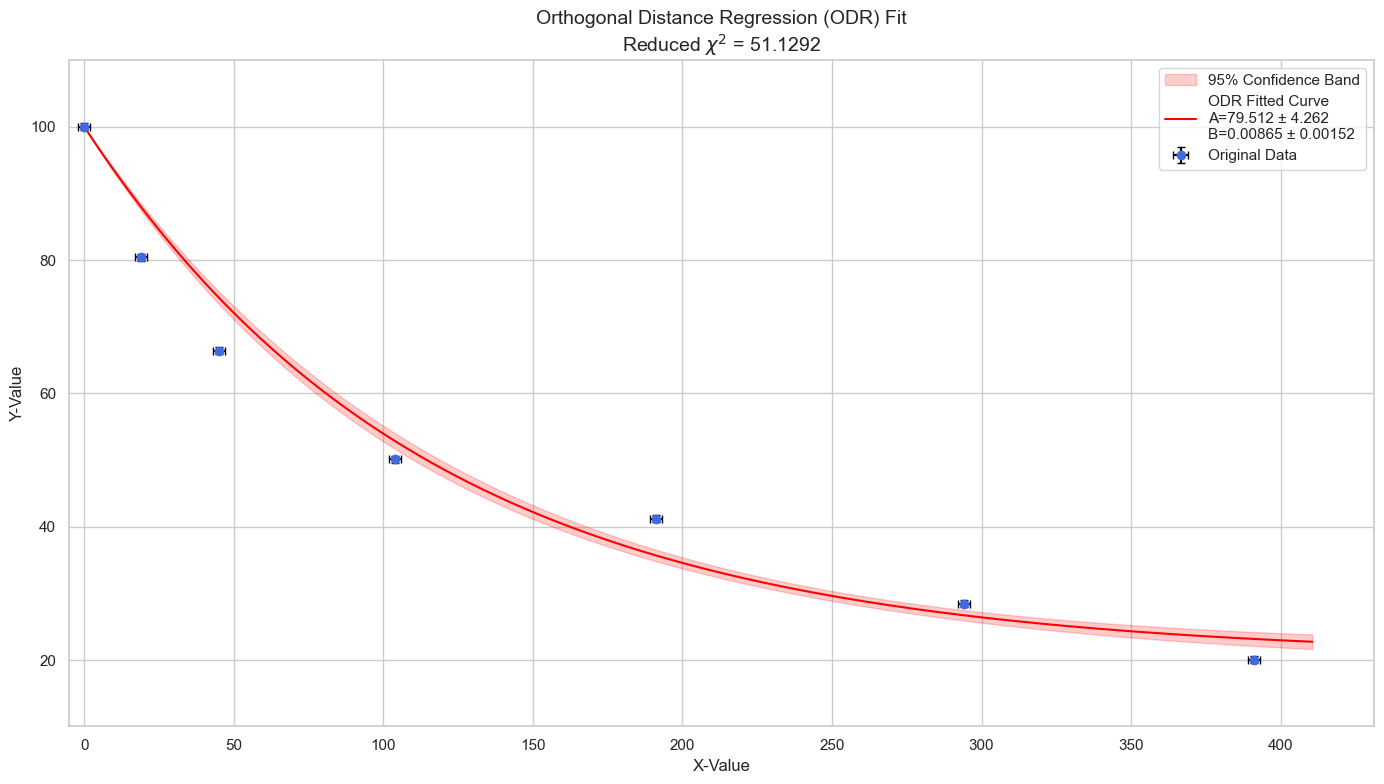

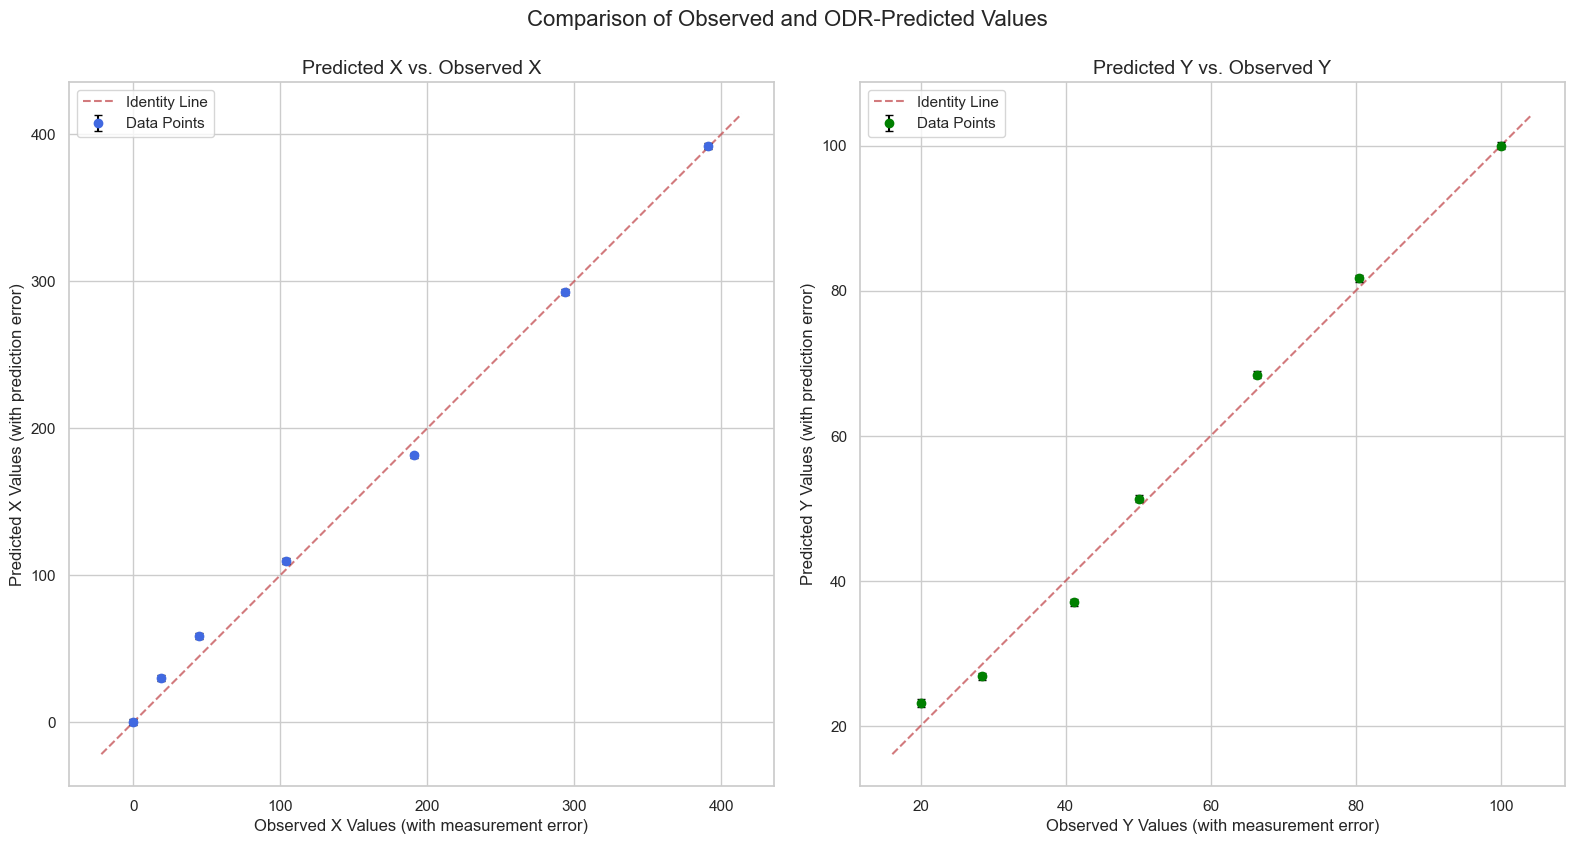

In [ ]:
def model_function(beta, x):
    """
    The custom function to approximate the data.
    f(x; A, B) = A * (np.exp(-B * x) - 1) + 100
    Note: The signature is now (beta, x) for scipy.odr.
    """
    A, B = beta
    return A * (np.exp(-B * x) - 1) + 100

# Dataset 2
x = np.array([0, 19, 45, 104, 191, 294, 391])
y_obs = np.array([100, 80.4, 66.4, 50.1, 41.2, 28.5, 20.1])
sigma_y = np.full_like(y_obs, 0.5, dtype=float)
sigma_x = np.full_like(x, 2.0, dtype=float)
initial_guess = [50, 0.01]

# Analyze the curve fit and get results using ODR
odr_results = analyze_odr(x, y_obs, sigma_x, sigma_y, model_function, initial_guess)

# Print the metrics
print_metrics(odr_results)

# Draw the curve fit plot
draw_curve_fit(odr_results, model_function)

# Plot predicted vs observed values
plot_predicted_vs_observed(odr_results, show_errors=True)

Let's change `sigma_x` to 3.0.

--- ODR Fit Results ---
Beta: [8.12148883e+01 7.99130328e-03]
Beta Std Error: [4.12285499e+00 1.35133333e-03]
Beta Covariance: [[ 4.98607625e-01 -1.41854982e-04]
 [-1.41854982e-04  5.35658219e-08]]
Residual Variance: 34.090800993631014
Inverse Condition #: 0.22835848075085202
Reason(s) for Halting:
  Sum of squares convergence

--- Summary of Results ---
Parameter A: 81.21489 +/- 4.12285
  T-value: 19.69870111, P-value: 0.00000623
Parameter B: 0.00799 +/- 0.00135
  T-value: 5.91364328, P-value: 0.00196969

--- Model Fit Statistics ---

Number of Observations (n): 7
Number of Parameters (p): 2
Degrees of Freedom (n-p): 5

--- Goodness-of-Fit & Error Metrics ---
Chi-Squared (from ODR): 170.4540
Reduced Chi-Squared (from ODR): 34.0908

--- Information Criteria ---
Maximum Log-Likelihood: -100.9304
AIC (Akaike Information Criterion): 205.8608
BIC (Bayesian Information Criterion): 205.7526
AICc (Corrected AIC): 208.8608

--- Comparison of Original and Predicted Data Points ---
  Original X 

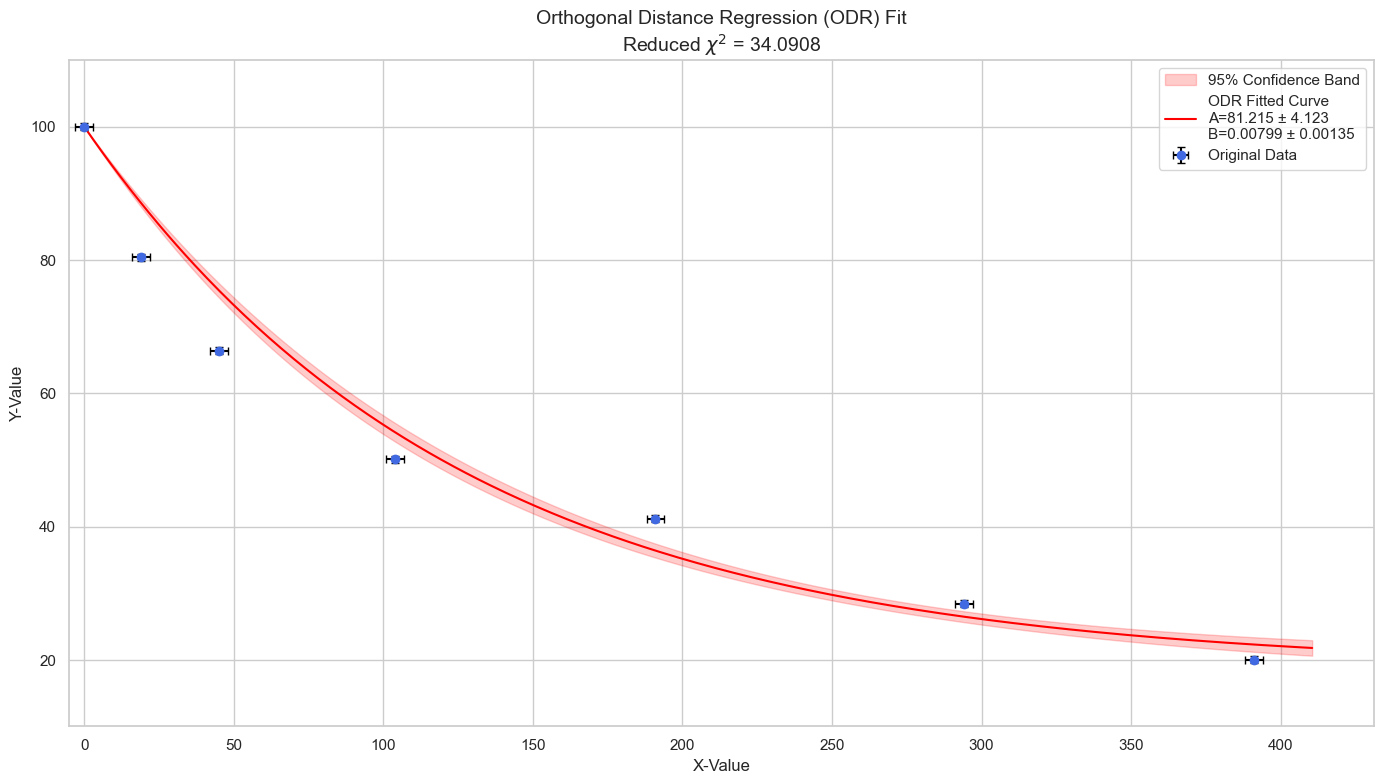

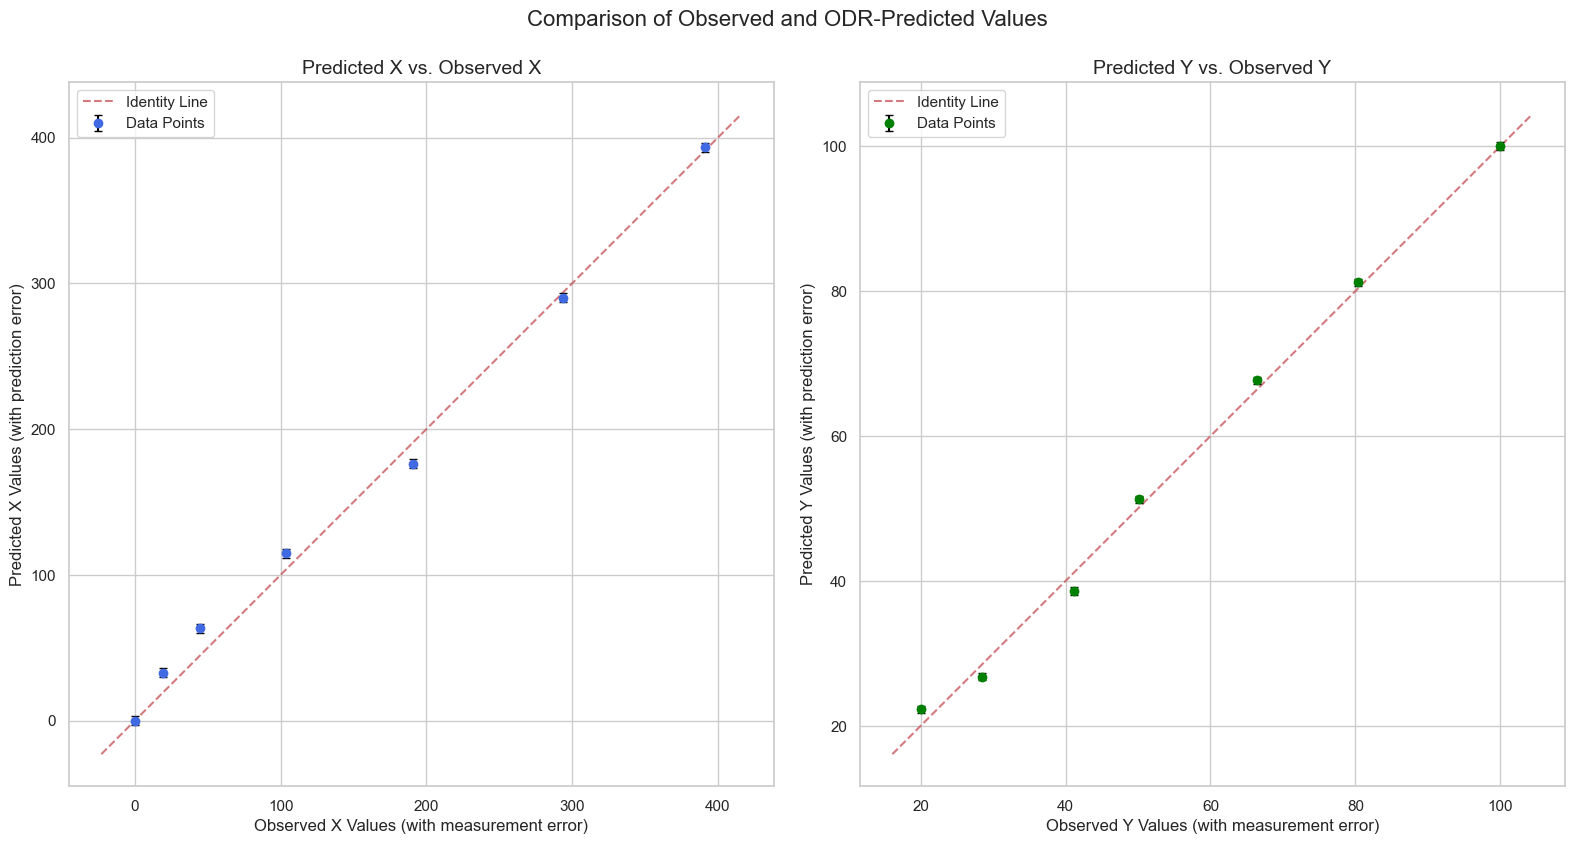

In [ ]:
def model_function(beta, x):
    """
    The custom function to approximate the data.
    f(x; A, B) = A * (np.exp(-B * x) - 1) + 100
    Note: The signature is now (beta, x) for scipy.odr.
    """
    A, B = beta
    return A * (np.exp(-B * x) - 1) + 100

# Dataset 2
x = np.array([0, 19, 45, 104, 191, 294, 391])
y_obs = np.array([100, 80.4, 66.4, 50.1, 41.2, 28.5, 20.1])
sigma_y = np.full_like(y_obs, 0.5, dtype=float)
sigma_x = np.full_like(x, 3.0, dtype=float)
initial_guess = [50, 0.01]

# Analyze the curve fit and get results using ODR
odr_results = analyze_odr(x, y_obs, sigma_x, sigma_y, model_function, initial_guess)

# Print the metrics
print_metrics(odr_results)

# Draw the curve fit plot
draw_curve_fit(odr_results, model_function)

# Plot predicted vs observed values
plot_predicted_vs_observed(odr_results, show_errors=True)

Let's exclude Point 5 as a potential outlier and change `sigma_y` to 1.0.

--- ODR Fit Results ---
Beta: [7.82911417e+01 1.04406955e-02]
Beta Std Error: [2.72313737e+00 1.41079854e-03]
Beta Covariance: [[ 9.08962511e-01 -3.31014186e-04]
 [-3.31014186e-04  2.43970252e-07]]
Residual Variance: 8.158177098793473
Inverse Condition #: 0.2509151293805631
Reason(s) for Halting:
  Sum of squares convergence

--- Summary of Results ---
Parameter A: 78.29114 +/- 2.72314
  T-value: 28.75034604, P-value: 0.00000871
Parameter B: 0.01044 +/- 0.00141
  T-value: 7.40055735, P-value: 0.00177826

--- Model Fit Statistics ---

Number of Observations (n): 6
Number of Parameters (p): 2
Degrees of Freedom (n-p): 4

--- Goodness-of-Fit & Error Metrics ---
Chi-Squared (from ODR): 32.6327
Reduced Chi-Squared (from ODR): 8.1582

--- Information Criteria ---
Maximum Log-Likelihood: -33.9353
AIC (Akaike Information Criterion): 71.8706
BIC (Bayesian Information Criterion): 71.4541
AICc (Corrected AIC): 75.8706

--- Comparison of Original and Predicted Data Points ---
  Original X    Predi

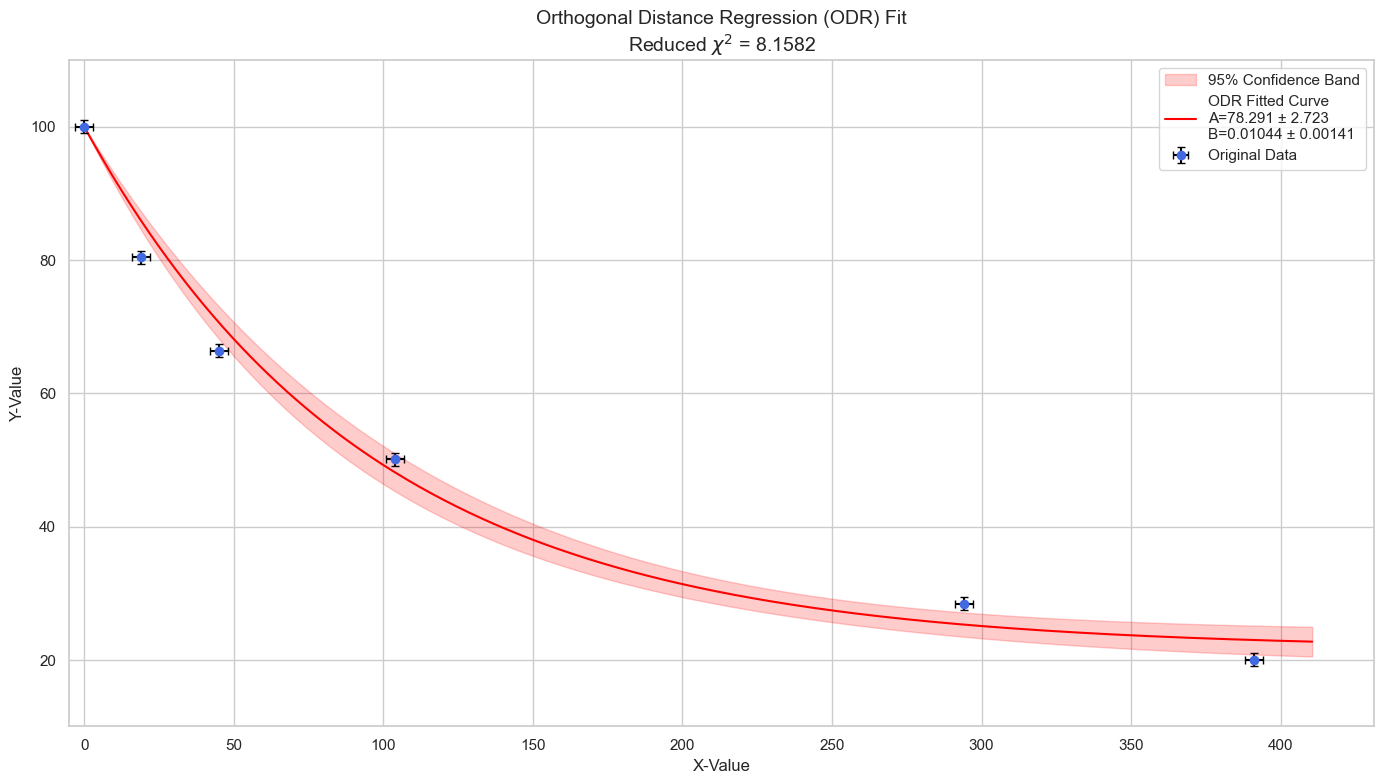

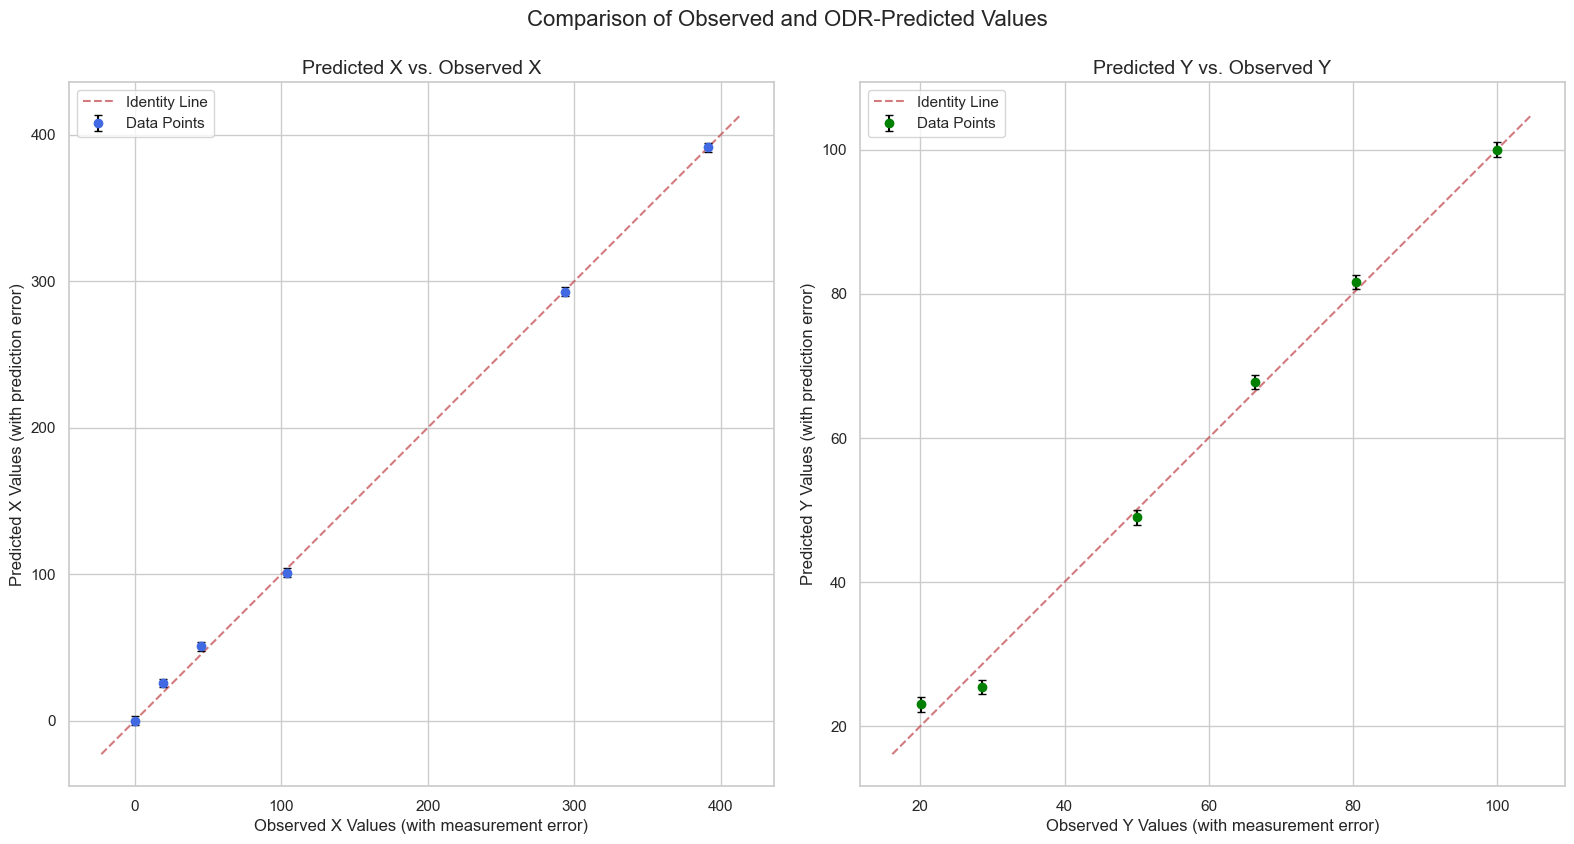

In [ ]:
def model_function(beta, x):
    """
    The custom function to approximate the data.
    f(x; A, B) = A * (np.exp(-B * x) - 1) + 100
    Note: The signature is now (beta, x) for scipy.odr.
    """
    A, B = beta
    return A * (np.exp(-B * x) - 1) + 100

# Dataset 2
x = np.array([0, 19, 45, 104, 294, 391])
y_obs = np.array([100, 80.4, 66.4, 50.1, 28.5, 20.1])
sigma_y = np.full_like(y_obs, 1.0, dtype=float)
sigma_x = np.full_like(x, 3.0, dtype=float)
initial_guess = [50, 0.01]

# Analyze the curve fit and get results using ODR
odr_results = analyze_odr(x, y_obs, sigma_x, sigma_y, model_function, initial_guess)

# Print the metrics
print_metrics(odr_results)

# Draw the curve fit plot
draw_curve_fit(odr_results, model_function)

# Plot predicted vs observed values
plot_predicted_vs_observed(odr_results, show_errors=True)

### Improved model function

Let's start from scratch and try to connect to the results from Dataset 3, so our function will be

$$f(x, A, B) = A_1 (\exp (-B_1 x) - 1) + A (\exp(-B x) - 1) + 100 $$

where A_1 and B_1 are defined from the ODR of Dataset 3 using a function $f(x, A, B) = A (\exp(-B x) - 1) + 100 $.

--- ODR Fit Results ---
Beta: [2.90793948e+01 3.79005344e-03]
Beta Std Error: [1.43819054e+01 3.44593578e-03]
Beta Covariance: [[ 4.45754736e+00 -1.04404457e-03]
 [-1.04404457e-03  2.55904233e-07]]
Residual Variance: 46.40202017290558
Inverse Condition #: 0.10528095243077833
Reason(s) for Halting:
  Sum of squares convergence

--- Summary of Results ---
Parameter A: 29.07939 +/- 14.38191
  T-value: 2.02194313, P-value: 0.09912431
Parameter B: 0.00379 +/- 0.00345
  T-value: 1.09986189, P-value: 0.32150555

--- Model Fit Statistics ---

Number of Observations (n): 7
Number of Parameters (p): 2
Degrees of Freedom (n-p): 5

--- Goodness-of-Fit & Error Metrics ---
Chi-Squared (from ODR): 232.0101
Reduced Chi-Squared (from ODR): 46.4020

--- Information Criteria ---
Maximum Log-Likelihood: -128.8702
AIC (Akaike Information Criterion): 261.7404
BIC (Bayesian Information Criterion): 261.6322
AICc (Corrected AIC): 264.7404

--- Comparison of Original and Predicted Data Points ---
  Original X  

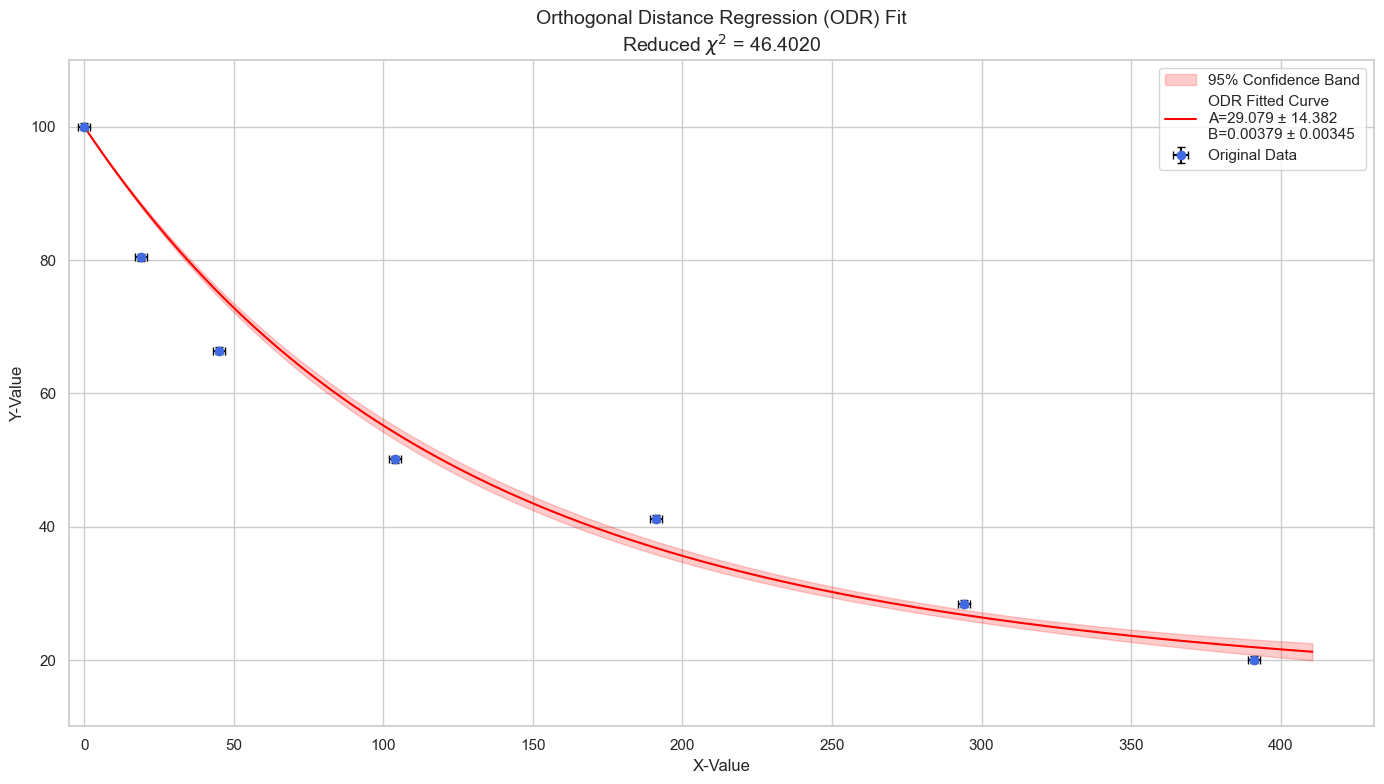

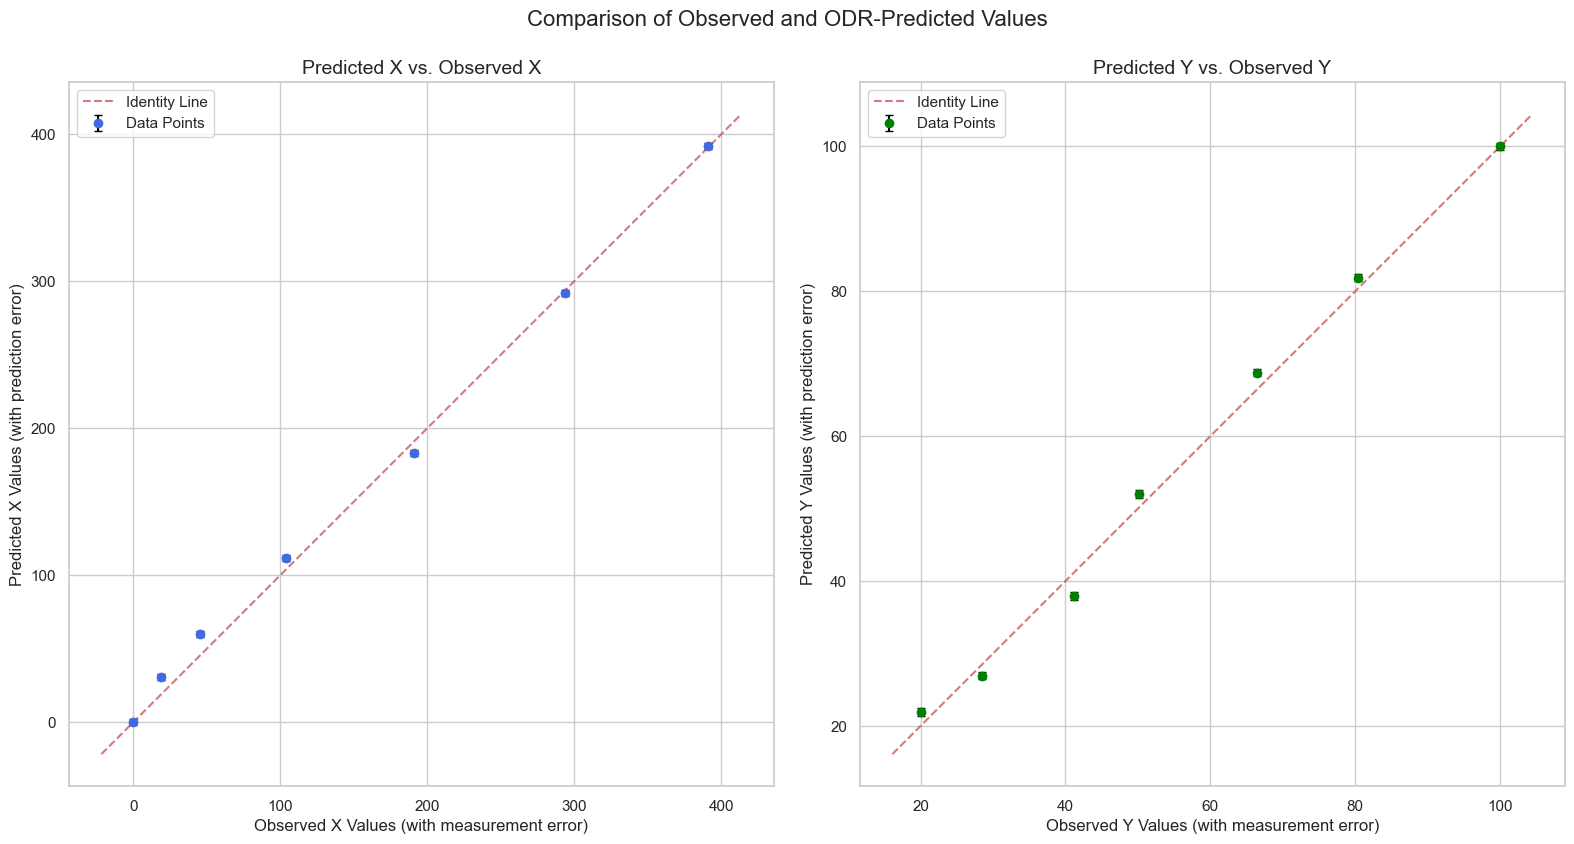

In [ ]:
def model_function(beta, x):
    """
    The custom function to approximate the data.
    f(x, A, B) = A_1 * (np.exp(-B_1 * x) - 1) + A * (np.exp(-B * x) - 1) + 100
    Note: The signature is now (beta, x) for scipy.odr.
    """

    A_1 = 56.769 # obtained from Dataset 3 with sigma_x = 2.0, sigma_y = 0.5
    B_1 = 0.00988 # obtained from Dataset 3 with sigma_x = 2.0, sigma_y = 0.5

    # A_1 = 56.747 # obtained from Dataset 3 with sigma_x = 3.0, sigma_y = 0.5
    # B_1 = 0.00991 # obtained from Dataset 3 with sigma_x = 3.0, sigma_y = 0.5

    A, B = beta
    
    return A_1 * (np.exp(-B_1 * x) - 1) + A * (np.exp(-B * x) - 1) + 100

# Dataset 2
x = np.array([0, 19, 45, 104, 191, 294, 391])
y_obs = np.array([100, 80.4, 66.4, 50.1, 41.2, 28.5, 20.1])
sigma_y = np.full_like(y_obs, 0.5, dtype=float)
sigma_x = np.full_like(x, 2.0, dtype=float)
initial_guess = [50, 0.01]

# Analyze the curve fit and get results using ODR
odr_results = analyze_odr(x, y_obs, sigma_x, sigma_y, model_function, initial_guess)

# Print the metrics
print_metrics(odr_results)

# Draw the curve fit plot
draw_curve_fit(odr_results, model_function)

# Plot predicted vs observed values
plot_predicted_vs_observed(odr_results, show_errors=True)

Let's change `sigma_x` to 3.0.

--- ODR Fit Results ---
Beta: [3.73843185e+01 2.47485436e-03]
Beta Std Error: [2.72441362e+01 2.74418152e-03]
Beta Covariance: [[ 2.61587979e+01 -2.61599997e-03]
 [-2.61599997e-03  2.65397831e-07]]
Residual Variance: 28.374505629249352
Inverse Condition #: 0.04164089938749358
Reason(s) for Halting:
  Sum of squares convergence

--- Summary of Results ---
Parameter A: 37.38432 +/- 27.24414
  T-value: 1.37219687, P-value: 0.22836227
Parameter B: 0.00247 +/- 0.00274
  T-value: 0.90185519, P-value: 0.40847427

--- Model Fit Statistics ---

Number of Observations (n): 7
Number of Parameters (p): 2
Degrees of Freedom (n-p): 5

--- Goodness-of-Fit & Error Metrics ---
Chi-Squared (from ODR): 141.8725
Reduced Chi-Squared (from ODR): 28.3745

--- Information Criteria ---
Maximum Log-Likelihood: -86.6397
AIC (Akaike Information Criterion): 177.2793
BIC (Bayesian Information Criterion): 177.1711
AICc (Corrected AIC): 180.2793

--- Comparison of Original and Predicted Data Points ---
  Original X  

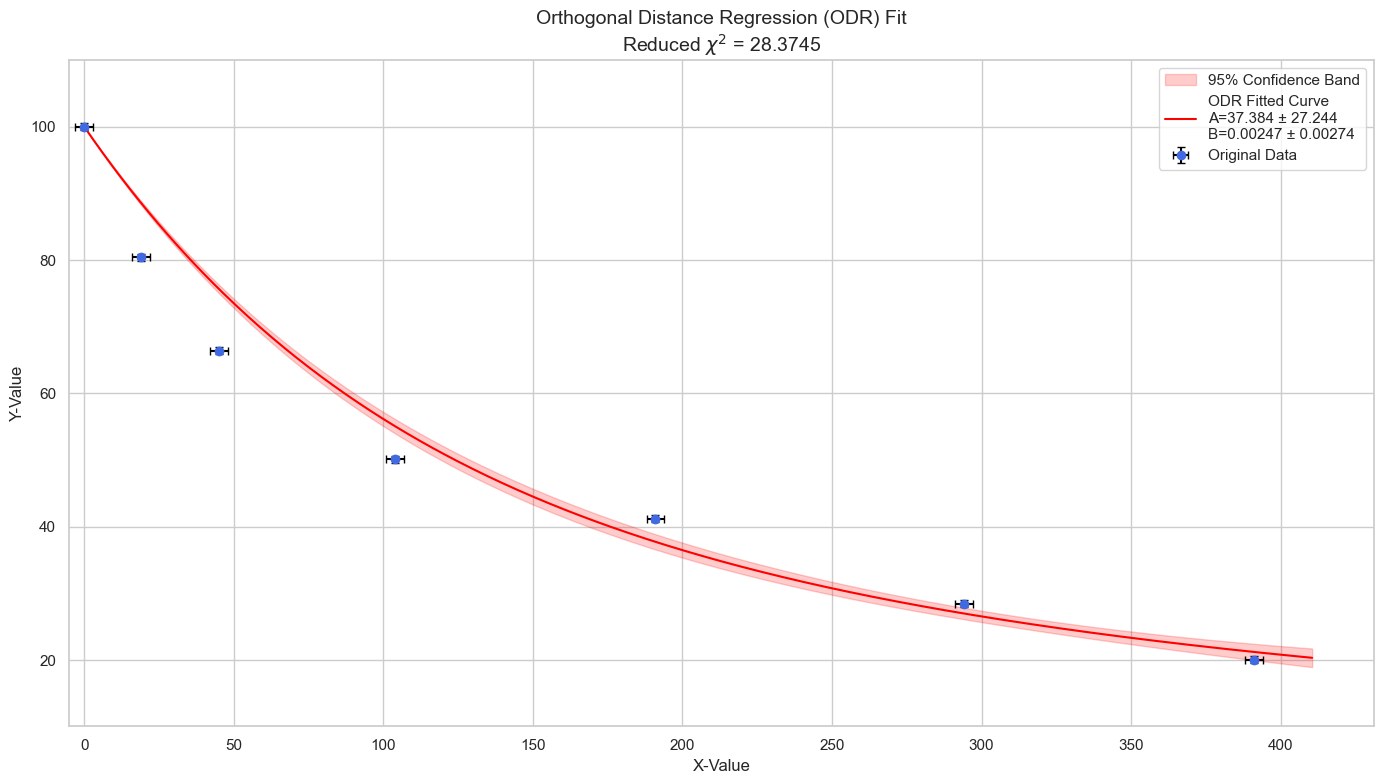

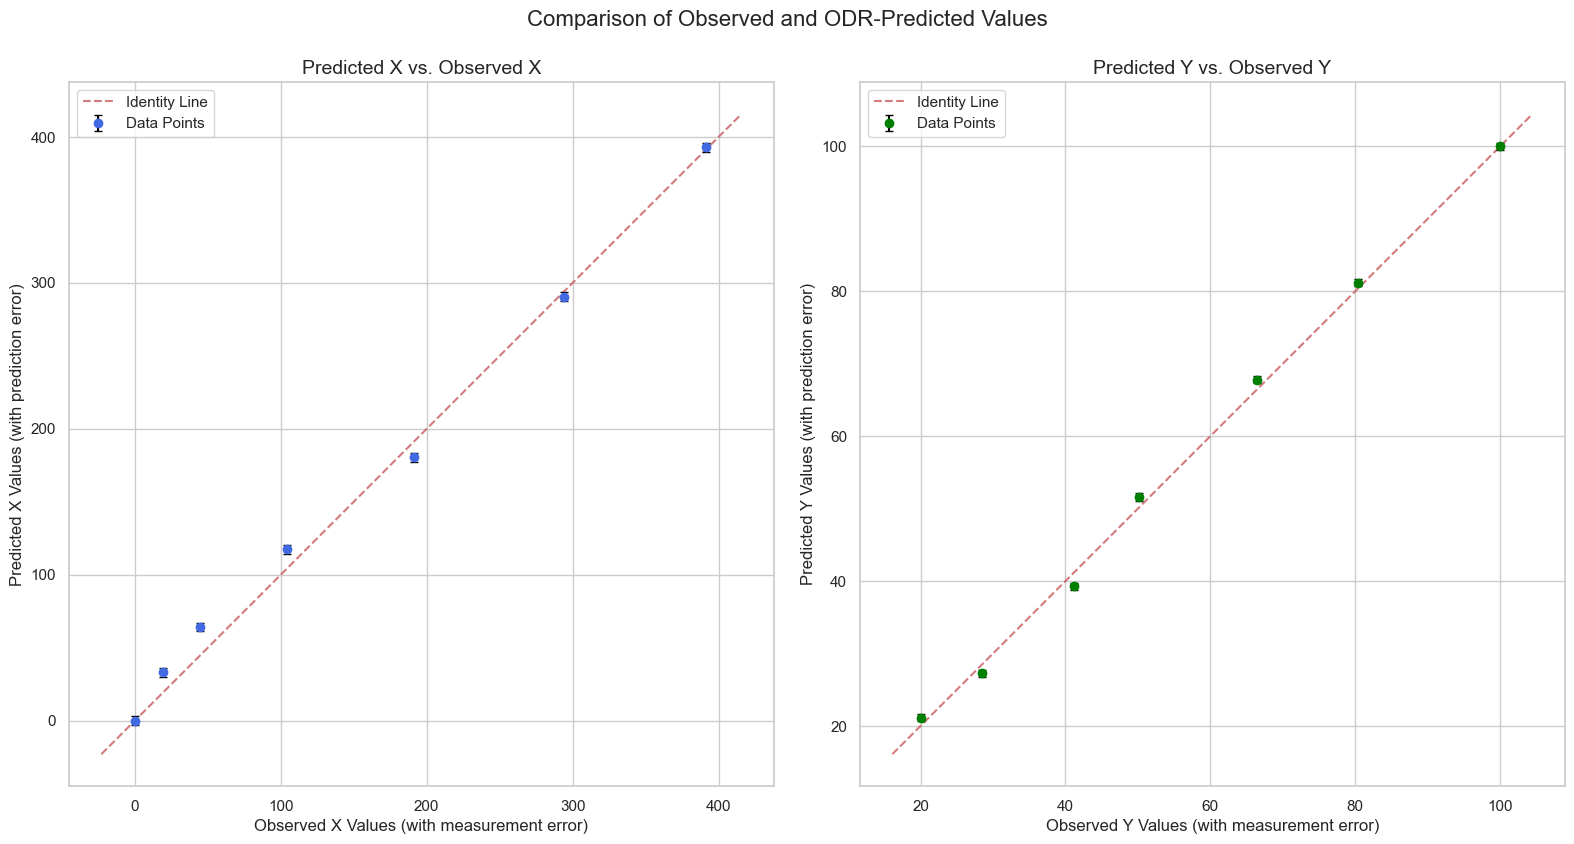

In [ ]:
def model_function(beta, x):
    """
    The custom function to approximate the data.
    f(x, A, B) = A_1 * (np.exp(-B_1 * x) - 1) + A * (np.exp(-B * x) - 1) + 100
    Note: The signature is now (beta, x) for scipy.odr.
    """

    A_1 = 56.769 # obtained from Dataset 3 with sigma_x = 2.0, sigma_y = 0.5
    B_1 = 0.00988 # obtained from Dataset 3 with sigma_x = 2.0, sigma_y = 0.5

    # A_1 = 56.747 # obtained from Dataset 3 with sigma_x = 3.0, sigma_y = 0.5
    # B_1 = 0.00991 # obtained from Dataset 3 with sigma_x = 3.0, sigma_y = 0.5

    A, B = beta
    
    return A_1 * (np.exp(-B_1 * x) - 1) + A * (np.exp(-B * x) - 1) + 100

# Dataset 2
x = np.array([0, 19, 45, 104, 191, 294, 391])
y_obs = np.array([100, 80.4, 66.4, 50.1, 41.2, 28.5, 20.1])
sigma_y = np.full_like(y_obs, 0.5, dtype=float)
sigma_x = np.full_like(x, 3.0, dtype=float)
initial_guess = [50, 0.01]

# Analyze the curve fit and get results using ODR
odr_results = analyze_odr(x, y_obs, sigma_x, sigma_y, model_function, initial_guess)

# Print the metrics
print_metrics(odr_results)

# Draw the curve fit plot
draw_curve_fit(odr_results, model_function)

# Plot predicted vs observed values
plot_predicted_vs_observed(odr_results, show_errors=True)

Let's change `sigma_y` to 1.0.

--- ODR Fit Results ---
Beta: [2.49623811e+01 5.23264236e-03]
Beta Std Error: [9.07480094e+00 4.18366301e-03]
Beta Covariance: [[ 5.43573560e+00 -2.37618944e-03]
 [-2.37618944e-03  1.15530725e-06]]
Residual Variance: 15.150113669551942
Inverse Condition #: 0.10616159038968023
Reason(s) for Halting:
  Sum of squares convergence

--- Summary of Results ---
Parameter A: 24.96238 +/- 9.07480
  T-value: 2.75073594, P-value: 0.04027501
Parameter B: 0.00523 +/- 0.00418
  T-value: 1.25073228, P-value: 0.26637044

--- Model Fit Statistics ---

Number of Observations (n): 7
Number of Parameters (p): 2
Degrees of Freedom (n-p): 5

--- Goodness-of-Fit & Error Metrics ---
Chi-Squared (from ODR): 75.7506
Reduced Chi-Squared (from ODR): 15.1501

--- Information Criteria ---
Maximum Log-Likelihood: -58.4307
AIC (Akaike Information Criterion): 120.8614
BIC (Bayesian Information Criterion): 120.7532
AICc (Corrected AIC): 123.8614

--- Comparison of Original and Predicted Data Points ---
  Original X    

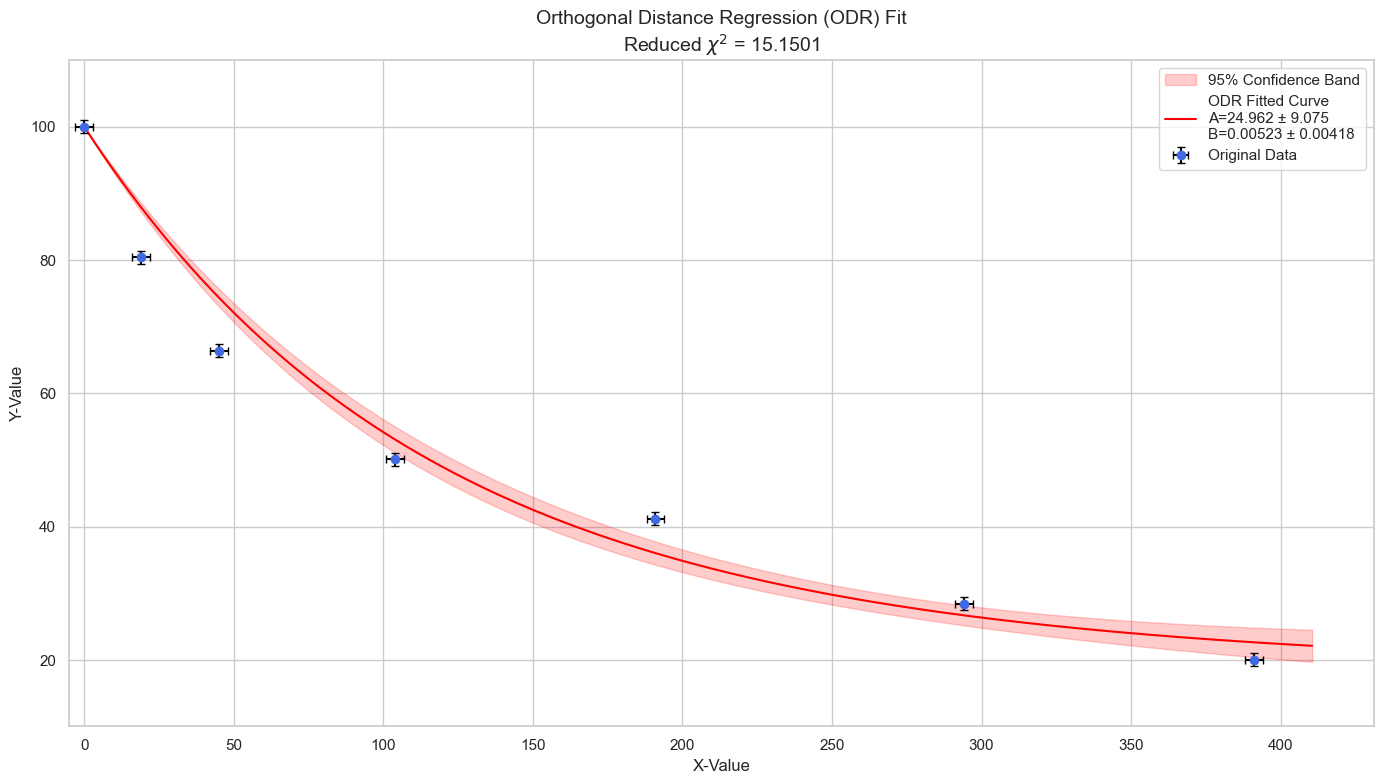

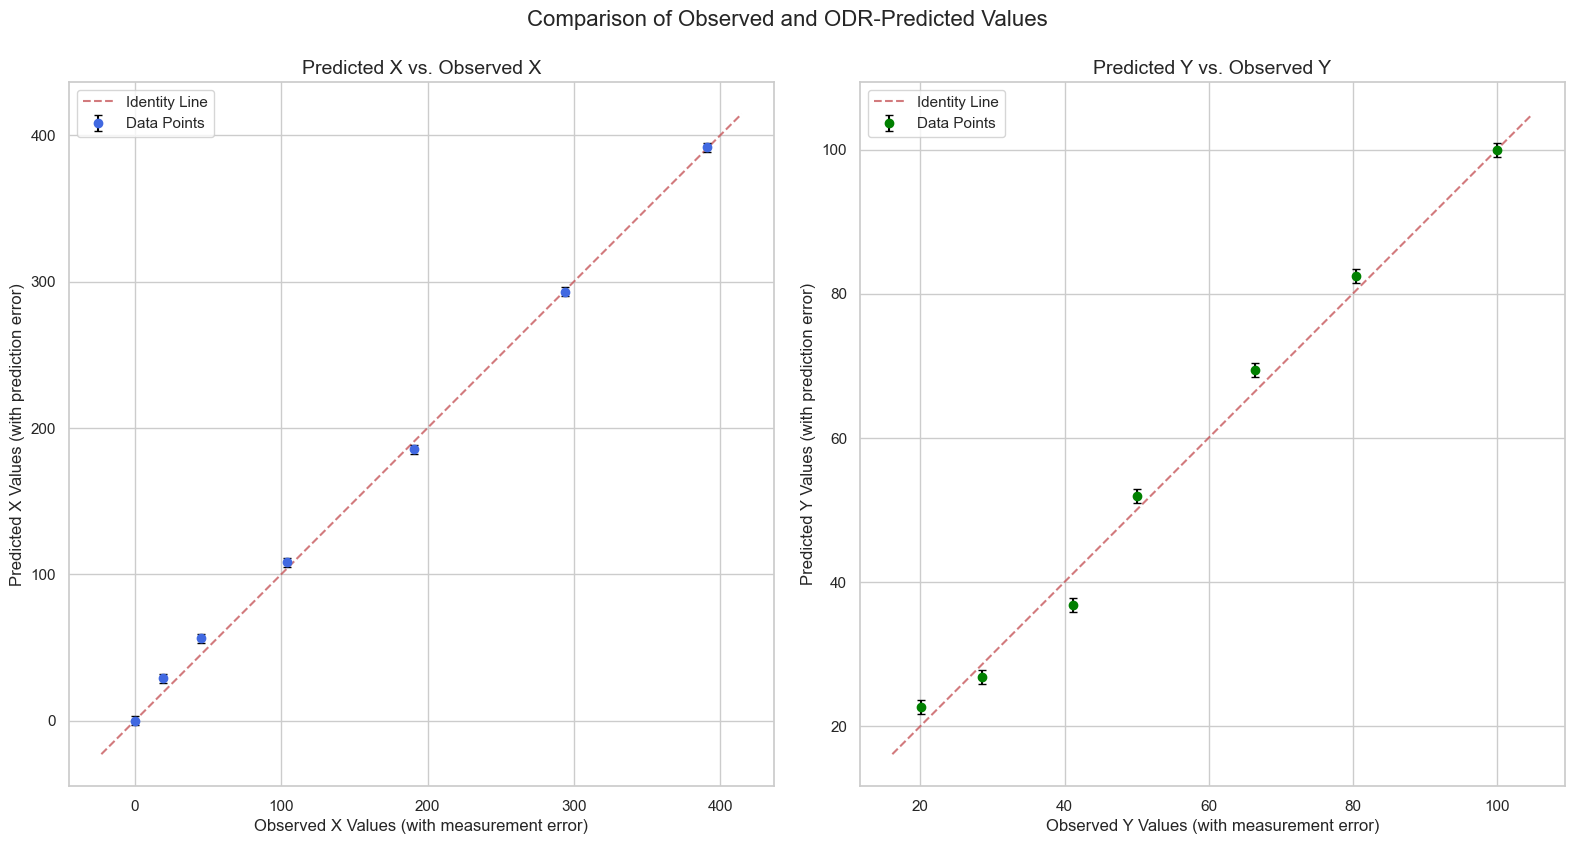

In [ ]:
def model_function(beta, x):
    """
    The custom function to approximate the data.
    f(x, A, B) = A_1 * (np.exp(-B_1 * x) - 1) + A * (np.exp(-B * x) - 1) + 100
    Note: The signature is now (beta, x) for scipy.odr.
    """

    A_1 = 56.769 # obtained from Dataset 3 with sigma_x = 2.0, sigma_y = 0.5
    B_1 = 0.00988 # obtained from Dataset 3 with sigma_x = 2.0, sigma_y = 0.5

    # A_1 = 56.747 # obtained from Dataset 3 with sigma_x = 3.0, sigma_y = 0.5
    # B_1 = 0.00991 # obtained from Dataset 3 with sigma_x = 3.0, sigma_y = 0.5

    A, B = beta
    
    return A_1 * (np.exp(-B_1 * x) - 1) + A * (np.exp(-B * x) - 1) + 100

# Dataset 2
x = np.array([0, 19, 45, 104, 191, 294, 391])
y_obs = np.array([100, 80.4, 66.4, 50.1, 41.2, 28.5, 20.1])
sigma_y = np.full_like(y_obs, 1.0, dtype=float)
sigma_x = np.full_like(x, 3.0, dtype=float)
initial_guess = [50, 0.01]

# Analyze the curve fit and get results using ODR
odr_results = analyze_odr(x, y_obs, sigma_x, sigma_y, model_function, initial_guess)

# Print the metrics
print_metrics(odr_results)

# Draw the curve fit plot
draw_curve_fit(odr_results, model_function)

# Plot predicted vs observed values
plot_predicted_vs_observed(odr_results, show_errors=True)

Let's exclude Point 5 as a potential outlier.

--- ODR Fit Results ---
Beta: [2.16951689e+01 1.15330887e-02]
Beta Std Error: [2.34886926 0.00567341]
Beta Covariance: [[ 2.02484421e-01 -3.18387590e-04]
 [-3.18387590e-04  1.18130626e-06]]
Residual Variance: 27.247463231985694
Inverse Condition #: 0.06297193338287788
Reason(s) for Halting:
  Sum of squares convergence

--- Summary of Results ---
Parameter A: 21.69517 +/- 2.34887
  T-value: 9.23643103, P-value: 0.00076372
Parameter B: 0.01153 +/- 0.00567
  T-value: 2.03283131, P-value: 0.11185177

--- Model Fit Statistics ---

Number of Observations (n): 6
Number of Parameters (p): 2
Degrees of Freedom (n-p): 4

--- Goodness-of-Fit & Error Metrics ---
Chi-Squared (from ODR): 108.9899
Reduced Chi-Squared (from ODR): 27.2475

--- Information Criteria ---
Maximum Log-Likelihood: -65.5222
AIC (Akaike Information Criterion): 135.0444
BIC (Bayesian Information Criterion): 134.6279
AICc (Corrected AIC): 139.0444

--- Comparison of Original and Predicted Data Points ---
  Original X    Predict

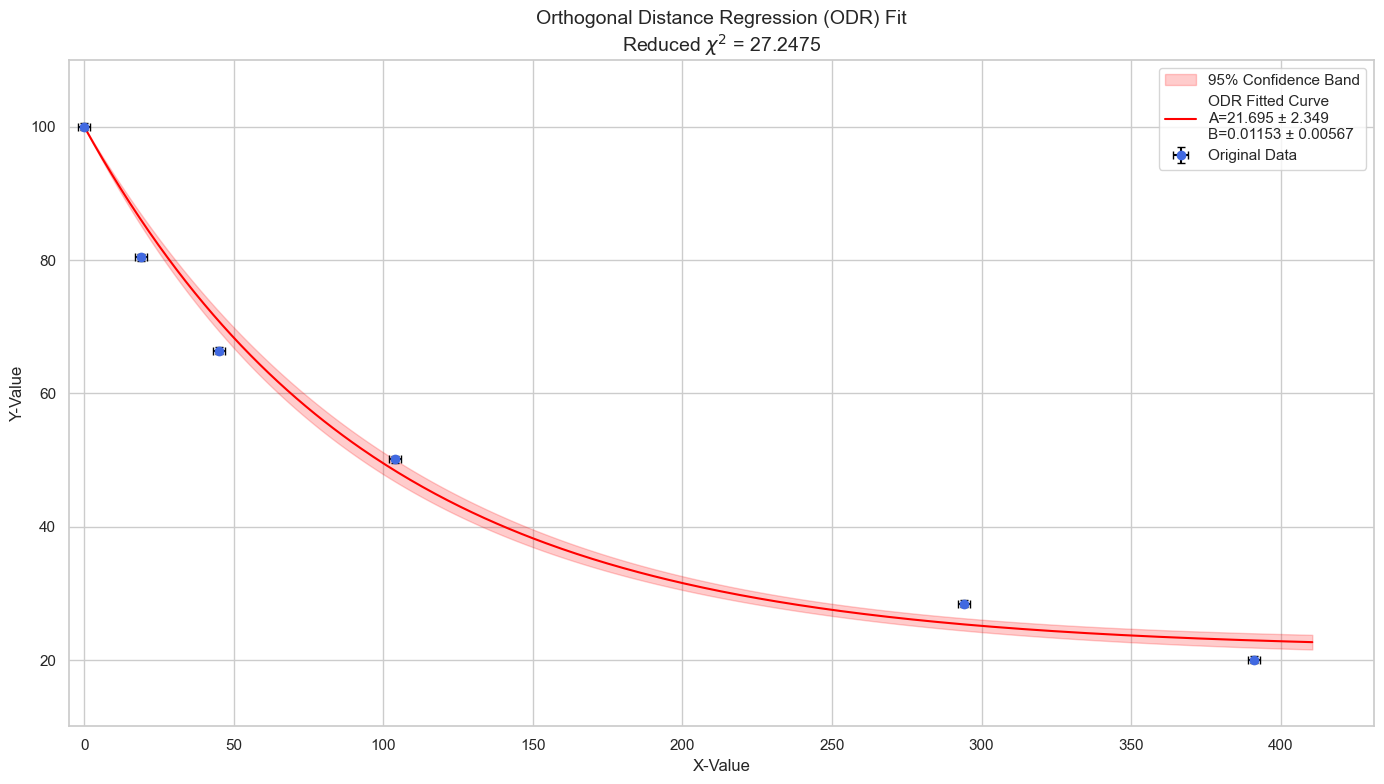

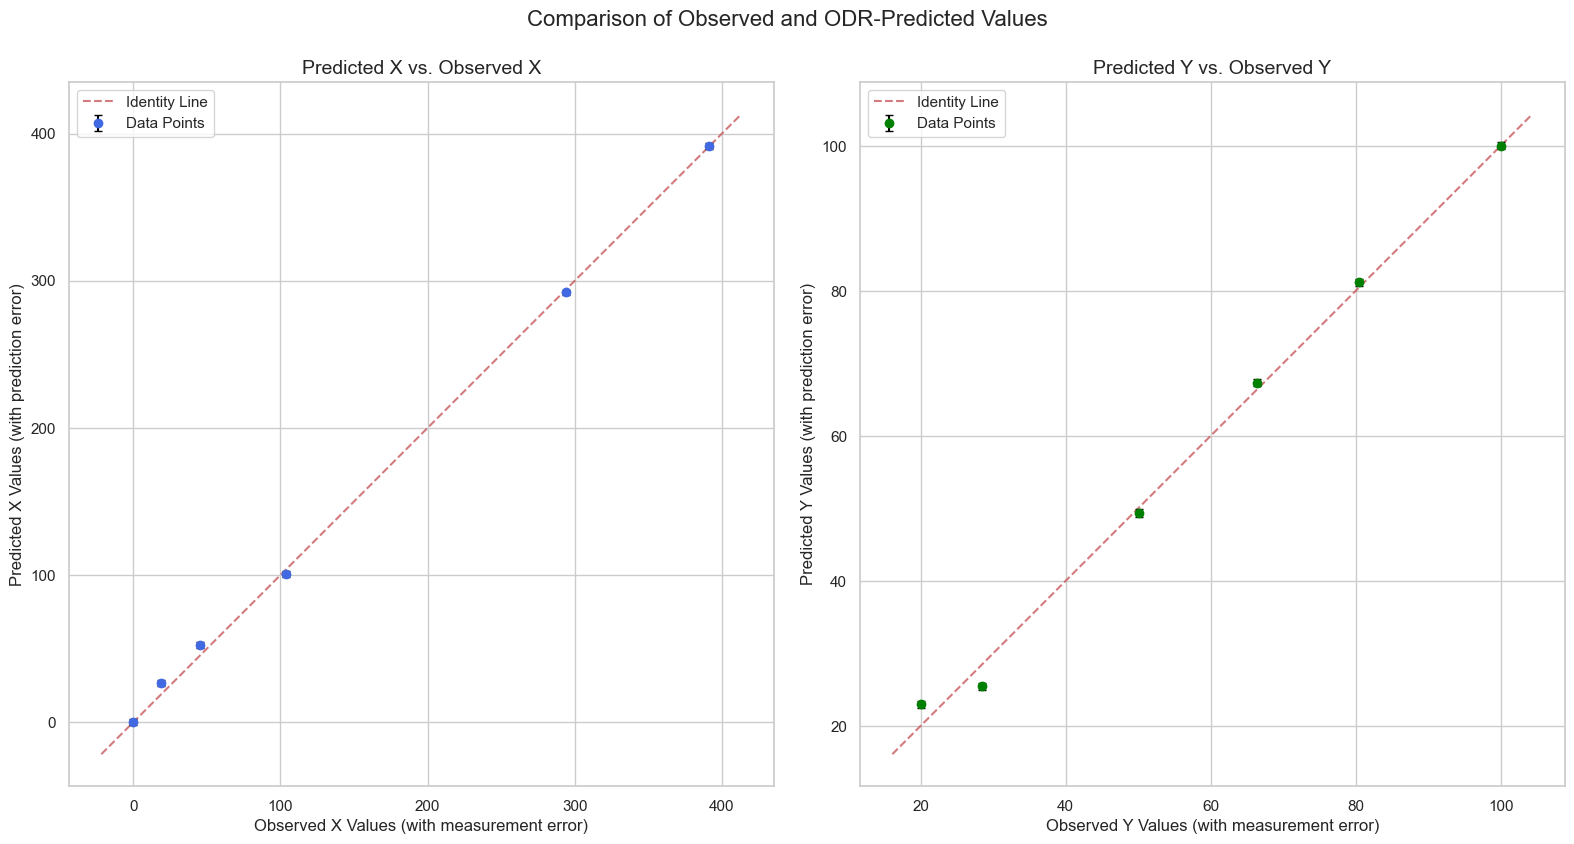

In [ ]:
def model_function(beta, x):
    """
    The custom function to approximate the data.
    f(x, A, B) = A_1 * (np.exp(-B_1 * x) - 1) + A * (np.exp(-B * x) - 1) + 100
    Note: The signature is now (beta, x) for scipy.odr.
    """

    A_1 = 56.769 # obtained from Dataset 3 with sigma_x = 2.0, sigma_y = 0.5
    B_1 = 0.00988 # obtained from Dataset 3 with sigma_x = 2.0, sigma_y = 0.5

    # A_1 = 56.747 # obtained from Dataset 3 with sigma_x = 3.0, sigma_y = 0.5
    # B_1 = 0.00991 # obtained from Dataset 3 with sigma_x = 3.0, sigma_y = 0.5

    A, B = beta
    
    return A_1 * (np.exp(-B_1 * x) - 1) + A * (np.exp(-B * x) - 1) + 100

# Dataset 2
x = np.array([0, 19, 45, 104, 294, 391])
y_obs = np.array([100, 80.4, 66.4, 50.1, 28.5, 20.1])
sigma_y = np.full_like(y_obs, 0.5, dtype=float)
sigma_x = np.full_like(x, 2.0, dtype=float)
initial_guess = [50, 0.01]

# Analyze the curve fit and get results using ODR
odr_results = analyze_odr(x, y_obs, sigma_x, sigma_y, model_function, initial_guess)

# Print the metrics
print_metrics(odr_results)

# Draw the curve fit plot
draw_curve_fit(odr_results, model_function)

# Plot predicted vs observed values
plot_predicted_vs_observed(odr_results, show_errors=True)

Let's change `sigma_x` to 3.0 and `sigma_y` to 1.0

--- ODR Fit Results ---
Beta: [2.13210676e+01 1.31203682e-02]
Beta Std Error: [2.30224116 0.0060255 ]
Beta Covariance: [[ 6.62232423e-01 -1.03028283e-03]
 [-1.03028283e-03  4.53622235e-06]]
Residual Variance: 8.003707104987365
Inverse Condition #: 0.06202072835778165
Reason(s) for Halting:
  Sum of squares convergence

--- Summary of Results ---
Parameter A: 21.32107 +/- 2.30224
  T-value: 9.26100530, P-value: 0.00075595
Parameter B: 0.01312 +/- 0.00603
  T-value: 2.17747542, P-value: 0.09501228

--- Model Fit Statistics ---

Number of Observations (n): 6
Number of Parameters (p): 2
Degrees of Freedom (n-p): 4

--- Goodness-of-Fit & Error Metrics ---
Chi-Squared (from ODR): 32.0148
Reduced Chi-Squared (from ODR): 8.0037

--- Information Criteria ---
Maximum Log-Likelihood: -33.6264
AIC (Akaike Information Criterion): 71.2527
BIC (Bayesian Information Criterion): 70.8362
AICc (Corrected AIC): 75.2527

--- Comparison of Original and Predicted Data Points ---
  Original X    Predicted X (

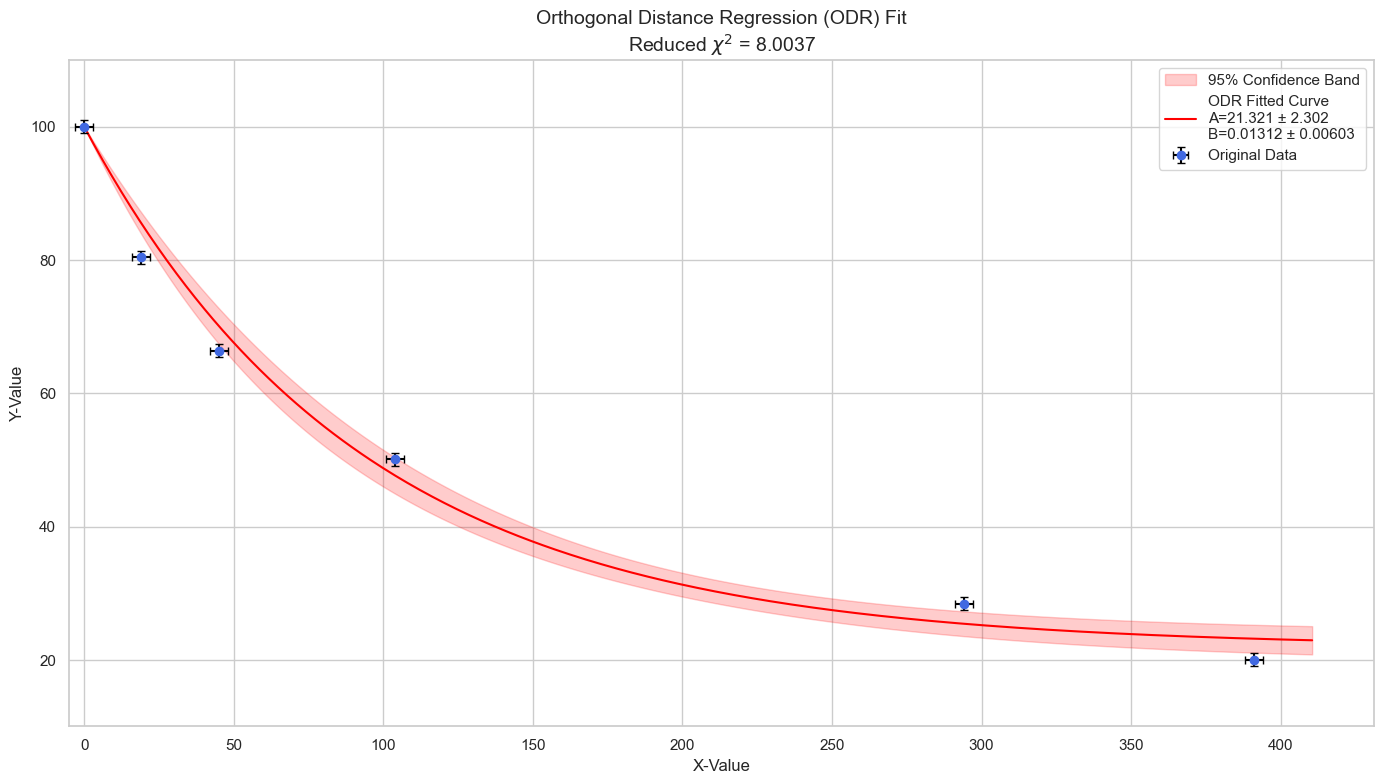

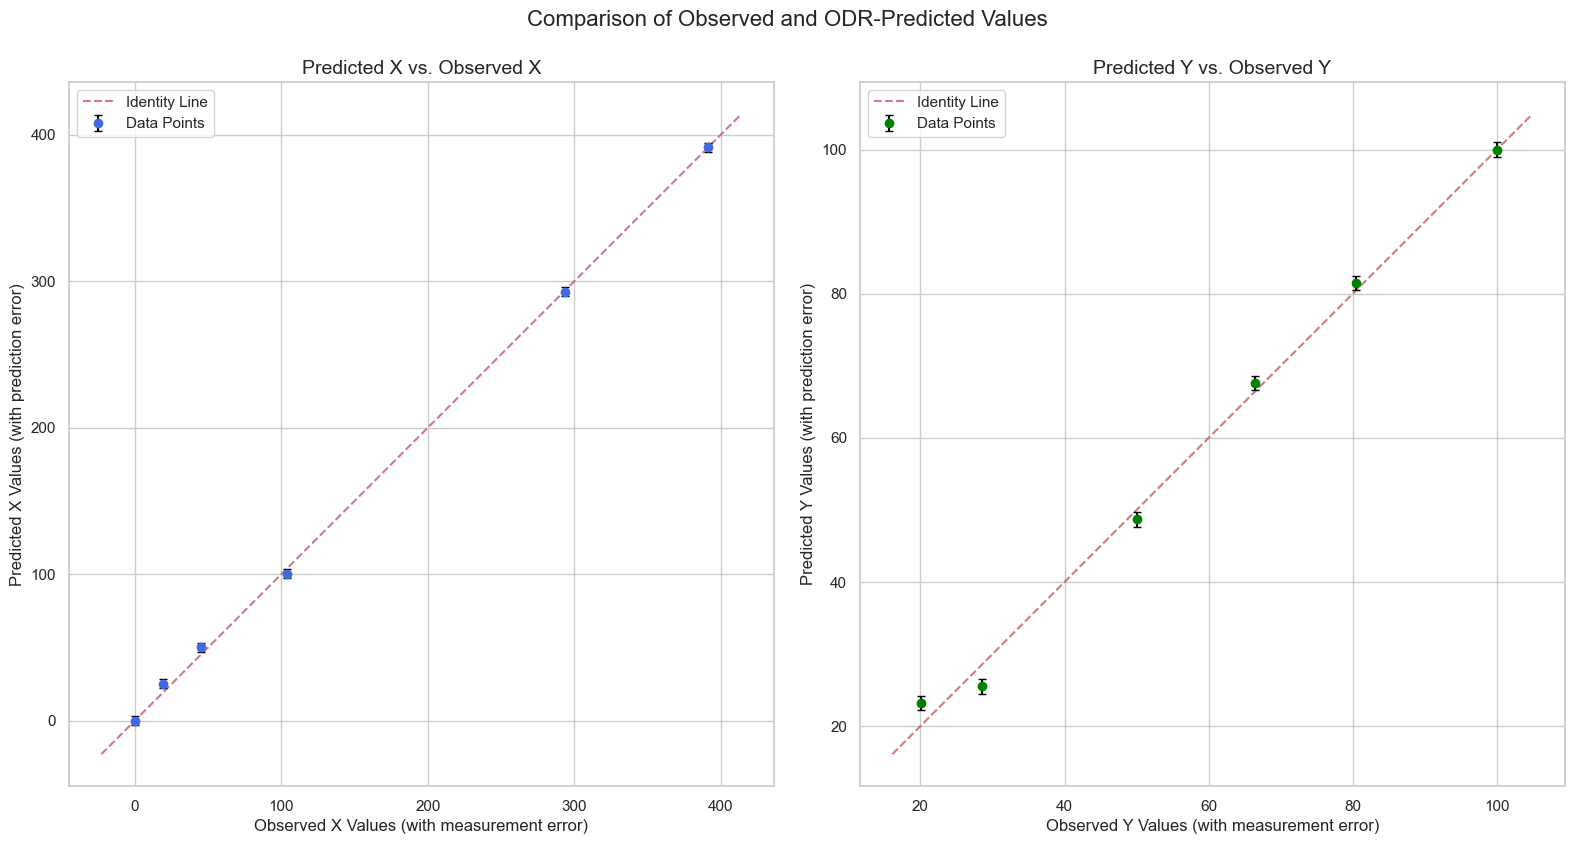

In [ ]:
def model_function(beta, x):
    """
    The custom function to approximate the data.
    f(x, A, B) = A_1 * (np.exp(-B_1 * x) - 1) + A * (np.exp(-B * x) - 1) + 100
    Note: The signature is now (beta, x) for scipy.odr.
    """

    A_1 = 56.769 # obtained from Dataset 3 with sigma_x = 2.0, sigma_y = 0.5
    B_1 = 0.00988 # obtained from Dataset 3 with sigma_x = 2.0, sigma_y = 0.5

    # A_1 = 56.747 # obtained from Dataset 3 with sigma_x = 3.0, sigma_y = 0.5
    # B_1 = 0.00991 # obtained from Dataset 3 with sigma_x = 3.0, sigma_y = 0.5

    A, B = beta
    
    return A_1 * (np.exp(-B_1 * x) - 1) + A * (np.exp(-B * x) - 1) + 100

# Dataset 2
x = np.array([0, 19, 45, 104, 294, 391])
y_obs = np.array([100, 80.4, 66.4, 50.1, 28.5, 20.1])
sigma_y = np.full_like(y_obs, 1.0, dtype=float)
sigma_x = np.full_like(x, 3.0, dtype=float)
initial_guess = [50, 0.01]

# Analyze the curve fit and get results using ODR
odr_results = analyze_odr(x, y_obs, sigma_x, sigma_y, model_function, initial_guess)

# Print the metrics
print_metrics(odr_results)

# Draw the curve fit plot
draw_curve_fit(odr_results, model_function)

# Plot predicted vs observed values
plot_predicted_vs_observed(odr_results, show_errors=True)

### More than 2 parameters in the non-linear model

The standard deviations are too large, this result cannot be used:

--- ODR Fit Results ---
Beta: [ 7.30962166e+03 -7.23159984e+03  9.88632018e-03]
Beta Std Error: [1.01313162e+08 1.01313146e+08 8.85098695e-02]
Beta Covariance: [[ 5.16200872e+14 -5.16200794e+14 -4.50966782e+05]
 [-5.16200794e+14  5.16200717e+14  4.50966715e+05]
 [-4.50966782e+05  4.50966715e+05  3.93976572e-04]]
Residual Variance: 19.884423452995758
Inverse Condition #: 3.294825903501306e-10
Reason(s) for Halting:
  Sum of squares convergence

--- Summary of Results ---
Parameter A: 7309.62166 +/- 101313161.65532
  T-value: 0.00007215, P-value: 0.99994589
Parameter B: -7231.59984 +/- 101313146.44955
  T-value: -0.00007138, P-value: 0.99994647
Parameter C: 0.00989 +/- 0.08851
  T-value: 0.11169738, P-value: 0.91644400

--- Model Fit Statistics ---

Number of Observations (n): 7
Number of Parameters (p): 3
Degrees of Freedom (n-p): 4

--- Goodness-of-Fit & Error Metrics ---
Chi-Squared (from ODR): 79.5377
Reduced Chi-Squared (from ODR): 19.8844

--- Information Criteria ---
Maximum Log-L

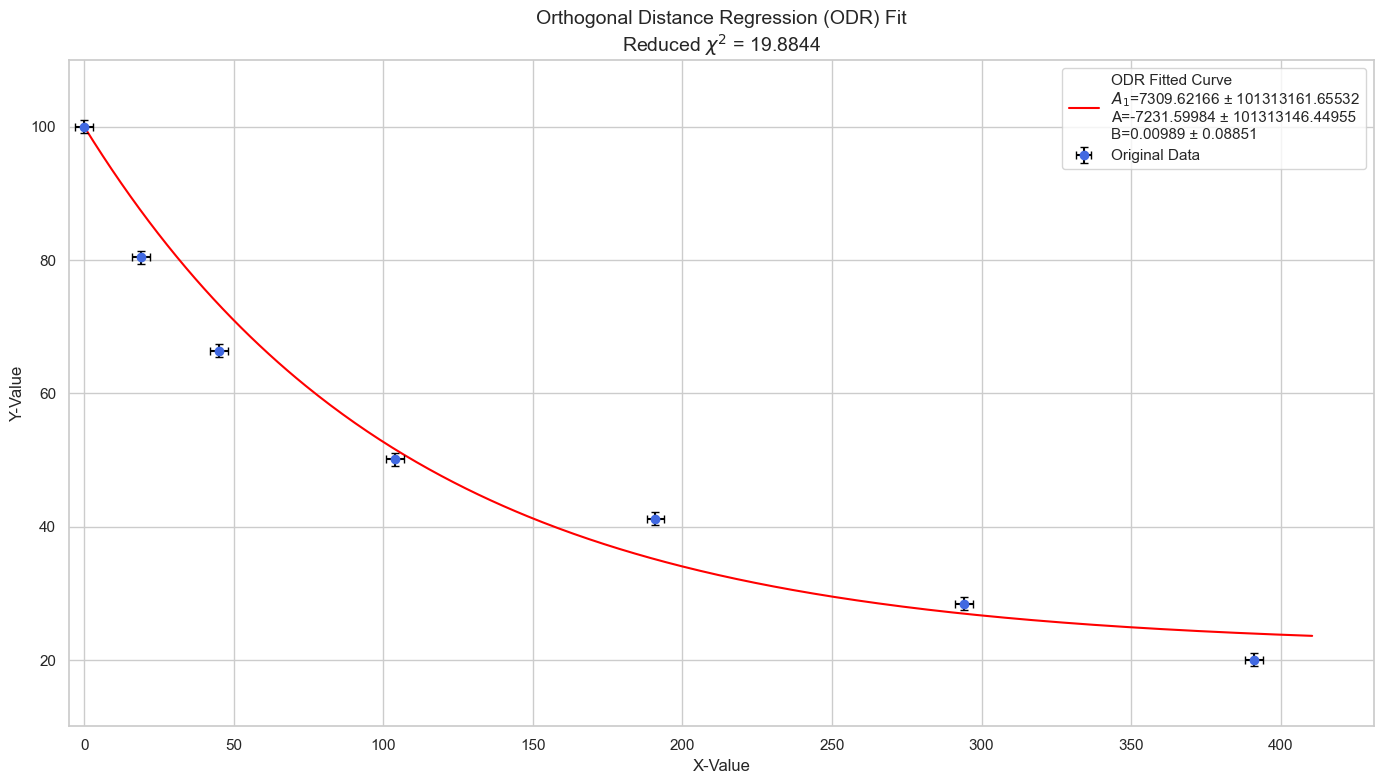

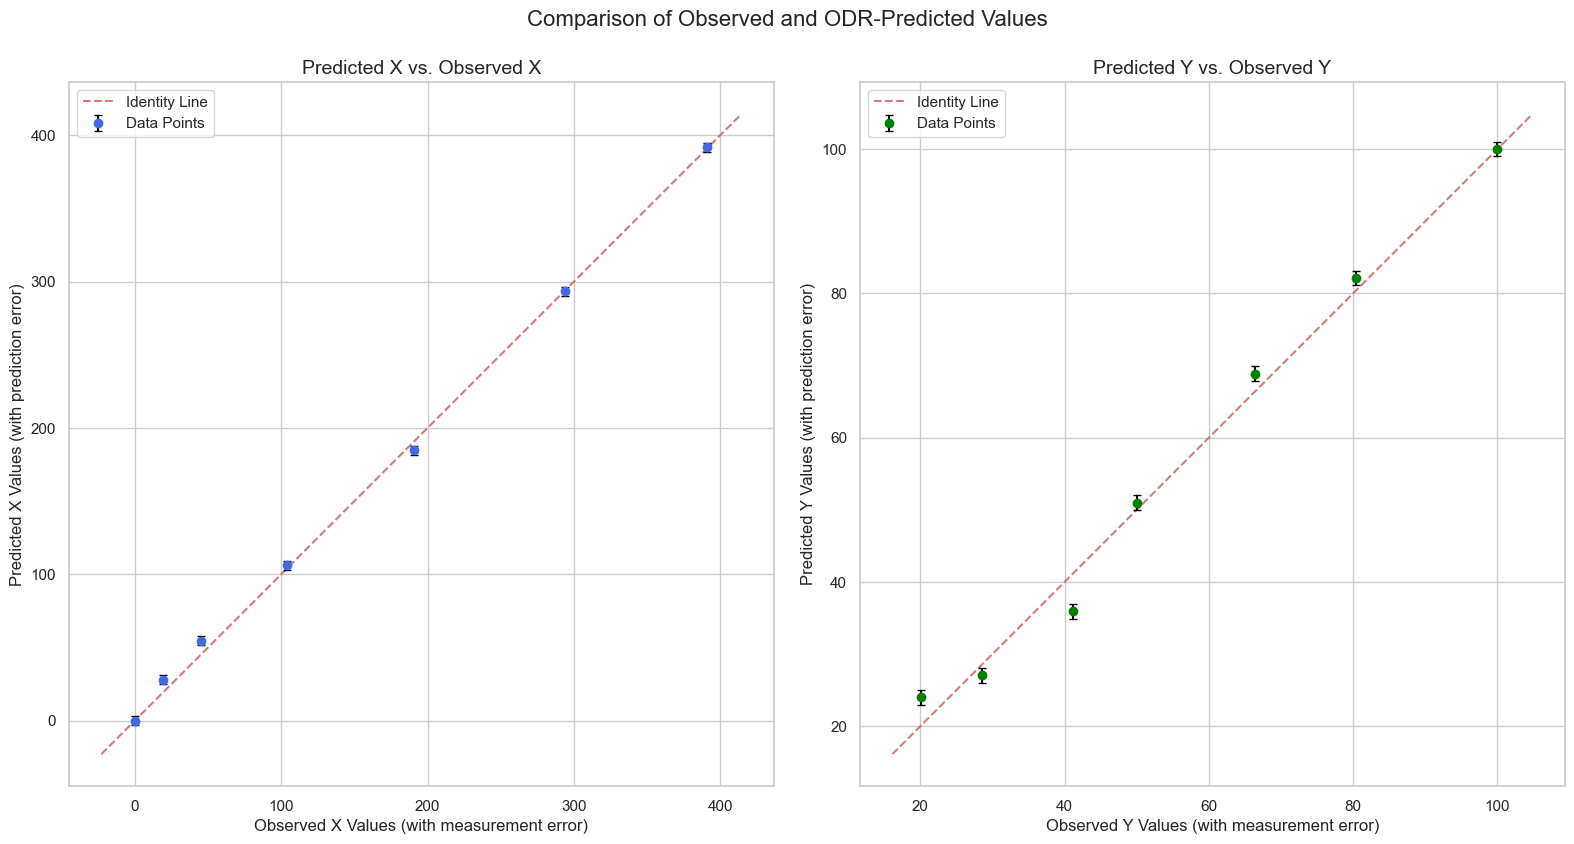

In [ ]:
def model_function(beta, x):
    """
    The custom function to approximate the data.
    f(x; A, B) = A_1 * (np.exp(-B_1 * x) - 1) + A * (np.exp(-B * x) - 1) + 100
    Note: The signature is now (beta, x) for scipy.odr.
    """

    # A_1 = 56.769 # obtained from Dataset 3 with sigma_x = 2.0, sigma_y = 0.5
    B_1 = 0.00988 # obtained from Dataset 3 with sigma_x = 2.0, sigma_y = 0.5

    # A_1 = 56.747 # obtained from Dataset 3 with sigma_x = 3.0, sigma_y = 0.5
    # B_1 = 0.00991 # obtained from Dataset 3 with sigma_x = 3.0, sigma_y = 0.5

    A_1, A, B = beta
    
    return A_1 * (np.exp(-B_1 * x) - 1) + A * (np.exp(-B * x) - 1) + 100

# Dataset 2
x = np.array([0, 19, 45, 104, 191, 294, 391])
y_obs = np.array([100, 80.4, 66.4, 50.1, 41.2, 28.5, 20.1])
sigma_y = np.full_like(y_obs, 1.0, dtype=float)
sigma_x = np.full_like(x, 3.0, dtype=float)
initial_guess = [56.769, 50, 0.01]

# Analyze the curve fit and get results using ODR
odr_results = analyze_odr(x, y_obs, sigma_x, sigma_y, model_function, initial_guess)

# Print the metrics
print_metrics(odr_results)

# Draw the curve fit plot
draw_curve_fit_simple(odr_results, model_function)

# Plot predicted vs observed values
plot_predicted_vs_observed(odr_results, show_errors=True)